In [94]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
import pickle
# physical_devices = tf.test.gpu_device_name()

from tensorflow import keras

if len(physical_devices) > 0:
    print(physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.3.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [95]:

trainInput1 = np.load('trainInput1.npy')
trainInput2 = np.load('trainInput2.npy')
trainOutput = np.load('trainOutput.npy')

testInput1 = np.load('testInput1.npy')
testInput2 = np.load('testInput2.npy')
testOutput = np.load('testOutput.npy')

valInput1 = np.load('valInput1.npy')
valInput2 = np.load('valInput2.npy')
valOutput = np.load('valOutput.npy')

meanStdStress_shuffled = np.load('meanStdStress_shuffled.npy', allow_pickle=True)

In [96]:
def UNet():

    input1 = keras.Input(shape=(trainInput1.shape[1], trainInput1.shape[2], 1), batch_size=40)
    input2 = keras.Input(shape=(trainInput1.shape[1], trainInput1.shape[2], 1), batch_size=40)

    merged_input = keras.layers.concatenate([input1, input2])

# First Layer

    conv1 = keras.layers.Conv2D(filters=15, kernel_size=(7, 7), strides=1, activation='relu')(merged_input)

    conv2 = keras.layers.Conv2D(filters=15, kernel_size=(7, 7), strides=1, activation='relu')(conv1)

    maxpool1 = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(conv2)

# Second Layer

    conv3 = keras.layers.Conv2D(filters=30, kernel_size=(5, 5), strides=1, activation='relu')(maxpool1)

    conv4 = keras.layers.Conv2D(filters=30, kernel_size=(5, 5), strides=1, activation='relu')(conv3)

    maxpool2 = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(conv4)

# Third Layer

    conv5 = keras.layers.Conv2D(filters=60, kernel_size=(3, 3), strides=1, activation='relu')(maxpool2)

    conv6 = keras.layers.Conv2D(filters=60, kernel_size=(3, 3), strides=1, activation='relu')(conv5)

    deconv1 = keras.layers.Conv2DTranspose(filters=60,kernel_size=(3,3), strides=1, activation='relu')(conv6)

    deconv2 = keras.layers.Conv2DTranspose(filters=60,kernel_size=(3,3), strides=1, activation='relu')(deconv1)

    upsample1 = keras.layers.UpSampling2D(size=(2,2))(deconv2)

# Fourth Layer

    midmerge1 = keras.layers.concatenate([upsample1, conv4])

    deconv3 = keras.layers.Conv2DTranspose(filters=30,kernel_size=(5,5), strides=1, activation='relu')(midmerge1)

    deconv4 = keras.layers.Conv2DTranspose(filters=30, kernel_size=(5, 5), strides=1, activation='relu')(deconv3)

    upsample2 = keras.layers.UpSampling2D(size=(2,2))(deconv4)

#  Fifth Layer

    midmerge2 = keras.layers.concatenate([upsample2, conv2])

    deconv5 = keras.layers.Conv2DTranspose(filters=15,kernel_size=(7,7), strides=1, activation='relu')(midmerge2)

    deconv6 = keras.layers.Conv2DTranspose(filters=15,kernel_size=(7,7), strides=1, activation='relu')(deconv5)

    output = keras.layers.Conv2DTranspose(filters=1,kernel_size=(1,1), strides=1)(deconv6)


    model = keras.Model(inputs=[input1, input2], outputs=output, name= 'UNet')
    model.summary()
    tf.keras.utils.plot_model(model, 'Stress_UNet_CNN.png', show_shapes=True)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(optimizer=opt, loss="mae", metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model



model = UNet()


Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(40, 300, 300, 1)]  0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(40, 300, 300, 1)]  0                                            
__________________________________________________________________________________________________
concatenate_50 (Concatenate)    (40, 300, 300, 2)    0           input_35[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (40, 294, 294, 15)   1485        concatenate_50[0][0]          

In [77]:
checkpoint_path = "training_UNet_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(x = [trainInput1,trainInput2],
                     y= trainOutput,batch_size=40,epochs=1000,
                     validation_data=([valInput1,valInput2],valOutput),
                     validation_batch_size=40, callbacks=cp_callback)

Epoch 1/1000
7/7 [==============================] - ETA: 0s - loss: 0.2471 - root_mean_squared_error: 0.5249WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0121s vs `on_test_batch_end` time: 0.1784s). Check your callbacks.

Epoch 00001: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 757ms/step - loss: 0.2471 - root_mean_squared_error: 0.5249 - val_loss: 0.2230 - val_root_mean_squared_error: 0.5015
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.2468 - root_mean_squared_error: 0.5247
Epoch 00002: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 745ms/step - loss: 0.2468 - root_mean_squared_error: 0.5247 - val_loss: 0.2246 - val_root_mean_squared_error: 0.4996
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.2478 - root_mean_squared_error: 0.5265
Epoch 00003: saving model to training_UNet_1\cp.ckpt
7/7 [==================

Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.2426 - root_mean_squared_error: 0.5139
Epoch 00051: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 778ms/step - loss: 0.2426 - root_mean_squared_error: 0.5139 - val_loss: 0.2210 - val_root_mean_squared_error: 0.4877
Epoch 52/1000
7/7 [==============================] - ETA: 0s - loss: 0.2410 - root_mean_squared_error: 0.5117
Epoch 00052: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 778ms/step - loss: 0.2410 - root_mean_squared_error: 0.5117 - val_loss: 0.2204 - val_root_mean_squared_error: 0.4920
Epoch 53/1000
7/7 [==============================] - ETA: 0s - loss: 0.2413 - root_mean_squared_error: 0.5106
Epoch 00053: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 777ms/step - loss: 0.2413 - root_mean_squared_error: 0.5106 - val_loss: 0.2216 - val_root_mean_squared_error: 0.4963
Epoch 54/1000
7/7 [===============

Epoch 77/1000
7/7 [==============================] - ETA: 0s - loss: 0.2392 - root_mean_squared_error: 0.5095
Epoch 00077: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.2392 - root_mean_squared_error: 0.5095 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4867
Epoch 78/1000
7/7 [==============================] - ETA: 0s - loss: 0.2388 - root_mean_squared_error: 0.5041
Epoch 00078: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.2388 - root_mean_squared_error: 0.5041 - val_loss: 0.2192 - val_root_mean_squared_error: 0.4901
Epoch 79/1000
7/7 [==============================] - ETA: 0s - loss: 0.2389 - root_mean_squared_error: 0.5088
Epoch 00079: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.2389 - root_mean_squared_error: 0.5088 - val_loss: 0.2193 - val_root_mean_squared_error: 0.4850
Epoch 80/1000
7/7 [===============

Epoch 103/1000
7/7 [==============================] - ETA: 0s - loss: 0.2366 - root_mean_squared_error: 0.5030
Epoch 00103: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.2366 - root_mean_squared_error: 0.5030 - val_loss: 0.2181 - val_root_mean_squared_error: 0.4893
Epoch 104/1000
7/7 [==============================] - ETA: 0s - loss: 0.2371 - root_mean_squared_error: 0.5015
Epoch 00104: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.2371 - root_mean_squared_error: 0.5015 - val_loss: 0.2203 - val_root_mean_squared_error: 0.4951
Epoch 105/1000
7/7 [==============================] - ETA: 0s - loss: 0.2363 - root_mean_squared_error: 0.5032
Epoch 00105: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.2363 - root_mean_squared_error: 0.5032 - val_loss: 0.2175 - val_root_mean_squared_error: 0.4861
Epoch 106/1000
7/7 [===========

Epoch 129/1000
7/7 [==============================] - ETA: 0s - loss: 0.2353 - root_mean_squared_error: 0.5018
Epoch 00129: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.2353 - root_mean_squared_error: 0.5018 - val_loss: 0.2183 - val_root_mean_squared_error: 0.4846
Epoch 130/1000
7/7 [==============================] - ETA: 0s - loss: 0.2357 - root_mean_squared_error: 0.5014
Epoch 00130: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.2357 - root_mean_squared_error: 0.5014 - val_loss: 0.2191 - val_root_mean_squared_error: 0.4872
Epoch 131/1000
7/7 [==============================] - ETA: 0s - loss: 0.2347 - root_mean_squared_error: 0.4975
Epoch 00131: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.2347 - root_mean_squared_error: 0.4975 - val_loss: 0.2195 - val_root_mean_squared_error: 0.4940
Epoch 132/1000
7/7 [===========

Epoch 155/1000
7/7 [==============================] - ETA: 0s - loss: 0.2326 - root_mean_squared_error: 0.4949
Epoch 00155: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.2326 - root_mean_squared_error: 0.4949 - val_loss: 0.2174 - val_root_mean_squared_error: 0.4856
Epoch 156/1000
7/7 [==============================] - ETA: 0s - loss: 0.2339 - root_mean_squared_error: 0.4985
Epoch 00156: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.2339 - root_mean_squared_error: 0.4985 - val_loss: 0.2191 - val_root_mean_squared_error: 0.4825
Epoch 157/1000
7/7 [==============================] - ETA: 0s - loss: 0.2333 - root_mean_squared_error: 0.4966
Epoch 00157: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.2333 - root_mean_squared_error: 0.4966 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4862
Epoch 158/1000
7/7 [===========

Epoch 181/1000
7/7 [==============================] - ETA: 0s - loss: 0.2325 - root_mean_squared_error: 0.4962
Epoch 00181: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2325 - root_mean_squared_error: 0.4962 - val_loss: 0.2175 - val_root_mean_squared_error: 0.4822
Epoch 182/1000
7/7 [==============================] - ETA: 0s - loss: 0.2343 - root_mean_squared_error: 0.4960
Epoch 00182: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2343 - root_mean_squared_error: 0.4960 - val_loss: 0.2185 - val_root_mean_squared_error: 0.4885
Epoch 183/1000
7/7 [==============================] - ETA: 0s - loss: 0.2310 - root_mean_squared_error: 0.4916
Epoch 00183: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2310 - root_mean_squared_error: 0.4916 - val_loss: 0.2173 - val_root_mean_squared_error: 0.4858
Epoch 184/1000
7/7 [===========

Epoch 207/1000
7/7 [==============================] - ETA: 0s - loss: 0.2294 - root_mean_squared_error: 0.4895
Epoch 00207: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2294 - root_mean_squared_error: 0.4895 - val_loss: 0.2165 - val_root_mean_squared_error: 0.4826
Epoch 208/1000
7/7 [==============================] - ETA: 0s - loss: 0.2292 - root_mean_squared_error: 0.4881
Epoch 00208: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2292 - root_mean_squared_error: 0.4881 - val_loss: 0.2186 - val_root_mean_squared_error: 0.4912
Epoch 209/1000
7/7 [==============================] - ETA: 0s - loss: 0.2287 - root_mean_squared_error: 0.4869
Epoch 00209: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2287 - root_mean_squared_error: 0.4869 - val_loss: 0.2174 - val_root_mean_squared_error: 0.4840
Epoch 210/1000
7/7 [===========

Epoch 233/1000
7/7 [==============================] - ETA: 0s - loss: 0.2281 - root_mean_squared_error: 0.4857
Epoch 00233: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2281 - root_mean_squared_error: 0.4857 - val_loss: 0.2185 - val_root_mean_squared_error: 0.4898
Epoch 234/1000
7/7 [==============================] - ETA: 0s - loss: 0.2282 - root_mean_squared_error: 0.4901
Epoch 00234: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2282 - root_mean_squared_error: 0.4901 - val_loss: 0.2179 - val_root_mean_squared_error: 0.4836
Epoch 235/1000
7/7 [==============================] - ETA: 0s - loss: 0.2278 - root_mean_squared_error: 0.4847
Epoch 00235: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2278 - root_mean_squared_error: 0.4847 - val_loss: 0.2204 - val_root_mean_squared_error: 0.4948
Epoch 236/1000
7/7 [===========

Epoch 259/1000
7/7 [==============================] - ETA: 0s - loss: 0.2259 - root_mean_squared_error: 0.4836
Epoch 00259: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2259 - root_mean_squared_error: 0.4836 - val_loss: 0.2184 - val_root_mean_squared_error: 0.4892
Epoch 260/1000
7/7 [==============================] - ETA: 0s - loss: 0.2258 - root_mean_squared_error: 0.4831
Epoch 00260: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2258 - root_mean_squared_error: 0.4831 - val_loss: 0.2189 - val_root_mean_squared_error: 0.4890
Epoch 261/1000
7/7 [==============================] - ETA: 0s - loss: 0.2258 - root_mean_squared_error: 0.4816
Epoch 00261: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2258 - root_mean_squared_error: 0.4816 - val_loss: 0.2185 - val_root_mean_squared_error: 0.4904
Epoch 262/1000
7/7 [===========

Epoch 285/1000
7/7 [==============================] - ETA: 0s - loss: 0.2271 - root_mean_squared_error: 0.4854
Epoch 00285: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2271 - root_mean_squared_error: 0.4854 - val_loss: 0.2176 - val_root_mean_squared_error: 0.4831
Epoch 286/1000
7/7 [==============================] - ETA: 0s - loss: 0.2252 - root_mean_squared_error: 0.4794
Epoch 00286: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2252 - root_mean_squared_error: 0.4794 - val_loss: 0.2181 - val_root_mean_squared_error: 0.4889
Epoch 287/1000
7/7 [==============================] - ETA: 0s - loss: 0.2244 - root_mean_squared_error: 0.4791
Epoch 00287: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2244 - root_mean_squared_error: 0.4791 - val_loss: 0.2187 - val_root_mean_squared_error: 0.4889
Epoch 288/1000
7/7 [===========

Epoch 311/1000
7/7 [==============================] - ETA: 0s - loss: 0.2238 - root_mean_squared_error: 0.4789
Epoch 00311: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2238 - root_mean_squared_error: 0.4789 - val_loss: 0.2182 - val_root_mean_squared_error: 0.4882
Epoch 312/1000
7/7 [==============================] - ETA: 0s - loss: 0.2228 - root_mean_squared_error: 0.4773
Epoch 00312: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2228 - root_mean_squared_error: 0.4773 - val_loss: 0.2179 - val_root_mean_squared_error: 0.4853
Epoch 313/1000
7/7 [==============================] - ETA: 0s - loss: 0.2232 - root_mean_squared_error: 0.4784
Epoch 00313: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.2232 - root_mean_squared_error: 0.4784 - val_loss: 0.2186 - val_root_mean_squared_error: 0.4852
Epoch 314/1000
7/7 [===========

Epoch 337/1000
7/7 [==============================] - ETA: 0s - loss: 0.2224 - root_mean_squared_error: 0.4762
Epoch 00337: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2224 - root_mean_squared_error: 0.4762 - val_loss: 0.2193 - val_root_mean_squared_error: 0.4926
Epoch 338/1000
7/7 [==============================] - ETA: 0s - loss: 0.2218 - root_mean_squared_error: 0.4756
Epoch 00338: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2218 - root_mean_squared_error: 0.4756 - val_loss: 0.2186 - val_root_mean_squared_error: 0.4879
Epoch 339/1000
7/7 [==============================] - ETA: 0s - loss: 0.2214 - root_mean_squared_error: 0.4752
Epoch 00339: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2214 - root_mean_squared_error: 0.4752 - val_loss: 0.2186 - val_root_mean_squared_error: 0.4865
Epoch 340/1000
7/7 [===========

Epoch 363/1000
7/7 [==============================] - ETA: 0s - loss: 0.2227 - root_mean_squared_error: 0.4773
Epoch 00363: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2227 - root_mean_squared_error: 0.4773 - val_loss: 0.2182 - val_root_mean_squared_error: 0.4863
Epoch 364/1000
7/7 [==============================] - ETA: 0s - loss: 0.2205 - root_mean_squared_error: 0.4724
Epoch 00364: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.2205 - root_mean_squared_error: 0.4724 - val_loss: 0.2188 - val_root_mean_squared_error: 0.4871
Epoch 365/1000
7/7 [==============================] - ETA: 0s - loss: 0.2218 - root_mean_squared_error: 0.4755
Epoch 00365: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2218 - root_mean_squared_error: 0.4755 - val_loss: 0.2181 - val_root_mean_squared_error: 0.4888
Epoch 366/1000
7/7 [===========

Epoch 389/1000
7/7 [==============================] - ETA: 0s - loss: 0.2209 - root_mean_squared_error: 0.4720
Epoch 00389: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2209 - root_mean_squared_error: 0.4720 - val_loss: 0.2199 - val_root_mean_squared_error: 0.4956
Epoch 390/1000
7/7 [==============================] - ETA: 0s - loss: 0.2210 - root_mean_squared_error: 0.4750
Epoch 00390: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2210 - root_mean_squared_error: 0.4750 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4858
Epoch 391/1000
7/7 [==============================] - ETA: 0s - loss: 0.2192 - root_mean_squared_error: 0.4696
Epoch 00391: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2192 - root_mean_squared_error: 0.4696 - val_loss: 0.2193 - val_root_mean_squared_error: 0.4923
Epoch 392/1000
7/7 [===========

Epoch 415/1000
7/7 [==============================] - ETA: 0s - loss: 0.2189 - root_mean_squared_error: 0.4694
Epoch 00415: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2189 - root_mean_squared_error: 0.4694 - val_loss: 0.2204 - val_root_mean_squared_error: 0.4941
Epoch 416/1000
7/7 [==============================] - ETA: 0s - loss: 0.2189 - root_mean_squared_error: 0.4693
Epoch 00416: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2189 - root_mean_squared_error: 0.4693 - val_loss: 0.2189 - val_root_mean_squared_error: 0.4893
Epoch 417/1000
7/7 [==============================] - ETA: 0s - loss: 0.2185 - root_mean_squared_error: 0.4726
Epoch 00417: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2185 - root_mean_squared_error: 0.4726 - val_loss: 0.2205 - val_root_mean_squared_error: 0.4885
Epoch 418/1000
7/7 [===========

Epoch 441/1000
7/7 [==============================] - ETA: 0s - loss: 0.2179 - root_mean_squared_error: 0.4664
Epoch 00441: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2179 - root_mean_squared_error: 0.4664 - val_loss: 0.2195 - val_root_mean_squared_error: 0.4915
Epoch 442/1000
7/7 [==============================] - ETA: 0s - loss: 0.2173 - root_mean_squared_error: 0.4670
Epoch 00442: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2173 - root_mean_squared_error: 0.4670 - val_loss: 0.2208 - val_root_mean_squared_error: 0.4967
Epoch 443/1000
7/7 [==============================] - ETA: 0s - loss: 0.2170 - root_mean_squared_error: 0.4658
Epoch 00443: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658 - val_loss: 0.2197 - val_root_mean_squared_error: 0.4940
Epoch 444/1000
7/7 [===========

Epoch 467/1000
7/7 [==============================] - ETA: 0s - loss: 0.2162 - root_mean_squared_error: 0.4645
Epoch 00467: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2162 - root_mean_squared_error: 0.4645 - val_loss: 0.2199 - val_root_mean_squared_error: 0.4925
Epoch 468/1000
7/7 [==============================] - ETA: 0s - loss: 0.2162 - root_mean_squared_error: 0.4639
Epoch 00468: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2162 - root_mean_squared_error: 0.4639 - val_loss: 0.2203 - val_root_mean_squared_error: 0.4963
Epoch 469/1000
7/7 [==============================] - ETA: 0s - loss: 0.2167 - root_mean_squared_error: 0.4664
Epoch 00469: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2167 - root_mean_squared_error: 0.4664 - val_loss: 0.2206 - val_root_mean_squared_error: 0.4950
Epoch 470/1000
7/7 [===========

Epoch 493/1000
7/7 [==============================] - ETA: 0s - loss: 0.2151 - root_mean_squared_error: 0.4630
Epoch 00493: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2151 - root_mean_squared_error: 0.4630 - val_loss: 0.2214 - val_root_mean_squared_error: 0.4926
Epoch 494/1000
7/7 [==============================] - ETA: 0s - loss: 0.2155 - root_mean_squared_error: 0.4627
Epoch 00494: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2155 - root_mean_squared_error: 0.4627 - val_loss: 0.2192 - val_root_mean_squared_error: 0.4897
Epoch 495/1000
7/7 [==============================] - ETA: 0s - loss: 0.2145 - root_mean_squared_error: 0.4625
Epoch 00495: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.2145 - root_mean_squared_error: 0.4625 - val_loss: 0.2204 - val_root_mean_squared_error: 0.4918
Epoch 496/1000
7/7 [===========

Epoch 519/1000
7/7 [==============================] - ETA: 0s - loss: 0.2140 - root_mean_squared_error: 0.4603
Epoch 00519: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2140 - root_mean_squared_error: 0.4603 - val_loss: 0.2217 - val_root_mean_squared_error: 0.4979
Epoch 520/1000
7/7 [==============================] - ETA: 0s - loss: 0.2157 - root_mean_squared_error: 0.4639
Epoch 00520: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2157 - root_mean_squared_error: 0.4639 - val_loss: 0.2196 - val_root_mean_squared_error: 0.4923
Epoch 521/1000
7/7 [==============================] - ETA: 0s - loss: 0.2157 - root_mean_squared_error: 0.4632
Epoch 00521: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2157 - root_mean_squared_error: 0.4632 - val_loss: 0.2224 - val_root_mean_squared_error: 0.4987
Epoch 522/1000
7/7 [===========

Epoch 545/1000
7/7 [==============================] - ETA: 0s - loss: 0.2135 - root_mean_squared_error: 0.4614
Epoch 00545: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2135 - root_mean_squared_error: 0.4614 - val_loss: 0.2217 - val_root_mean_squared_error: 0.4959
Epoch 546/1000
7/7 [==============================] - ETA: 0s - loss: 0.2148 - root_mean_squared_error: 0.4614
Epoch 00546: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2148 - root_mean_squared_error: 0.4614 - val_loss: 0.2208 - val_root_mean_squared_error: 0.4958
Epoch 547/1000
7/7 [==============================] - ETA: 0s - loss: 0.2143 - root_mean_squared_error: 0.4635
Epoch 00547: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2143 - root_mean_squared_error: 0.4635 - val_loss: 0.2208 - val_root_mean_squared_error: 0.4907
Epoch 548/1000
7/7 [===========

Epoch 571/1000
7/7 [==============================] - ETA: 0s - loss: 0.2114 - root_mean_squared_error: 0.4567
Epoch 00571: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2114 - root_mean_squared_error: 0.4567 - val_loss: 0.2220 - val_root_mean_squared_error: 0.4977
Epoch 572/1000
7/7 [==============================] - ETA: 0s - loss: 0.2112 - root_mean_squared_error: 0.4546
Epoch 00572: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2112 - root_mean_squared_error: 0.4546 - val_loss: 0.2226 - val_root_mean_squared_error: 0.5024
Epoch 573/1000
7/7 [==============================] - ETA: 0s - loss: 0.2126 - root_mean_squared_error: 0.4594
Epoch 00573: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2126 - root_mean_squared_error: 0.4594 - val_loss: 0.2211 - val_root_mean_squared_error: 0.4942
Epoch 574/1000
7/7 [===========

Epoch 597/1000
7/7 [==============================] - ETA: 0s - loss: 0.2098 - root_mean_squared_error: 0.4526
Epoch 00597: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2098 - root_mean_squared_error: 0.4526 - val_loss: 0.2237 - val_root_mean_squared_error: 0.5033
Epoch 598/1000
7/7 [==============================] - ETA: 0s - loss: 0.2107 - root_mean_squared_error: 0.4551
Epoch 00598: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2107 - root_mean_squared_error: 0.4551 - val_loss: 0.2219 - val_root_mean_squared_error: 0.4978
Epoch 599/1000
7/7 [==============================] - ETA: 0s - loss: 0.2097 - root_mean_squared_error: 0.4547
Epoch 00599: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2097 - root_mean_squared_error: 0.4547 - val_loss: 0.2212 - val_root_mean_squared_error: 0.4944
Epoch 600/1000
7/7 [===========

Epoch 623/1000
7/7 [==============================] - ETA: 0s - loss: 0.2086 - root_mean_squared_error: 0.4524
Epoch 00623: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2086 - root_mean_squared_error: 0.4524 - val_loss: 0.2212 - val_root_mean_squared_error: 0.4961
Epoch 624/1000
7/7 [==============================] - ETA: 0s - loss: 0.2092 - root_mean_squared_error: 0.4533
Epoch 00624: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.2092 - root_mean_squared_error: 0.4533 - val_loss: 0.2222 - val_root_mean_squared_error: 0.4982
Epoch 625/1000
7/7 [==============================] - ETA: 0s - loss: 0.2094 - root_mean_squared_error: 0.4541
Epoch 00625: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2094 - root_mean_squared_error: 0.4541 - val_loss: 0.2216 - val_root_mean_squared_error: 0.4959
Epoch 626/1000
7/7 [===========

Epoch 649/1000
7/7 [==============================] - ETA: 0s - loss: 0.2089 - root_mean_squared_error: 0.4520
Epoch 00649: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.2089 - root_mean_squared_error: 0.4520 - val_loss: 0.2233 - val_root_mean_squared_error: 0.4997
Epoch 650/1000
7/7 [==============================] - ETA: 0s - loss: 0.2079 - root_mean_squared_error: 0.4510
Epoch 00650: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2079 - root_mean_squared_error: 0.4510 - val_loss: 0.2217 - val_root_mean_squared_error: 0.4955
Epoch 651/1000
7/7 [==============================] - ETA: 0s - loss: 0.2071 - root_mean_squared_error: 0.4490
Epoch 00651: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2071 - root_mean_squared_error: 0.4490 - val_loss: 0.2234 - val_root_mean_squared_error: 0.5011
Epoch 652/1000
7/7 [===========

Epoch 675/1000
7/7 [==============================] - ETA: 0s - loss: 0.2117 - root_mean_squared_error: 0.4561
Epoch 00675: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2117 - root_mean_squared_error: 0.4561 - val_loss: 0.2234 - val_root_mean_squared_error: 0.4990
Epoch 676/1000
7/7 [==============================] - ETA: 0s - loss: 0.2085 - root_mean_squared_error: 0.4511
Epoch 00676: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2085 - root_mean_squared_error: 0.4511 - val_loss: 0.2246 - val_root_mean_squared_error: 0.5055
Epoch 677/1000
7/7 [==============================] - ETA: 0s - loss: 0.2082 - root_mean_squared_error: 0.4512
Epoch 00677: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2082 - root_mean_squared_error: 0.4512 - val_loss: 0.2228 - val_root_mean_squared_error: 0.4987
Epoch 678/1000
7/7 [===========

Epoch 701/1000
7/7 [==============================] - ETA: 0s - loss: 0.2058 - root_mean_squared_error: 0.4477
Epoch 00701: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2058 - root_mean_squared_error: 0.4477 - val_loss: 0.2230 - val_root_mean_squared_error: 0.4992
Epoch 702/1000
7/7 [==============================] - ETA: 0s - loss: 0.2064 - root_mean_squared_error: 0.4481
Epoch 00702: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2064 - root_mean_squared_error: 0.4481 - val_loss: 0.2229 - val_root_mean_squared_error: 0.4985
Epoch 703/1000
7/7 [==============================] - ETA: 0s - loss: 0.2069 - root_mean_squared_error: 0.4498
Epoch 00703: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2069 - root_mean_squared_error: 0.4498 - val_loss: 0.2228 - val_root_mean_squared_error: 0.4946
Epoch 704/1000
7/7 [===========

Epoch 727/1000
7/7 [==============================] - ETA: 0s - loss: 0.2051 - root_mean_squared_error: 0.4461
Epoch 00727: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2051 - root_mean_squared_error: 0.4461 - val_loss: 0.2233 - val_root_mean_squared_error: 0.5010
Epoch 728/1000
7/7 [==============================] - ETA: 0s - loss: 0.2049 - root_mean_squared_error: 0.4449
Epoch 00728: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2049 - root_mean_squared_error: 0.4449 - val_loss: 0.2238 - val_root_mean_squared_error: 0.5039
Epoch 729/1000
7/7 [==============================] - ETA: 0s - loss: 0.2050 - root_mean_squared_error: 0.4458
Epoch 00729: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2050 - root_mean_squared_error: 0.4458 - val_loss: 0.2244 - val_root_mean_squared_error: 0.5047
Epoch 730/1000
7/7 [===========

Epoch 753/1000
7/7 [==============================] - ETA: 0s - loss: 0.2047 - root_mean_squared_error: 0.4445
Epoch 00753: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2047 - root_mean_squared_error: 0.4445 - val_loss: 0.2259 - val_root_mean_squared_error: 0.5075
Epoch 754/1000
7/7 [==============================] - ETA: 0s - loss: 0.2045 - root_mean_squared_error: 0.4452
Epoch 00754: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2045 - root_mean_squared_error: 0.4452 - val_loss: 0.2235 - val_root_mean_squared_error: 0.5008
Epoch 755/1000
7/7 [==============================] - ETA: 0s - loss: 0.2056 - root_mean_squared_error: 0.4443
Epoch 00755: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2056 - root_mean_squared_error: 0.4443 - val_loss: 0.2256 - val_root_mean_squared_error: 0.5100
Epoch 756/1000
7/7 [===========

Epoch 779/1000
7/7 [==============================] - ETA: 0s - loss: 0.2033 - root_mean_squared_error: 0.4430
Epoch 00779: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.2033 - root_mean_squared_error: 0.4430 - val_loss: 0.2236 - val_root_mean_squared_error: 0.5000
Epoch 780/1000
7/7 [==============================] - ETA: 0s - loss: 0.2041 - root_mean_squared_error: 0.4434
Epoch 00780: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2041 - root_mean_squared_error: 0.4434 - val_loss: 0.2243 - val_root_mean_squared_error: 0.5020
Epoch 781/1000
7/7 [==============================] - ETA: 0s - loss: 0.2030 - root_mean_squared_error: 0.4425
Epoch 00781: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2030 - root_mean_squared_error: 0.4425 - val_loss: 0.2250 - val_root_mean_squared_error: 0.5048
Epoch 782/1000
7/7 [===========

Epoch 805/1000
7/7 [==============================] - ETA: 0s - loss: 0.2030 - root_mean_squared_error: 0.4416
Epoch 00805: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2030 - root_mean_squared_error: 0.4416 - val_loss: 0.2248 - val_root_mean_squared_error: 0.5056
Epoch 806/1000
7/7 [==============================] - ETA: 0s - loss: 0.2033 - root_mean_squared_error: 0.4423
Epoch 00806: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2033 - root_mean_squared_error: 0.4423 - val_loss: 0.2234 - val_root_mean_squared_error: 0.5016
Epoch 807/1000
7/7 [==============================] - ETA: 0s - loss: 0.2039 - root_mean_squared_error: 0.4434
Epoch 00807: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2039 - root_mean_squared_error: 0.4434 - val_loss: 0.2252 - val_root_mean_squared_error: 0.5077
Epoch 808/1000
7/7 [===========

Epoch 831/1000
7/7 [==============================] - ETA: 0s - loss: 0.2015 - root_mean_squared_error: 0.4403
Epoch 00831: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2015 - root_mean_squared_error: 0.4403 - val_loss: 0.2256 - val_root_mean_squared_error: 0.5025
Epoch 832/1000
7/7 [==============================] - ETA: 0s - loss: 0.2016 - root_mean_squared_error: 0.4387
Epoch 00832: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2016 - root_mean_squared_error: 0.4387 - val_loss: 0.2252 - val_root_mean_squared_error: 0.5048
Epoch 833/1000
7/7 [==============================] - ETA: 0s - loss: 0.2018 - root_mean_squared_error: 0.4410
Epoch 00833: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2018 - root_mean_squared_error: 0.4410 - val_loss: 0.2242 - val_root_mean_squared_error: 0.4993
Epoch 834/1000
7/7 [===========

Epoch 857/1000
7/7 [==============================] - ETA: 0s - loss: 0.2024 - root_mean_squared_error: 0.4408
Epoch 00857: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2024 - root_mean_squared_error: 0.4408 - val_loss: 0.2239 - val_root_mean_squared_error: 0.5015
Epoch 858/1000
7/7 [==============================] - ETA: 0s - loss: 0.2023 - root_mean_squared_error: 0.4407
Epoch 00858: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2023 - root_mean_squared_error: 0.4407 - val_loss: 0.2248 - val_root_mean_squared_error: 0.5014
Epoch 859/1000
7/7 [==============================] - ETA: 0s - loss: 0.2004 - root_mean_squared_error: 0.4383
Epoch 00859: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2004 - root_mean_squared_error: 0.4383 - val_loss: 0.2240 - val_root_mean_squared_error: 0.5009
Epoch 860/1000
7/7 [===========

Epoch 883/1000
7/7 [==============================] - ETA: 0s - loss: 0.2013 - root_mean_squared_error: 0.4389
Epoch 00883: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2013 - root_mean_squared_error: 0.4389 - val_loss: 0.2248 - val_root_mean_squared_error: 0.5032
Epoch 884/1000
7/7 [==============================] - ETA: 0s - loss: 0.2010 - root_mean_squared_error: 0.4390
Epoch 00884: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2010 - root_mean_squared_error: 0.4390 - val_loss: 0.2261 - val_root_mean_squared_error: 0.5048
Epoch 885/1000
7/7 [==============================] - ETA: 0s - loss: 0.2000 - root_mean_squared_error: 0.4373
Epoch 00885: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2000 - root_mean_squared_error: 0.4373 - val_loss: 0.2261 - val_root_mean_squared_error: 0.5046
Epoch 886/1000
7/7 [===========

Epoch 909/1000
7/7 [==============================] - ETA: 0s - loss: 0.2035 - root_mean_squared_error: 0.4437
Epoch 00909: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.2035 - root_mean_squared_error: 0.4437 - val_loss: 0.2262 - val_root_mean_squared_error: 0.5016
Epoch 910/1000
7/7 [==============================] - ETA: 0s - loss: 0.2041 - root_mean_squared_error: 0.4417
Epoch 00910: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.2041 - root_mean_squared_error: 0.4417 - val_loss: 0.2257 - val_root_mean_squared_error: 0.5020
Epoch 911/1000
7/7 [==============================] - ETA: 0s - loss: 0.2009 - root_mean_squared_error: 0.4388
Epoch 00911: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.2009 - root_mean_squared_error: 0.4388 - val_loss: 0.2267 - val_root_mean_squared_error: 0.5061
Epoch 912/1000
7/7 [===========

Epoch 935/1000
7/7 [==============================] - ETA: 0s - loss: 0.1987 - root_mean_squared_error: 0.4338
Epoch 00935: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1987 - root_mean_squared_error: 0.4338 - val_loss: 0.2270 - val_root_mean_squared_error: 0.5092
Epoch 936/1000
7/7 [==============================] - ETA: 0s - loss: 0.1995 - root_mean_squared_error: 0.4369
Epoch 00936: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1995 - root_mean_squared_error: 0.4369 - val_loss: 0.2246 - val_root_mean_squared_error: 0.5009
Epoch 937/1000
7/7 [==============================] - ETA: 0s - loss: 0.1989 - root_mean_squared_error: 0.4347
Epoch 00937: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1989 - root_mean_squared_error: 0.4347 - val_loss: 0.2273 - val_root_mean_squared_error: 0.5085
Epoch 938/1000
7/7 [===========

Epoch 961/1000
7/7 [==============================] - ETA: 0s - loss: 0.1996 - root_mean_squared_error: 0.4364
Epoch 00961: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1996 - root_mean_squared_error: 0.4364 - val_loss: 0.2264 - val_root_mean_squared_error: 0.5032
Epoch 962/1000
7/7 [==============================] - ETA: 0s - loss: 0.1990 - root_mean_squared_error: 0.4333
Epoch 00962: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1990 - root_mean_squared_error: 0.4333 - val_loss: 0.2265 - val_root_mean_squared_error: 0.5073
Epoch 963/1000
7/7 [==============================] - ETA: 0s - loss: 0.1986 - root_mean_squared_error: 0.4336
Epoch 00963: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1986 - root_mean_squared_error: 0.4336 - val_loss: 0.2279 - val_root_mean_squared_error: 0.5112
Epoch 964/1000
7/7 [===========

Epoch 987/1000
7/7 [==============================] - ETA: 0s - loss: 0.1972 - root_mean_squared_error: 0.4320
Epoch 00987: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1972 - root_mean_squared_error: 0.4320 - val_loss: 0.2259 - val_root_mean_squared_error: 0.5036
Epoch 988/1000
7/7 [==============================] - ETA: 0s - loss: 0.1972 - root_mean_squared_error: 0.4331
Epoch 00988: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 801ms/step - loss: 0.1972 - root_mean_squared_error: 0.4331 - val_loss: 0.2276 - val_root_mean_squared_error: 0.5082
Epoch 989/1000
7/7 [==============================] - ETA: 0s - loss: 0.1988 - root_mean_squared_error: 0.4333
Epoch 00989: saving model to training_UNet_1\cp.ckpt
7/7 [==============================] - 6s 804ms/step - loss: 0.1988 - root_mean_squared_error: 0.4333 - val_loss: 0.2282 - val_root_mean_squared_error: 0.5110
Epoch 990/1000
7/7 [===========

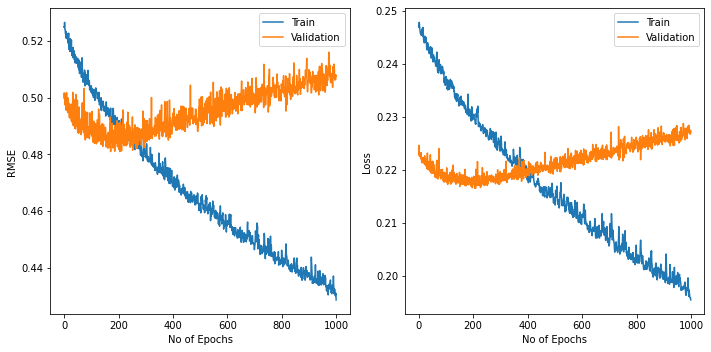

In [78]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('RMSE')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.tight_layout()

In [87]:
checkpoint_path = "training_UNet_1/cp.ckpt"

model = UNet()

model.load_weights(checkpoint_path)

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(40, 300, 300, 1)]  0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(40, 300, 300, 1)]  0                                            
__________________________________________________________________________________________________
concatenate_47 (Concatenate)    (40, 300, 300, 2)    0           input_33[0][0]                   
                                                                 input_34[0][0]                   
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (40, 294, 294, 15)   1485        concatenate_47[0][0]          

In [88]:
checkpoint_path = "training_UNet_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(x = [trainInput1,trainInput2],
                     y= trainOutput,batch_size=40,epochs=9000,
                     validation_data=([valInput1,valInput2],valOutput),
                     validation_batch_size=40, callbacks=cp_callback)

Epoch 1/9000
7/7 [==============================] - ETA: 0s - loss: 0.1956 - root_mean_squared_error: 0.4303WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_test_batch_end` time: 0.1799s). Check your callbacks.

Epoch 00001: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1956 - root_mean_squared_error: 0.4303 - val_loss: 0.2269 - val_root_mean_squared_error: 0.5080
Epoch 2/9000
7/7 [==============================] - ETA: 0s - loss: 0.1968 - root_mean_squared_error: 0.4318
Epoch 00002: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 749ms/step - loss: 0.1968 - root_mean_squared_error: 0.4318 - val_loss: 0.2256 - val_root_mean_squared_error: 0.5036
Epoch 3/9000
7/7 [==============================] - ETA: 0s - loss: 0.1970 - root_mean_squared_error: 0.4325
Epoch 00003: saving model to training_UNet_2\cp.ckpt
7/7 [==================

Epoch 51/9000
7/7 [==============================] - ETA: 0s - loss: 0.1967 - root_mean_squared_error: 0.4312
Epoch 00051: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 901ms/step - loss: 0.1967 - root_mean_squared_error: 0.4312 - val_loss: 0.2265 - val_root_mean_squared_error: 0.5059
Epoch 52/9000
7/7 [==============================] - ETA: 0s - loss: 0.1964 - root_mean_squared_error: 0.4304
Epoch 00052: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 776ms/step - loss: 0.1964 - root_mean_squared_error: 0.4304 - val_loss: 0.2266 - val_root_mean_squared_error: 0.5060
Epoch 53/9000
7/7 [==============================] - ETA: 0s - loss: 0.1951 - root_mean_squared_error: 0.4283
Epoch 00053: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 778ms/step - loss: 0.1951 - root_mean_squared_error: 0.4283 - val_loss: 0.2260 - val_root_mean_squared_error: 0.5052
Epoch 54/9000
7/7 [===============

Epoch 77/9000
7/7 [==============================] - ETA: 0s - loss: 0.1932 - root_mean_squared_error: 0.4253
Epoch 00077: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1932 - root_mean_squared_error: 0.4253 - val_loss: 0.2279 - val_root_mean_squared_error: 0.5109
Epoch 78/9000
7/7 [==============================] - ETA: 0s - loss: 0.1935 - root_mean_squared_error: 0.4270
Epoch 00078: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1935 - root_mean_squared_error: 0.4270 - val_loss: 0.2291 - val_root_mean_squared_error: 0.5116
Epoch 79/9000
7/7 [==============================] - ETA: 0s - loss: 0.1940 - root_mean_squared_error: 0.4267
Epoch 00079: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1940 - root_mean_squared_error: 0.4267 - val_loss: 0.2284 - val_root_mean_squared_error: 0.5113
Epoch 80/9000
7/7 [===============

Epoch 103/9000
7/7 [==============================] - ETA: 0s - loss: 0.1935 - root_mean_squared_error: 0.4256
Epoch 00103: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1935 - root_mean_squared_error: 0.4256 - val_loss: 0.2283 - val_root_mean_squared_error: 0.5117
Epoch 104/9000
7/7 [==============================] - ETA: 0s - loss: 0.1958 - root_mean_squared_error: 0.4294
Epoch 00104: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1958 - root_mean_squared_error: 0.4294 - val_loss: 0.2272 - val_root_mean_squared_error: 0.5082
Epoch 105/9000
7/7 [==============================] - ETA: 0s - loss: 0.1939 - root_mean_squared_error: 0.4260
Epoch 00105: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1939 - root_mean_squared_error: 0.4260 - val_loss: 0.2276 - val_root_mean_squared_error: 0.5099
Epoch 106/9000
7/7 [===========

Epoch 129/9000
7/7 [==============================] - ETA: 0s - loss: 0.1928 - root_mean_squared_error: 0.4245
Epoch 00129: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1928 - root_mean_squared_error: 0.4245 - val_loss: 0.2282 - val_root_mean_squared_error: 0.5113
Epoch 130/9000
7/7 [==============================] - ETA: 0s - loss: 0.1935 - root_mean_squared_error: 0.4262
Epoch 00130: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1935 - root_mean_squared_error: 0.4262 - val_loss: 0.2292 - val_root_mean_squared_error: 0.5126
Epoch 131/9000
7/7 [==============================] - ETA: 0s - loss: 0.1935 - root_mean_squared_error: 0.4262
Epoch 00131: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1935 - root_mean_squared_error: 0.4262 - val_loss: 0.2280 - val_root_mean_squared_error: 0.5085
Epoch 132/9000
7/7 [===========

Epoch 155/9000
7/7 [==============================] - ETA: 0s - loss: 0.1932 - root_mean_squared_error: 0.4251
Epoch 00155: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1932 - root_mean_squared_error: 0.4251 - val_loss: 0.2289 - val_root_mean_squared_error: 0.5137
Epoch 156/9000
7/7 [==============================] - ETA: 0s - loss: 0.1942 - root_mean_squared_error: 0.4266
Epoch 00156: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1942 - root_mean_squared_error: 0.4266 - val_loss: 0.2290 - val_root_mean_squared_error: 0.5146
Epoch 157/9000
7/7 [==============================] - ETA: 0s - loss: 0.1953 - root_mean_squared_error: 0.4283
Epoch 00157: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1953 - root_mean_squared_error: 0.4283 - val_loss: 0.2288 - val_root_mean_squared_error: 0.5136
Epoch 158/9000
7/7 [===========

Epoch 181/9000
7/7 [==============================] - ETA: 0s - loss: 0.1965 - root_mean_squared_error: 0.4295
Epoch 00181: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1965 - root_mean_squared_error: 0.4295 - val_loss: 0.2299 - val_root_mean_squared_error: 0.5167
Epoch 182/9000
7/7 [==============================] - ETA: 0s - loss: 0.1950 - root_mean_squared_error: 0.4278
Epoch 00182: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1950 - root_mean_squared_error: 0.4278 - val_loss: 0.2294 - val_root_mean_squared_error: 0.5152
Epoch 183/9000
7/7 [==============================] - ETA: 0s - loss: 0.1932 - root_mean_squared_error: 0.4244
Epoch 00183: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1932 - root_mean_squared_error: 0.4244 - val_loss: 0.2295 - val_root_mean_squared_error: 0.5153
Epoch 184/9000
7/7 [===========

Epoch 207/9000
7/7 [==============================] - ETA: 0s - loss: 0.1902 - root_mean_squared_error: 0.4206
Epoch 00207: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 829ms/step - loss: 0.1902 - root_mean_squared_error: 0.4206 - val_loss: 0.2288 - val_root_mean_squared_error: 0.5125
Epoch 208/9000
7/7 [==============================] - ETA: 0s - loss: 0.1904 - root_mean_squared_error: 0.4211
Epoch 00208: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1904 - root_mean_squared_error: 0.4211 - val_loss: 0.2296 - val_root_mean_squared_error: 0.5141
Epoch 209/9000
7/7 [==============================] - ETA: 0s - loss: 0.1908 - root_mean_squared_error: 0.4219
Epoch 00209: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1908 - root_mean_squared_error: 0.4219 - val_loss: 0.2281 - val_root_mean_squared_error: 0.5129
Epoch 210/9000
7/7 [===========

Epoch 233/9000
7/7 [==============================] - ETA: 0s - loss: 0.1922 - root_mean_squared_error: 0.4234
Epoch 00233: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1922 - root_mean_squared_error: 0.4234 - val_loss: 0.2291 - val_root_mean_squared_error: 0.5150
Epoch 234/9000
7/7 [==============================] - ETA: 0s - loss: 0.1909 - root_mean_squared_error: 0.4222
Epoch 00234: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1909 - root_mean_squared_error: 0.4222 - val_loss: 0.2287 - val_root_mean_squared_error: 0.5126
Epoch 235/9000
7/7 [==============================] - ETA: 0s - loss: 0.1927 - root_mean_squared_error: 0.4234
Epoch 00235: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1927 - root_mean_squared_error: 0.4234 - val_loss: 0.2287 - val_root_mean_squared_error: 0.5138
Epoch 236/9000
7/7 [===========

Epoch 259/9000
7/7 [==============================] - ETA: 0s - loss: 0.1951 - root_mean_squared_error: 0.4255
Epoch 00259: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1951 - root_mean_squared_error: 0.4255 - val_loss: 0.2269 - val_root_mean_squared_error: 0.5084
Epoch 260/9000
7/7 [==============================] - ETA: 0s - loss: 0.1944 - root_mean_squared_error: 0.4266
Epoch 00260: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1944 - root_mean_squared_error: 0.4266 - val_loss: 0.2309 - val_root_mean_squared_error: 0.5163
Epoch 261/9000
7/7 [==============================] - ETA: 0s - loss: 0.1943 - root_mean_squared_error: 0.4263
Epoch 00261: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1943 - root_mean_squared_error: 0.4263 - val_loss: 0.2274 - val_root_mean_squared_error: 0.5109
Epoch 262/9000
7/7 [===========

Epoch 285/9000
7/7 [==============================] - ETA: 0s - loss: 0.1879 - root_mean_squared_error: 0.4176
Epoch 00285: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1879 - root_mean_squared_error: 0.4176 - val_loss: 0.2298 - val_root_mean_squared_error: 0.5148
Epoch 286/9000
7/7 [==============================] - ETA: 0s - loss: 0.1879 - root_mean_squared_error: 0.4163
Epoch 00286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1879 - root_mean_squared_error: 0.4163 - val_loss: 0.2292 - val_root_mean_squared_error: 0.5121
Epoch 287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1882 - root_mean_squared_error: 0.4172
Epoch 00287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1882 - root_mean_squared_error: 0.4172 - val_loss: 0.2310 - val_root_mean_squared_error: 0.5181
Epoch 288/9000
7/7 [===========

Epoch 311/9000
7/7 [==============================] - ETA: 0s - loss: 0.1881 - root_mean_squared_error: 0.4168
Epoch 00311: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1881 - root_mean_squared_error: 0.4168 - val_loss: 0.2292 - val_root_mean_squared_error: 0.5137
Epoch 312/9000
7/7 [==============================] - ETA: 0s - loss: 0.1882 - root_mean_squared_error: 0.4161
Epoch 00312: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1882 - root_mean_squared_error: 0.4161 - val_loss: 0.2295 - val_root_mean_squared_error: 0.5146
Epoch 313/9000
7/7 [==============================] - ETA: 0s - loss: 0.1874 - root_mean_squared_error: 0.4162
Epoch 00313: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1874 - root_mean_squared_error: 0.4162 - val_loss: 0.2307 - val_root_mean_squared_error: 0.5162
Epoch 314/9000
7/7 [===========

Epoch 337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1874 - root_mean_squared_error: 0.4160
Epoch 00337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1874 - root_mean_squared_error: 0.4160 - val_loss: 0.2300 - val_root_mean_squared_error: 0.5149
Epoch 338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1876 - root_mean_squared_error: 0.4162
Epoch 00338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1876 - root_mean_squared_error: 0.4162 - val_loss: 0.2314 - val_root_mean_squared_error: 0.5182
Epoch 339/9000
7/7 [==============================] - ETA: 0s - loss: 0.1866 - root_mean_squared_error: 0.4154
Epoch 00339: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1866 - root_mean_squared_error: 0.4154 - val_loss: 0.2300 - val_root_mean_squared_error: 0.5135
Epoch 340/9000
7/7 [===========

Epoch 363/9000
7/7 [==============================] - ETA: 0s - loss: 0.1871 - root_mean_squared_error: 0.4159
Epoch 00363: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1871 - root_mean_squared_error: 0.4159 - val_loss: 0.2317 - val_root_mean_squared_error: 0.5188
Epoch 364/9000
7/7 [==============================] - ETA: 0s - loss: 0.1875 - root_mean_squared_error: 0.4165
Epoch 00364: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 831ms/step - loss: 0.1875 - root_mean_squared_error: 0.4165 - val_loss: 0.2310 - val_root_mean_squared_error: 0.5150
Epoch 365/9000
7/7 [==============================] - ETA: 0s - loss: 0.1885 - root_mean_squared_error: 0.4182
Epoch 00365: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1885 - root_mean_squared_error: 0.4182 - val_loss: 0.2305 - val_root_mean_squared_error: 0.5123
Epoch 366/9000
7/7 [===========

Epoch 389/9000
7/7 [==============================] - ETA: 0s - loss: 0.1860 - root_mean_squared_error: 0.4138
Epoch 00389: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1860 - root_mean_squared_error: 0.4138 - val_loss: 0.2309 - val_root_mean_squared_error: 0.5179
Epoch 390/9000
7/7 [==============================] - ETA: 0s - loss: 0.1864 - root_mean_squared_error: 0.4142
Epoch 00390: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1864 - root_mean_squared_error: 0.4142 - val_loss: 0.2318 - val_root_mean_squared_error: 0.5201
Epoch 391/9000
7/7 [==============================] - ETA: 0s - loss: 0.1876 - root_mean_squared_error: 0.4155
Epoch 00391: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1876 - root_mean_squared_error: 0.4155 - val_loss: 0.2321 - val_root_mean_squared_error: 0.5211
Epoch 392/9000
7/7 [===========

Epoch 415/9000
7/7 [==============================] - ETA: 0s - loss: 0.1873 - root_mean_squared_error: 0.4154
Epoch 00415: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1873 - root_mean_squared_error: 0.4154 - val_loss: 0.2313 - val_root_mean_squared_error: 0.5211
Epoch 416/9000
7/7 [==============================] - ETA: 0s - loss: 0.1888 - root_mean_squared_error: 0.4184
Epoch 00416: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1888 - root_mean_squared_error: 0.4184 - val_loss: 0.2307 - val_root_mean_squared_error: 0.5187
Epoch 417/9000
7/7 [==============================] - ETA: 0s - loss: 0.1873 - root_mean_squared_error: 0.4149
Epoch 00417: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1873 - root_mean_squared_error: 0.4149 - val_loss: 0.2314 - val_root_mean_squared_error: 0.5175
Epoch 418/9000
7/7 [===========

Epoch 441/9000
7/7 [==============================] - ETA: 0s - loss: 0.1886 - root_mean_squared_error: 0.4181
Epoch 00441: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1886 - root_mean_squared_error: 0.4181 - val_loss: 0.2343 - val_root_mean_squared_error: 0.5235
Epoch 442/9000
7/7 [==============================] - ETA: 0s - loss: 0.1889 - root_mean_squared_error: 0.4163
Epoch 00442: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1889 - root_mean_squared_error: 0.4163 - val_loss: 0.2311 - val_root_mean_squared_error: 0.5185
Epoch 443/9000
7/7 [==============================] - ETA: 0s - loss: 0.1871 - root_mean_squared_error: 0.4152
Epoch 00443: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1871 - root_mean_squared_error: 0.4152 - val_loss: 0.2316 - val_root_mean_squared_error: 0.5187
Epoch 444/9000
7/7 [===========

Epoch 467/9000
7/7 [==============================] - ETA: 0s - loss: 0.1844 - root_mean_squared_error: 0.4112
Epoch 00467: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1844 - root_mean_squared_error: 0.4112 - val_loss: 0.2309 - val_root_mean_squared_error: 0.5158
Epoch 468/9000
7/7 [==============================] - ETA: 0s - loss: 0.1850 - root_mean_squared_error: 0.4121
Epoch 00468: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1850 - root_mean_squared_error: 0.4121 - val_loss: 0.2317 - val_root_mean_squared_error: 0.5189
Epoch 469/9000
7/7 [==============================] - ETA: 0s - loss: 0.1853 - root_mean_squared_error: 0.4119
Epoch 00469: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1853 - root_mean_squared_error: 0.4119 - val_loss: 0.2310 - val_root_mean_squared_error: 0.5174
Epoch 470/9000
7/7 [===========

Epoch 493/9000
7/7 [==============================] - ETA: 0s - loss: 0.1845 - root_mean_squared_error: 0.4100
Epoch 00493: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1845 - root_mean_squared_error: 0.4100 - val_loss: 0.2315 - val_root_mean_squared_error: 0.5178
Epoch 494/9000
7/7 [==============================] - ETA: 0s - loss: 0.1843 - root_mean_squared_error: 0.4111
Epoch 00494: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1843 - root_mean_squared_error: 0.4111 - val_loss: 0.2316 - val_root_mean_squared_error: 0.5166
Epoch 495/9000
7/7 [==============================] - ETA: 0s - loss: 0.1836 - root_mean_squared_error: 0.4089
Epoch 00495: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1836 - root_mean_squared_error: 0.4089 - val_loss: 0.2313 - val_root_mean_squared_error: 0.5178
Epoch 496/9000
7/7 [===========

Epoch 519/9000
7/7 [==============================] - ETA: 0s - loss: 0.1840 - root_mean_squared_error: 0.4086
Epoch 00519: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1840 - root_mean_squared_error: 0.4086 - val_loss: 0.2298 - val_root_mean_squared_error: 0.5157
Epoch 520/9000
7/7 [==============================] - ETA: 0s - loss: 0.1846 - root_mean_squared_error: 0.4107
Epoch 00520: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1846 - root_mean_squared_error: 0.4107 - val_loss: 0.2308 - val_root_mean_squared_error: 0.5186
Epoch 521/9000
7/7 [==============================] - ETA: 0s - loss: 0.1836 - root_mean_squared_error: 0.4096
Epoch 00521: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1836 - root_mean_squared_error: 0.4096 - val_loss: 0.2308 - val_root_mean_squared_error: 0.5158
Epoch 522/9000
7/7 [===========

Epoch 545/9000
7/7 [==============================] - ETA: 0s - loss: 0.1835 - root_mean_squared_error: 0.4095
Epoch 00545: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1835 - root_mean_squared_error: 0.4095 - val_loss: 0.2305 - val_root_mean_squared_error: 0.5149
Epoch 546/9000
7/7 [==============================] - ETA: 0s - loss: 0.1831 - root_mean_squared_error: 0.4090
Epoch 00546: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1831 - root_mean_squared_error: 0.4090 - val_loss: 0.2303 - val_root_mean_squared_error: 0.5139
Epoch 547/9000
7/7 [==============================] - ETA: 0s - loss: 0.1834 - root_mean_squared_error: 0.4093
Epoch 00547: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1834 - root_mean_squared_error: 0.4093 - val_loss: 0.2320 - val_root_mean_squared_error: 0.5172
Epoch 548/9000
7/7 [===========

Epoch 571/9000
7/7 [==============================] - ETA: 0s - loss: 0.1835 - root_mean_squared_error: 0.4091
Epoch 00571: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1835 - root_mean_squared_error: 0.4091 - val_loss: 0.2300 - val_root_mean_squared_error: 0.5165
Epoch 572/9000
7/7 [==============================] - ETA: 0s - loss: 0.1841 - root_mean_squared_error: 0.4110
Epoch 00572: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1841 - root_mean_squared_error: 0.4110 - val_loss: 0.2303 - val_root_mean_squared_error: 0.5148
Epoch 573/9000
7/7 [==============================] - ETA: 0s - loss: 0.1839 - root_mean_squared_error: 0.4086
Epoch 00573: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1839 - root_mean_squared_error: 0.4086 - val_loss: 0.2315 - val_root_mean_squared_error: 0.5183
Epoch 574/9000
7/7 [===========

Epoch 597/9000
7/7 [==============================] - ETA: 0s - loss: 0.1819 - root_mean_squared_error: 0.4061
Epoch 00597: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1819 - root_mean_squared_error: 0.4061 - val_loss: 0.2316 - val_root_mean_squared_error: 0.5189
Epoch 598/9000
7/7 [==============================] - ETA: 0s - loss: 0.1818 - root_mean_squared_error: 0.4062
Epoch 00598: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1818 - root_mean_squared_error: 0.4062 - val_loss: 0.2329 - val_root_mean_squared_error: 0.5214
Epoch 599/9000
7/7 [==============================] - ETA: 0s - loss: 0.1843 - root_mean_squared_error: 0.4106
Epoch 00599: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1843 - root_mean_squared_error: 0.4106 - val_loss: 0.2320 - val_root_mean_squared_error: 0.5181
Epoch 600/9000
7/7 [===========

Epoch 623/9000
7/7 [==============================] - ETA: 0s - loss: 0.1825 - root_mean_squared_error: 0.4073
Epoch 00623: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1825 - root_mean_squared_error: 0.4073 - val_loss: 0.2320 - val_root_mean_squared_error: 0.5183
Epoch 624/9000
7/7 [==============================] - ETA: 0s - loss: 0.1818 - root_mean_squared_error: 0.4077
Epoch 00624: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1818 - root_mean_squared_error: 0.4077 - val_loss: 0.2307 - val_root_mean_squared_error: 0.5174
Epoch 625/9000
7/7 [==============================] - ETA: 0s - loss: 0.1814 - root_mean_squared_error: 0.4061
Epoch 00625: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1814 - root_mean_squared_error: 0.4061 - val_loss: 0.2335 - val_root_mean_squared_error: 0.5199
Epoch 626/9000
7/7 [===========

Epoch 649/9000
7/7 [==============================] - ETA: 0s - loss: 0.1835 - root_mean_squared_error: 0.4098
Epoch 00649: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1835 - root_mean_squared_error: 0.4098 - val_loss: 0.2333 - val_root_mean_squared_error: 0.5203
Epoch 650/9000
7/7 [==============================] - ETA: 0s - loss: 0.1830 - root_mean_squared_error: 0.4063
Epoch 00650: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1830 - root_mean_squared_error: 0.4063 - val_loss: 0.2324 - val_root_mean_squared_error: 0.5197
Epoch 651/9000
7/7 [==============================] - ETA: 0s - loss: 0.1829 - root_mean_squared_error: 0.4090
Epoch 00651: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1829 - root_mean_squared_error: 0.4090 - val_loss: 0.2328 - val_root_mean_squared_error: 0.5181
Epoch 652/9000
7/7 [===========

7/7 [==============================] - 6s 829ms/step - loss: 0.1826 - root_mean_squared_error: 0.4070 - val_loss: 0.2313 - val_root_mean_squared_error: 0.5180
Epoch 675/9000
7/7 [==============================] - ETA: 0s - loss: 0.1812 - root_mean_squared_error: 0.4049
Epoch 00675: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1812 - root_mean_squared_error: 0.4049 - val_loss: 0.2305 - val_root_mean_squared_error: 0.5153
Epoch 676/9000
7/7 [==============================] - ETA: 0s - loss: 0.1815 - root_mean_squared_error: 0.4054
Epoch 00676: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1815 - root_mean_squared_error: 0.4054 - val_loss: 0.2354 - val_root_mean_squared_error: 0.5237
Epoch 677/9000
7/7 [==============================] - ETA: 0s - loss: 0.1813 - root_mean_squared_error: 0.4062
Epoch 00677: saving model to training_UNet_2\cp.ckpt
7/7 [==========================

Epoch 700/9000
7/7 [==============================] - ETA: 0s - loss: 0.1796 - root_mean_squared_error: 0.4033
Epoch 00700: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1796 - root_mean_squared_error: 0.4033 - val_loss: 0.2323 - val_root_mean_squared_error: 0.5194
Epoch 701/9000
7/7 [==============================] - ETA: 0s - loss: 0.1797 - root_mean_squared_error: 0.4026
Epoch 00701: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1797 - root_mean_squared_error: 0.4026 - val_loss: 0.2322 - val_root_mean_squared_error: 0.5189
Epoch 702/9000
7/7 [==============================] - ETA: 0s - loss: 0.1798 - root_mean_squared_error: 0.4032
Epoch 00702: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1798 - root_mean_squared_error: 0.4032 - val_loss: 0.2331 - val_root_mean_squared_error: 0.5209
Epoch 703/9000
7/7 [===========

Epoch 726/9000
7/7 [==============================] - ETA: 0s - loss: 0.1802 - root_mean_squared_error: 0.4040
Epoch 00726: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1802 - root_mean_squared_error: 0.4040 - val_loss: 0.2321 - val_root_mean_squared_error: 0.5193
Epoch 727/9000
7/7 [==============================] - ETA: 0s - loss: 0.1801 - root_mean_squared_error: 0.4037
Epoch 00727: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1801 - root_mean_squared_error: 0.4037 - val_loss: 0.2312 - val_root_mean_squared_error: 0.5163
Epoch 728/9000
7/7 [==============================] - ETA: 0s - loss: 0.1799 - root_mean_squared_error: 0.4031
Epoch 00728: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1799 - root_mean_squared_error: 0.4031 - val_loss: 0.2327 - val_root_mean_squared_error: 0.5198
Epoch 729/9000
7/7 [===========

Epoch 752/9000
7/7 [==============================] - ETA: 0s - loss: 0.1811 - root_mean_squared_error: 0.4043
Epoch 00752: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1811 - root_mean_squared_error: 0.4043 - val_loss: 0.2324 - val_root_mean_squared_error: 0.5214
Epoch 753/9000
7/7 [==============================] - ETA: 0s - loss: 0.1800 - root_mean_squared_error: 0.4030
Epoch 00753: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1800 - root_mean_squared_error: 0.4030 - val_loss: 0.2318 - val_root_mean_squared_error: 0.5199
Epoch 754/9000
7/7 [==============================] - ETA: 0s - loss: 0.1802 - root_mean_squared_error: 0.4031
Epoch 00754: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1802 - root_mean_squared_error: 0.4031 - val_loss: 0.2326 - val_root_mean_squared_error: 0.5206
Epoch 755/9000
7/7 [===========

Epoch 778/9000
7/7 [==============================] - ETA: 0s - loss: 0.1810 - root_mean_squared_error: 0.4035
Epoch 00778: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1810 - root_mean_squared_error: 0.4035 - val_loss: 0.2314 - val_root_mean_squared_error: 0.5197
Epoch 779/9000
7/7 [==============================] - ETA: 0s - loss: 0.1805 - root_mean_squared_error: 0.4034
Epoch 00779: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1805 - root_mean_squared_error: 0.4034 - val_loss: 0.2313 - val_root_mean_squared_error: 0.5184
Epoch 780/9000
7/7 [==============================] - ETA: 0s - loss: 0.1798 - root_mean_squared_error: 0.4025
Epoch 00780: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1798 - root_mean_squared_error: 0.4025 - val_loss: 0.2318 - val_root_mean_squared_error: 0.5191
Epoch 781/9000
7/7 [===========

Epoch 804/9000
7/7 [==============================] - ETA: 0s - loss: 0.1784 - root_mean_squared_error: 0.4010
Epoch 00804: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1784 - root_mean_squared_error: 0.4010 - val_loss: 0.2335 - val_root_mean_squared_error: 0.5213
Epoch 805/9000
7/7 [==============================] - ETA: 0s - loss: 0.1779 - root_mean_squared_error: 0.3997
Epoch 00805: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1779 - root_mean_squared_error: 0.3997 - val_loss: 0.2332 - val_root_mean_squared_error: 0.5206
Epoch 806/9000
7/7 [==============================] - ETA: 0s - loss: 0.1776 - root_mean_squared_error: 0.3997
Epoch 00806: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1776 - root_mean_squared_error: 0.3997 - val_loss: 0.2329 - val_root_mean_squared_error: 0.5207
Epoch 807/9000
7/7 [===========

Epoch 830/9000
7/7 [==============================] - ETA: 0s - loss: 0.1794 - root_mean_squared_error: 0.4026
Epoch 00830: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1794 - root_mean_squared_error: 0.4026 - val_loss: 0.2335 - val_root_mean_squared_error: 0.5237
Epoch 831/9000
7/7 [==============================] - ETA: 0s - loss: 0.1779 - root_mean_squared_error: 0.3991
Epoch 00831: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1779 - root_mean_squared_error: 0.3991 - val_loss: 0.2351 - val_root_mean_squared_error: 0.5267
Epoch 832/9000
7/7 [==============================] - ETA: 0s - loss: 0.1777 - root_mean_squared_error: 0.3992
Epoch 00832: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1777 - root_mean_squared_error: 0.3992 - val_loss: 0.2330 - val_root_mean_squared_error: 0.5228
Epoch 833/9000
7/7 [===========

Epoch 856/9000
7/7 [==============================] - ETA: 0s - loss: 0.1780 - root_mean_squared_error: 0.3996
Epoch 00856: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1780 - root_mean_squared_error: 0.3996 - val_loss: 0.2326 - val_root_mean_squared_error: 0.5222
Epoch 857/9000
7/7 [==============================] - ETA: 0s - loss: 0.1790 - root_mean_squared_error: 0.4013
Epoch 00857: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1790 - root_mean_squared_error: 0.4013 - val_loss: 0.2332 - val_root_mean_squared_error: 0.5210
Epoch 858/9000
7/7 [==============================] - ETA: 0s - loss: 0.1766 - root_mean_squared_error: 0.3976
Epoch 00858: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1766 - root_mean_squared_error: 0.3976 - val_loss: 0.2336 - val_root_mean_squared_error: 0.5231
Epoch 859/9000
7/7 [===========

Epoch 882/9000
7/7 [==============================] - ETA: 0s - loss: 0.1832 - root_mean_squared_error: 0.4077
Epoch 00882: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1832 - root_mean_squared_error: 0.4077 - val_loss: 0.2334 - val_root_mean_squared_error: 0.5193
Epoch 883/9000
7/7 [==============================] - ETA: 0s - loss: 0.1805 - root_mean_squared_error: 0.4032
Epoch 00883: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1805 - root_mean_squared_error: 0.4032 - val_loss: 0.2347 - val_root_mean_squared_error: 0.5213
Epoch 884/9000
7/7 [==============================] - ETA: 0s - loss: 0.1837 - root_mean_squared_error: 0.4066
Epoch 00884: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1837 - root_mean_squared_error: 0.4066 - val_loss: 0.2311 - val_root_mean_squared_error: 0.5161
Epoch 885/9000
7/7 [===========

Epoch 908/9000
7/7 [==============================] - ETA: 0s - loss: 0.1791 - root_mean_squared_error: 0.4008
Epoch 00908: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1791 - root_mean_squared_error: 0.4008 - val_loss: 0.2331 - val_root_mean_squared_error: 0.5230
Epoch 909/9000
7/7 [==============================] - ETA: 0s - loss: 0.1765 - root_mean_squared_error: 0.3974
Epoch 00909: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1765 - root_mean_squared_error: 0.3974 - val_loss: 0.2326 - val_root_mean_squared_error: 0.5216
Epoch 910/9000
7/7 [==============================] - ETA: 0s - loss: 0.1764 - root_mean_squared_error: 0.3969
Epoch 00910: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1764 - root_mean_squared_error: 0.3969 - val_loss: 0.2326 - val_root_mean_squared_error: 0.5213
Epoch 911/9000
7/7 [===========

Epoch 934/9000
7/7 [==============================] - ETA: 0s - loss: 0.1757 - root_mean_squared_error: 0.3967
Epoch 00934: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1757 - root_mean_squared_error: 0.3967 - val_loss: 0.2322 - val_root_mean_squared_error: 0.5188
Epoch 935/9000
7/7 [==============================] - ETA: 0s - loss: 0.1759 - root_mean_squared_error: 0.3964
Epoch 00935: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1759 - root_mean_squared_error: 0.3964 - val_loss: 0.2333 - val_root_mean_squared_error: 0.5220
Epoch 936/9000
7/7 [==============================] - ETA: 0s - loss: 0.1764 - root_mean_squared_error: 0.3973
Epoch 00936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1764 - root_mean_squared_error: 0.3973 - val_loss: 0.2337 - val_root_mean_squared_error: 0.5228
Epoch 937/9000
7/7 [===========

Epoch 960/9000
7/7 [==============================] - ETA: 0s - loss: 0.1753 - root_mean_squared_error: 0.3957
Epoch 00960: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1753 - root_mean_squared_error: 0.3957 - val_loss: 0.2336 - val_root_mean_squared_error: 0.5225
Epoch 961/9000
7/7 [==============================] - ETA: 0s - loss: 0.1747 - root_mean_squared_error: 0.3949
Epoch 00961: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1747 - root_mean_squared_error: 0.3949 - val_loss: 0.2331 - val_root_mean_squared_error: 0.5224
Epoch 962/9000
7/7 [==============================] - ETA: 0s - loss: 0.1759 - root_mean_squared_error: 0.3970
Epoch 00962: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1759 - root_mean_squared_error: 0.3970 - val_loss: 0.2326 - val_root_mean_squared_error: 0.5214
Epoch 963/9000
7/7 [===========

Epoch 986/9000
7/7 [==============================] - ETA: 0s - loss: 0.1752 - root_mean_squared_error: 0.3947
Epoch 00986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1752 - root_mean_squared_error: 0.3947 - val_loss: 0.2328 - val_root_mean_squared_error: 0.5213
Epoch 987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1740 - root_mean_squared_error: 0.3942
Epoch 00987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1740 - root_mean_squared_error: 0.3942 - val_loss: 0.2327 - val_root_mean_squared_error: 0.5193
Epoch 988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1739 - root_mean_squared_error: 0.3942
Epoch 00988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1739 - root_mean_squared_error: 0.3942 - val_loss: 0.2346 - val_root_mean_squared_error: 0.5231
Epoch 989/9000
7/7 [===========

7/7 [==============================] - ETA: 0s - loss: 0.1748 - root_mean_squared_error: 0.3948
Epoch 01036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1748 - root_mean_squared_error: 0.3948 - val_loss: 0.2328 - val_root_mean_squared_error: 0.5204
Epoch 1037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1736 - root_mean_squared_error: 0.3935
Epoch 01037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1736 - root_mean_squared_error: 0.3935 - val_loss: 0.2327 - val_root_mean_squared_error: 0.5191
Epoch 1038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1741 - root_mean_squared_error: 0.3938
Epoch 01038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1741 - root_mean_squared_error: 0.3938 - val_loss: 0.2357 - val_root_mean_squared_error: 0.5255
Epoch 1039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1740 - root_mean_squared_error: 0.3944
Epoch 01086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1740 - root_mean_squared_error: 0.3944 - val_loss: 0.2334 - val_root_mean_squared_error: 0.5224
Epoch 1087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1739 - root_mean_squared_error: 0.3929
Epoch 01087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1739 - root_mean_squared_error: 0.3929 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5263
Epoch 1088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1745 - root_mean_squared_error: 0.3959
Epoch 01088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1745 - root_mean_squared_error: 0.3959 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5254
Epoch 1089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1750 - root_mean_squared_error: 0.3942
Epoch 01136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1750 - root_mean_squared_error: 0.3942 - val_loss: 0.2376 - val_root_mean_squared_error: 0.5299
Epoch 1137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1742 - root_mean_squared_error: 0.3938
Epoch 01137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 831ms/step - loss: 0.1742 - root_mean_squared_error: 0.3938 - val_loss: 0.2335 - val_root_mean_squared_error: 0.5225
Epoch 1138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1733 - root_mean_squared_error: 0.3916
Epoch 01138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1733 - root_mean_squared_error: 0.3916 - val_loss: 0.2345 - val_root_mean_squared_error: 0.5267
Epoch 1139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1719 - root_mean_squared_error: 0.3903
Epoch 01186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1719 - root_mean_squared_error: 0.3903 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5257
Epoch 1187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1721 - root_mean_squared_error: 0.3908
Epoch 01187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1721 - root_mean_squared_error: 0.3908 - val_loss: 0.2349 - val_root_mean_squared_error: 0.5246
Epoch 1188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1725 - root_mean_squared_error: 0.3919
Epoch 01188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1725 - root_mean_squared_error: 0.3919 - val_loss: 0.2331 - val_root_mean_squared_error: 0.5205
Epoch 1189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1706 - root_mean_squared_error: 0.3889
Epoch 01236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1706 - root_mean_squared_error: 0.3889 - val_loss: 0.2345 - val_root_mean_squared_error: 0.5251
Epoch 1237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1709 - root_mean_squared_error: 0.3882
Epoch 01237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1709 - root_mean_squared_error: 0.3882 - val_loss: 0.2335 - val_root_mean_squared_error: 0.5226
Epoch 1238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1711 - root_mean_squared_error: 0.3890
Epoch 01238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1711 - root_mean_squared_error: 0.3890 - val_loss: 0.2351 - val_root_mean_squared_error: 0.5243
Epoch 1239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1718 - root_mean_squared_error: 0.3906
Epoch 01286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1718 - root_mean_squared_error: 0.3906 - val_loss: 0.2339 - val_root_mean_squared_error: 0.5228
Epoch 1287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1722 - root_mean_squared_error: 0.3891
Epoch 01287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1722 - root_mean_squared_error: 0.3891 - val_loss: 0.2368 - val_root_mean_squared_error: 0.5293
Epoch 1288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1725 - root_mean_squared_error: 0.3905
Epoch 01288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1725 - root_mean_squared_error: 0.3905 - val_loss: 0.2357 - val_root_mean_squared_error: 0.5282
Epoch 1289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1689 - root_mean_squared_error: 0.3863
Epoch 01336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1689 - root_mean_squared_error: 0.3863 - val_loss: 0.2353 - val_root_mean_squared_error: 0.5258
Epoch 1337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1693 - root_mean_squared_error: 0.3861
Epoch 01337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1693 - root_mean_squared_error: 0.3861 - val_loss: 0.2344 - val_root_mean_squared_error: 0.5239
Epoch 1338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1710 - root_mean_squared_error: 0.3883
Epoch 01338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1710 - root_mean_squared_error: 0.3883 - val_loss: 0.2341 - val_root_mean_squared_error: 0.5236
Epoch 1339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1697 - root_mean_squared_error: 0.3870
Epoch 01386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1697 - root_mean_squared_error: 0.3870 - val_loss: 0.2346 - val_root_mean_squared_error: 0.5257
Epoch 1387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1697 - root_mean_squared_error: 0.3858
Epoch 01387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1697 - root_mean_squared_error: 0.3858 - val_loss: 0.2352 - val_root_mean_squared_error: 0.5284
Epoch 1388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1693 - root_mean_squared_error: 0.3866
Epoch 01388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1693 - root_mean_squared_error: 0.3866 - val_loss: 0.2340 - val_root_mean_squared_error: 0.5250
Epoch 1389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1715 - root_mean_squared_error: 0.3877
Epoch 01436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1715 - root_mean_squared_error: 0.3877 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5281
Epoch 1437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1698 - root_mean_squared_error: 0.3870
Epoch 01437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1698 - root_mean_squared_error: 0.3870 - val_loss: 0.2349 - val_root_mean_squared_error: 0.5264
Epoch 1438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1685 - root_mean_squared_error: 0.3854
Epoch 01438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1685 - root_mean_squared_error: 0.3854 - val_loss: 0.2352 - val_root_mean_squared_error: 0.5272
Epoch 1439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1688 - root_mean_squared_error: 0.3847
Epoch 01486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1688 - root_mean_squared_error: 0.3847 - val_loss: 0.2351 - val_root_mean_squared_error: 0.5274
Epoch 1487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1696 - root_mean_squared_error: 0.3863
Epoch 01487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1696 - root_mean_squared_error: 0.3863 - val_loss: 0.2353 - val_root_mean_squared_error: 0.5260
Epoch 1488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1694 - root_mean_squared_error: 0.3860
Epoch 01488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1694 - root_mean_squared_error: 0.3860 - val_loss: 0.2344 - val_root_mean_squared_error: 0.5258
Epoch 1489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1706 - root_mean_squared_error: 0.3866
Epoch 01536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1706 - root_mean_squared_error: 0.3866 - val_loss: 0.2355 - val_root_mean_squared_error: 0.5268
Epoch 1537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1676 - root_mean_squared_error: 0.3847
Epoch 01537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1676 - root_mean_squared_error: 0.3847 - val_loss: 0.2366 - val_root_mean_squared_error: 0.5277
Epoch 1538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1679 - root_mean_squared_error: 0.3836
Epoch 01538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1679 - root_mean_squared_error: 0.3836 - val_loss: 0.2346 - val_root_mean_squared_error: 0.5252
Epoch 1539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1661 - root_mean_squared_error: 0.3819
Epoch 01586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1661 - root_mean_squared_error: 0.3819 - val_loss: 0.2363 - val_root_mean_squared_error: 0.5265
Epoch 1587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1677 - root_mean_squared_error: 0.3832
Epoch 01587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1677 - root_mean_squared_error: 0.3832 - val_loss: 0.2359 - val_root_mean_squared_error: 0.5288
Epoch 1588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1685 - root_mean_squared_error: 0.3848
Epoch 01588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1685 - root_mean_squared_error: 0.3848 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5337
Epoch 1589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1661 - root_mean_squared_error: 0.3816
Epoch 01636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1661 - root_mean_squared_error: 0.3816 - val_loss: 0.2349 - val_root_mean_squared_error: 0.5251
Epoch 1637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1661 - root_mean_squared_error: 0.3804
Epoch 01637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1661 - root_mean_squared_error: 0.3804 - val_loss: 0.2359 - val_root_mean_squared_error: 0.5274
Epoch 1638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1673 - root_mean_squared_error: 0.3824
Epoch 01638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1673 - root_mean_squared_error: 0.3824 - val_loss: 0.2366 - val_root_mean_squared_error: 0.5291
Epoch 1639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1684 - root_mean_squared_error: 0.3846
Epoch 01686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1684 - root_mean_squared_error: 0.3846 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5265
Epoch 1687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1669 - root_mean_squared_error: 0.3816
Epoch 01687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 832ms/step - loss: 0.1669 - root_mean_squared_error: 0.3816 - val_loss: 0.2353 - val_root_mean_squared_error: 0.5268
Epoch 1688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1656 - root_mean_squared_error: 0.3797
Epoch 01688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1656 - root_mean_squared_error: 0.3797 - val_loss: 0.2361 - val_root_mean_squared_error: 0.5281
Epoch 1689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1661 - root_mean_squared_error: 0.3802
Epoch 01736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1661 - root_mean_squared_error: 0.3802 - val_loss: 0.2359 - val_root_mean_squared_error: 0.5283
Epoch 1737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1657 - root_mean_squared_error: 0.3794
Epoch 01737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1657 - root_mean_squared_error: 0.3794 - val_loss: 0.2368 - val_root_mean_squared_error: 0.5286
Epoch 1738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1665 - root_mean_squared_error: 0.3803
Epoch 01738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1665 - root_mean_squared_error: 0.3803 - val_loss: 0.2358 - val_root_mean_squared_error: 0.5293
Epoch 1739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1657 - root_mean_squared_error: 0.3799
Epoch 01786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1657 - root_mean_squared_error: 0.3799 - val_loss: 0.2369 - val_root_mean_squared_error: 0.5281
Epoch 1787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1644 - root_mean_squared_error: 0.3777
Epoch 01787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1644 - root_mean_squared_error: 0.3777 - val_loss: 0.2358 - val_root_mean_squared_error: 0.5273
Epoch 1788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1639 - root_mean_squared_error: 0.3781
Epoch 01788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1639 - root_mean_squared_error: 0.3781 - val_loss: 0.2361 - val_root_mean_squared_error: 0.5269
Epoch 1789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1633 - root_mean_squared_error: 0.3768
Epoch 01836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1633 - root_mean_squared_error: 0.3768 - val_loss: 0.2358 - val_root_mean_squared_error: 0.5269
Epoch 1837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1632 - root_mean_squared_error: 0.3769
Epoch 01837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1632 - root_mean_squared_error: 0.3769 - val_loss: 0.2376 - val_root_mean_squared_error: 0.5308
Epoch 1838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1646 - root_mean_squared_error: 0.3791
Epoch 01838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1646 - root_mean_squared_error: 0.3791 - val_loss: 0.2373 - val_root_mean_squared_error: 0.5297
Epoch 1839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1670 - root_mean_squared_error: 0.3807
Epoch 01886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1670 - root_mean_squared_error: 0.3807 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5272
Epoch 1887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1653 - root_mean_squared_error: 0.3790
Epoch 01887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1653 - root_mean_squared_error: 0.3790 - val_loss: 0.2354 - val_root_mean_squared_error: 0.5261
Epoch 1888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1643 - root_mean_squared_error: 0.3780
Epoch 01888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1643 - root_mean_squared_error: 0.3780 - val_loss: 0.2377 - val_root_mean_squared_error: 0.5292
Epoch 1889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1658 - root_mean_squared_error: 0.3785
Epoch 01936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1658 - root_mean_squared_error: 0.3785 - val_loss: 0.2369 - val_root_mean_squared_error: 0.5302
Epoch 1937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1660 - root_mean_squared_error: 0.3800
Epoch 01937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1660 - root_mean_squared_error: 0.3800 - val_loss: 0.2388 - val_root_mean_squared_error: 0.5318
Epoch 1938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1641 - root_mean_squared_error: 0.3778
Epoch 01938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1641 - root_mean_squared_error: 0.3778 - val_loss: 0.2376 - val_root_mean_squared_error: 0.5285
Epoch 1939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1637 - root_mean_squared_error: 0.3756
Epoch 01986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1637 - root_mean_squared_error: 0.3756 - val_loss: 0.2359 - val_root_mean_squared_error: 0.5285
Epoch 1987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1635 - root_mean_squared_error: 0.3766
Epoch 01987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1635 - root_mean_squared_error: 0.3766 - val_loss: 0.2368 - val_root_mean_squared_error: 0.5301
Epoch 1988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1631 - root_mean_squared_error: 0.3779
Epoch 01988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1631 - root_mean_squared_error: 0.3779 - val_loss: 0.2354 - val_root_mean_squared_error: 0.5261
Epoch 1989/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1635 - root_mean_squared_error: 0.3759
Epoch 02036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1635 - root_mean_squared_error: 0.3759 - val_loss: 0.2376 - val_root_mean_squared_error: 0.5300
Epoch 2037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1630 - root_mean_squared_error: 0.3755
Epoch 02037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1630 - root_mean_squared_error: 0.3755 - val_loss: 0.2371 - val_root_mean_squared_error: 0.5278
Epoch 2038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1639 - root_mean_squared_error: 0.3770
Epoch 02038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1639 - root_mean_squared_error: 0.3770 - val_loss: 0.2358 - val_root_mean_squared_error: 0.5252
Epoch 2039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1640 - root_mean_squared_error: 0.3773
Epoch 02086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1640 - root_mean_squared_error: 0.3773 - val_loss: 0.2393 - val_root_mean_squared_error: 0.5320
Epoch 2087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1630 - root_mean_squared_error: 0.3758
Epoch 02087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1630 - root_mean_squared_error: 0.3758 - val_loss: 0.2365 - val_root_mean_squared_error: 0.5266
Epoch 2088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1638 - root_mean_squared_error: 0.3768
Epoch 02088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1638 - root_mean_squared_error: 0.3768 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5264
Epoch 2089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1619 - root_mean_squared_error: 0.3738
Epoch 02136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1619 - root_mean_squared_error: 0.3738 - val_loss: 0.2390 - val_root_mean_squared_error: 0.5329
Epoch 2137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1607 - root_mean_squared_error: 0.3726
Epoch 02137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1607 - root_mean_squared_error: 0.3726 - val_loss: 0.2379 - val_root_mean_squared_error: 0.5296
Epoch 2138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1617 - root_mean_squared_error: 0.3742
Epoch 02138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1617 - root_mean_squared_error: 0.3742 - val_loss: 0.2368 - val_root_mean_squared_error: 0.5301
Epoch 2139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1612 - root_mean_squared_error: 0.3725
Epoch 02186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1612 - root_mean_squared_error: 0.3725 - val_loss: 0.2383 - val_root_mean_squared_error: 0.5349
Epoch 2187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1623 - root_mean_squared_error: 0.3740
Epoch 02187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1623 - root_mean_squared_error: 0.3740 - val_loss: 0.2366 - val_root_mean_squared_error: 0.5301
Epoch 2188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1621 - root_mean_squared_error: 0.3747
Epoch 02188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1621 - root_mean_squared_error: 0.3747 - val_loss: 0.2382 - val_root_mean_squared_error: 0.5314
Epoch 2189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1613 - root_mean_squared_error: 0.3732
Epoch 02236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1613 - root_mean_squared_error: 0.3732 - val_loss: 0.2357 - val_root_mean_squared_error: 0.5264
Epoch 2237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1624 - root_mean_squared_error: 0.3750
Epoch 02237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1624 - root_mean_squared_error: 0.3750 - val_loss: 0.2376 - val_root_mean_squared_error: 0.5296
Epoch 2238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1606 - root_mean_squared_error: 0.3714
Epoch 02238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1606 - root_mean_squared_error: 0.3714 - val_loss: 0.2375 - val_root_mean_squared_error: 0.5291
Epoch 2239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1603 - root_mean_squared_error: 0.3718
Epoch 02286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1603 - root_mean_squared_error: 0.3718 - val_loss: 0.2378 - val_root_mean_squared_error: 0.5288
Epoch 2287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1612 - root_mean_squared_error: 0.3736
Epoch 02287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1612 - root_mean_squared_error: 0.3736 - val_loss: 0.2365 - val_root_mean_squared_error: 0.5285
Epoch 2288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1609 - root_mean_squared_error: 0.3723
Epoch 02288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1609 - root_mean_squared_error: 0.3723 - val_loss: 0.2396 - val_root_mean_squared_error: 0.5336
Epoch 2289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1587 - root_mean_squared_error: 0.3693
Epoch 02336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1587 - root_mean_squared_error: 0.3693 - val_loss: 0.2370 - val_root_mean_squared_error: 0.5291
Epoch 2337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1582 - root_mean_squared_error: 0.3696
Epoch 02337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1582 - root_mean_squared_error: 0.3696 - val_loss: 0.2376 - val_root_mean_squared_error: 0.5307
Epoch 2338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1590 - root_mean_squared_error: 0.3716
Epoch 02338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1590 - root_mean_squared_error: 0.3716 - val_loss: 0.2394 - val_root_mean_squared_error: 0.5325
Epoch 2339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1601 - root_mean_squared_error: 0.3715
Epoch 02386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1601 - root_mean_squared_error: 0.3715 - val_loss: 0.2367 - val_root_mean_squared_error: 0.5303
Epoch 2387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1599 - root_mean_squared_error: 0.3718
Epoch 02387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1599 - root_mean_squared_error: 0.3718 - val_loss: 0.2377 - val_root_mean_squared_error: 0.5303
Epoch 2388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1590 - root_mean_squared_error: 0.3697
Epoch 02388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1590 - root_mean_squared_error: 0.3697 - val_loss: 0.2363 - val_root_mean_squared_error: 0.5277
Epoch 2389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1573 - root_mean_squared_error: 0.3674
Epoch 02436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1573 - root_mean_squared_error: 0.3674 - val_loss: 0.2374 - val_root_mean_squared_error: 0.5294
Epoch 2437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1579 - root_mean_squared_error: 0.3692
Epoch 02437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1579 - root_mean_squared_error: 0.3692 - val_loss: 0.2376 - val_root_mean_squared_error: 0.5287
Epoch 2438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1586 - root_mean_squared_error: 0.3687
Epoch 02438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1586 - root_mean_squared_error: 0.3687 - val_loss: 0.2375 - val_root_mean_squared_error: 0.5307
Epoch 2439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1598 - root_mean_squared_error: 0.3711
Epoch 02486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1598 - root_mean_squared_error: 0.3711 - val_loss: 0.2380 - val_root_mean_squared_error: 0.5318
Epoch 2487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1590 - root_mean_squared_error: 0.3701
Epoch 02487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1590 - root_mean_squared_error: 0.3701 - val_loss: 0.2396 - val_root_mean_squared_error: 0.5351
Epoch 2488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1590 - root_mean_squared_error: 0.3692
Epoch 02488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1590 - root_mean_squared_error: 0.3692 - val_loss: 0.2354 - val_root_mean_squared_error: 0.5265
Epoch 2489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1578 - root_mean_squared_error: 0.3681
Epoch 02536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1578 - root_mean_squared_error: 0.3681 - val_loss: 0.2375 - val_root_mean_squared_error: 0.5302
Epoch 2537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1562 - root_mean_squared_error: 0.3658
Epoch 02537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1562 - root_mean_squared_error: 0.3658 - val_loss: 0.2388 - val_root_mean_squared_error: 0.5347
Epoch 2538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1566 - root_mean_squared_error: 0.3677
Epoch 02538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1566 - root_mean_squared_error: 0.3677 - val_loss: 0.2399 - val_root_mean_squared_error: 0.5335
Epoch 2539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1572 - root_mean_squared_error: 0.3668
Epoch 02586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1572 - root_mean_squared_error: 0.3668 - val_loss: 0.2393 - val_root_mean_squared_error: 0.5325
Epoch 2587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1613 - root_mean_squared_error: 0.3717
Epoch 02587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1613 - root_mean_squared_error: 0.3717 - val_loss: 0.2356 - val_root_mean_squared_error: 0.5263
Epoch 2588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1605 - root_mean_squared_error: 0.3707
Epoch 02588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1605 - root_mean_squared_error: 0.3707 - val_loss: 0.2371 - val_root_mean_squared_error: 0.5321
Epoch 2589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1593 - root_mean_squared_error: 0.3706
Epoch 02636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1593 - root_mean_squared_error: 0.3706 - val_loss: 0.2397 - val_root_mean_squared_error: 0.5353
Epoch 2637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1607 - root_mean_squared_error: 0.3707
Epoch 02637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1607 - root_mean_squared_error: 0.3707 - val_loss: 0.2389 - val_root_mean_squared_error: 0.5341
Epoch 2638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1590 - root_mean_squared_error: 0.3689
Epoch 02638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1590 - root_mean_squared_error: 0.3689 - val_loss: 0.2399 - val_root_mean_squared_error: 0.5346
Epoch 2639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1554 - root_mean_squared_error: 0.3649
Epoch 02686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1554 - root_mean_squared_error: 0.3649 - val_loss: 0.2393 - val_root_mean_squared_error: 0.5347
Epoch 2687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1571 - root_mean_squared_error: 0.3668
Epoch 02687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 832ms/step - loss: 0.1571 - root_mean_squared_error: 0.3668 - val_loss: 0.2378 - val_root_mean_squared_error: 0.5314
Epoch 2688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1564 - root_mean_squared_error: 0.3668
Epoch 02688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1564 - root_mean_squared_error: 0.3668 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5328
Epoch 2689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1578 - root_mean_squared_error: 0.3682
Epoch 02736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1578 - root_mean_squared_error: 0.3682 - val_loss: 0.2372 - val_root_mean_squared_error: 0.5296
Epoch 2737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1570 - root_mean_squared_error: 0.3661
Epoch 02737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1570 - root_mean_squared_error: 0.3661 - val_loss: 0.2399 - val_root_mean_squared_error: 0.5347
Epoch 2738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1562 - root_mean_squared_error: 0.3660
Epoch 02738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1562 - root_mean_squared_error: 0.3660 - val_loss: 0.2400 - val_root_mean_squared_error: 0.5336
Epoch 2739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1562 - root_mean_squared_error: 0.3657
Epoch 02786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1562 - root_mean_squared_error: 0.3657 - val_loss: 0.2379 - val_root_mean_squared_error: 0.5324
Epoch 2787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1566 - root_mean_squared_error: 0.3655
Epoch 02787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1566 - root_mean_squared_error: 0.3655 - val_loss: 0.2383 - val_root_mean_squared_error: 0.5325
Epoch 2788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1571 - root_mean_squared_error: 0.3670
Epoch 02788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1571 - root_mean_squared_error: 0.3670 - val_loss: 0.2408 - val_root_mean_squared_error: 0.5346
Epoch 2789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1563 - root_mean_squared_error: 0.3647
Epoch 02836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1563 - root_mean_squared_error: 0.3647 - val_loss: 0.2393 - val_root_mean_squared_error: 0.5363
Epoch 2837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1584 - root_mean_squared_error: 0.3685
Epoch 02837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1584 - root_mean_squared_error: 0.3685 - val_loss: 0.2402 - val_root_mean_squared_error: 0.5349
Epoch 2838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1566 - root_mean_squared_error: 0.3664
Epoch 02838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1566 - root_mean_squared_error: 0.3664 - val_loss: 0.2390 - val_root_mean_squared_error: 0.5331
Epoch 2839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1556 - root_mean_squared_error: 0.3643
Epoch 02886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1556 - root_mean_squared_error: 0.3643 - val_loss: 0.2390 - val_root_mean_squared_error: 0.5323
Epoch 2887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1538 - root_mean_squared_error: 0.3616
Epoch 02887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1538 - root_mean_squared_error: 0.3616 - val_loss: 0.2374 - val_root_mean_squared_error: 0.5299
Epoch 2888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1548 - root_mean_squared_error: 0.3647
Epoch 02888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1548 - root_mean_squared_error: 0.3647 - val_loss: 0.2393 - val_root_mean_squared_error: 0.5333
Epoch 2889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1549 - root_mean_squared_error: 0.3632
Epoch 02936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1549 - root_mean_squared_error: 0.3632 - val_loss: 0.2393 - val_root_mean_squared_error: 0.5360
Epoch 2937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1561 - root_mean_squared_error: 0.3653
Epoch 02937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1561 - root_mean_squared_error: 0.3653 - val_loss: 0.2389 - val_root_mean_squared_error: 0.5336
Epoch 2938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1555 - root_mean_squared_error: 0.3653
Epoch 02938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1555 - root_mean_squared_error: 0.3653 - val_loss: 0.2398 - val_root_mean_squared_error: 0.5335
Epoch 2939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1523 - root_mean_squared_error: 0.3608
Epoch 02986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1523 - root_mean_squared_error: 0.3608 - val_loss: 0.2385 - val_root_mean_squared_error: 0.5330
Epoch 2987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1532 - root_mean_squared_error: 0.3608
Epoch 02987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1532 - root_mean_squared_error: 0.3608 - val_loss: 0.2391 - val_root_mean_squared_error: 0.5333
Epoch 2988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1532 - root_mean_squared_error: 0.3615
Epoch 02988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1532 - root_mean_squared_error: 0.3615 - val_loss: 0.2386 - val_root_mean_squared_error: 0.5323
Epoch 2989/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1532 - root_mean_squared_error: 0.3612
Epoch 03036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1532 - root_mean_squared_error: 0.3612 - val_loss: 0.2402 - val_root_mean_squared_error: 0.5355
Epoch 3037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1537 - root_mean_squared_error: 0.3614
Epoch 03037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1537 - root_mean_squared_error: 0.3614 - val_loss: 0.2421 - val_root_mean_squared_error: 0.5380
Epoch 3038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1565 - root_mean_squared_error: 0.3644
Epoch 03038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1565 - root_mean_squared_error: 0.3644 - val_loss: 0.2367 - val_root_mean_squared_error: 0.5281
Epoch 3039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1535 - root_mean_squared_error: 0.3614
Epoch 03086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1535 - root_mean_squared_error: 0.3614 - val_loss: 0.2385 - val_root_mean_squared_error: 0.5320
Epoch 3087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1534 - root_mean_squared_error: 0.3610
Epoch 03087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1534 - root_mean_squared_error: 0.3610 - val_loss: 0.2387 - val_root_mean_squared_error: 0.5333
Epoch 3088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1531 - root_mean_squared_error: 0.3616
Epoch 03088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1531 - root_mean_squared_error: 0.3616 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5339
Epoch 3089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1550 - root_mean_squared_error: 0.3627
Epoch 03136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1550 - root_mean_squared_error: 0.3627 - val_loss: 0.2428 - val_root_mean_squared_error: 0.5390
Epoch 3137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1576 - root_mean_squared_error: 0.3651
Epoch 03137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1576 - root_mean_squared_error: 0.3651 - val_loss: 0.2378 - val_root_mean_squared_error: 0.5312
Epoch 3138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1558 - root_mean_squared_error: 0.3645
Epoch 03138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1558 - root_mean_squared_error: 0.3645 - val_loss: 0.2379 - val_root_mean_squared_error: 0.5301
Epoch 3139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1525 - root_mean_squared_error: 0.3598
Epoch 03186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1525 - root_mean_squared_error: 0.3598 - val_loss: 0.2380 - val_root_mean_squared_error: 0.5310
Epoch 3187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1559 - root_mean_squared_error: 0.3636
Epoch 03187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1559 - root_mean_squared_error: 0.3636 - val_loss: 0.2386 - val_root_mean_squared_error: 0.5313
Epoch 3188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1557 - root_mean_squared_error: 0.3641
Epoch 03188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1557 - root_mean_squared_error: 0.3641 - val_loss: 0.2404 - val_root_mean_squared_error: 0.5342
Epoch 3189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1517 - root_mean_squared_error: 0.3586
Epoch 03236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1517 - root_mean_squared_error: 0.3586 - val_loss: 0.2388 - val_root_mean_squared_error: 0.5331
Epoch 3237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1526 - root_mean_squared_error: 0.3606
Epoch 03237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1526 - root_mean_squared_error: 0.3606 - val_loss: 0.2388 - val_root_mean_squared_error: 0.5310
Epoch 3238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1524 - root_mean_squared_error: 0.3609
Epoch 03238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1524 - root_mean_squared_error: 0.3609 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5339
Epoch 3239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1516 - root_mean_squared_error: 0.3588
Epoch 03286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1516 - root_mean_squared_error: 0.3588 - val_loss: 0.2400 - val_root_mean_squared_error: 0.5354
Epoch 3287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1514 - root_mean_squared_error: 0.3582
Epoch 03287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1514 - root_mean_squared_error: 0.3582 - val_loss: 0.2411 - val_root_mean_squared_error: 0.5372
Epoch 3288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1522 - root_mean_squared_error: 0.3602
Epoch 03288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1522 - root_mean_squared_error: 0.3602 - val_loss: 0.2397 - val_root_mean_squared_error: 0.5344
Epoch 3289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1515 - root_mean_squared_error: 0.3586
Epoch 03336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1515 - root_mean_squared_error: 0.3586 - val_loss: 0.2407 - val_root_mean_squared_error: 0.5356
Epoch 3337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1515 - root_mean_squared_error: 0.3578
Epoch 03337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1515 - root_mean_squared_error: 0.3578 - val_loss: 0.2387 - val_root_mean_squared_error: 0.5327
Epoch 3338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1545 - root_mean_squared_error: 0.3617
Epoch 03338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1545 - root_mean_squared_error: 0.3617 - val_loss: 0.2432 - val_root_mean_squared_error: 0.5408
Epoch 3339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1516 - root_mean_squared_error: 0.3591
Epoch 03386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1516 - root_mean_squared_error: 0.3591 - val_loss: 0.2400 - val_root_mean_squared_error: 0.5351
Epoch 3387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1514 - root_mean_squared_error: 0.3572
Epoch 03387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1514 - root_mean_squared_error: 0.3572 - val_loss: 0.2380 - val_root_mean_squared_error: 0.5317
Epoch 3388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1506 - root_mean_squared_error: 0.3586
Epoch 03388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1506 - root_mean_squared_error: 0.3586 - val_loss: 0.2396 - val_root_mean_squared_error: 0.5323
Epoch 3389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1509 - root_mean_squared_error: 0.3583
Epoch 03436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1509 - root_mean_squared_error: 0.3583 - val_loss: 0.2391 - val_root_mean_squared_error: 0.5333
Epoch 3437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1505 - root_mean_squared_error: 0.3563
Epoch 03437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1505 - root_mean_squared_error: 0.3563 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5362
Epoch 3438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1498 - root_mean_squared_error: 0.3570
Epoch 03438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1498 - root_mean_squared_error: 0.3570 - val_loss: 0.2430 - val_root_mean_squared_error: 0.5393
Epoch 3439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1494 - root_mean_squared_error: 0.3551
Epoch 03486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1494 - root_mean_squared_error: 0.3551 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5400
Epoch 3487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1497 - root_mean_squared_error: 0.3557
Epoch 03487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1497 - root_mean_squared_error: 0.3557 - val_loss: 0.2396 - val_root_mean_squared_error: 0.5348
Epoch 3488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1500 - root_mean_squared_error: 0.3567
Epoch 03488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1500 - root_mean_squared_error: 0.3567 - val_loss: 0.2385 - val_root_mean_squared_error: 0.5318
Epoch 3489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1510 - root_mean_squared_error: 0.3566
Epoch 03536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1510 - root_mean_squared_error: 0.3566 - val_loss: 0.2418 - val_root_mean_squared_error: 0.5369
Epoch 3537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1509 - root_mean_squared_error: 0.3573
Epoch 03537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1509 - root_mean_squared_error: 0.3573 - val_loss: 0.2383 - val_root_mean_squared_error: 0.5318
Epoch 3538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1512 - root_mean_squared_error: 0.3575
Epoch 03538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1512 - root_mean_squared_error: 0.3575 - val_loss: 0.2388 - val_root_mean_squared_error: 0.5322
Epoch 3539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1520 - root_mean_squared_error: 0.3579
Epoch 03586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 798ms/step - loss: 0.1520 - root_mean_squared_error: 0.3579 - val_loss: 0.2394 - val_root_mean_squared_error: 0.5351
Epoch 3587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1524 - root_mean_squared_error: 0.3593
Epoch 03587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1524 - root_mean_squared_error: 0.3593 - val_loss: 0.2405 - val_root_mean_squared_error: 0.5354
Epoch 3588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1520 - root_mean_squared_error: 0.3573
Epoch 03588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1520 - root_mean_squared_error: 0.3573 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5385
Epoch 3589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1492 - root_mean_squared_error: 0.3561
Epoch 03636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1492 - root_mean_squared_error: 0.3561 - val_loss: 0.2402 - val_root_mean_squared_error: 0.5348
Epoch 3637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1490 - root_mean_squared_error: 0.3543
Epoch 03637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1490 - root_mean_squared_error: 0.3543 - val_loss: 0.2403 - val_root_mean_squared_error: 0.5365
Epoch 3638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1498 - root_mean_squared_error: 0.3555
Epoch 03638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1498 - root_mean_squared_error: 0.3555 - val_loss: 0.2392 - val_root_mean_squared_error: 0.5353
Epoch 3639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1501 - root_mean_squared_error: 0.3554
Epoch 03686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1501 - root_mean_squared_error: 0.3554 - val_loss: 0.2414 - val_root_mean_squared_error: 0.5374
Epoch 3687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1514 - root_mean_squared_error: 0.3580
Epoch 03687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1514 - root_mean_squared_error: 0.3580 - val_loss: 0.2383 - val_root_mean_squared_error: 0.5322
Epoch 3688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1532 - root_mean_squared_error: 0.3600
Epoch 03688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1532 - root_mean_squared_error: 0.3600 - val_loss: 0.2431 - val_root_mean_squared_error: 0.5380
Epoch 3689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1474 - root_mean_squared_error: 0.3525
Epoch 03736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1474 - root_mean_squared_error: 0.3525 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5396
Epoch 3737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1480 - root_mean_squared_error: 0.3543
Epoch 03737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1480 - root_mean_squared_error: 0.3543 - val_loss: 0.2408 - val_root_mean_squared_error: 0.5369
Epoch 3738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1482 - root_mean_squared_error: 0.3528
Epoch 03738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1482 - root_mean_squared_error: 0.3528 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5404
Epoch 3739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1494 - root_mean_squared_error: 0.3550
Epoch 03786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1494 - root_mean_squared_error: 0.3550 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5405
Epoch 3787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1486 - root_mean_squared_error: 0.3547
Epoch 03787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1486 - root_mean_squared_error: 0.3547 - val_loss: 0.2402 - val_root_mean_squared_error: 0.5364
Epoch 3788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1474 - root_mean_squared_error: 0.3518
Epoch 03788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1474 - root_mean_squared_error: 0.3518 - val_loss: 0.2417 - val_root_mean_squared_error: 0.5382
Epoch 3789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1509 - root_mean_squared_error: 0.3564
Epoch 03836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1509 - root_mean_squared_error: 0.3564 - val_loss: 0.2404 - val_root_mean_squared_error: 0.5362
Epoch 3837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1483 - root_mean_squared_error: 0.3539
Epoch 03837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1483 - root_mean_squared_error: 0.3539 - val_loss: 0.2416 - val_root_mean_squared_error: 0.5381
Epoch 3838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1479 - root_mean_squared_error: 0.3538
Epoch 03838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1479 - root_mean_squared_error: 0.3538 - val_loss: 0.2392 - val_root_mean_squared_error: 0.5326
Epoch 3839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1471 - root_mean_squared_error: 0.3526
Epoch 03886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1471 - root_mean_squared_error: 0.3526 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5383
Epoch 3887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1481 - root_mean_squared_error: 0.3535
Epoch 03887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1481 - root_mean_squared_error: 0.3535 - val_loss: 0.2411 - val_root_mean_squared_error: 0.5370
Epoch 3888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1481 - root_mean_squared_error: 0.3540
Epoch 03888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1481 - root_mean_squared_error: 0.3540 - val_loss: 0.2399 - val_root_mean_squared_error: 0.5367
Epoch 3889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1479 - root_mean_squared_error: 0.3533
Epoch 03936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1479 - root_mean_squared_error: 0.3533 - val_loss: 0.2407 - val_root_mean_squared_error: 0.5376
Epoch 3937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1468 - root_mean_squared_error: 0.3515
Epoch 03937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1468 - root_mean_squared_error: 0.3515 - val_loss: 0.2398 - val_root_mean_squared_error: 0.5353
Epoch 3938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1463 - root_mean_squared_error: 0.3508
Epoch 03938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1463 - root_mean_squared_error: 0.3508 - val_loss: 0.2409 - val_root_mean_squared_error: 0.5383
Epoch 3939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1487 - root_mean_squared_error: 0.3536
Epoch 03986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1487 - root_mean_squared_error: 0.3536 - val_loss: 0.2397 - val_root_mean_squared_error: 0.5363
Epoch 3987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1486 - root_mean_squared_error: 0.3534
Epoch 03987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1486 - root_mean_squared_error: 0.3534 - val_loss: 0.2411 - val_root_mean_squared_error: 0.5376
Epoch 3988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1471 - root_mean_squared_error: 0.3527
Epoch 03988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1471 - root_mean_squared_error: 0.3527 - val_loss: 0.2406 - val_root_mean_squared_error: 0.5361
Epoch 3989/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1452 - root_mean_squared_error: 0.3497
Epoch 04036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1452 - root_mean_squared_error: 0.3497 - val_loss: 0.2400 - val_root_mean_squared_error: 0.5365
Epoch 4037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1453 - root_mean_squared_error: 0.3508
Epoch 04037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1453 - root_mean_squared_error: 0.3508 - val_loss: 0.2391 - val_root_mean_squared_error: 0.5337
Epoch 4038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1450 - root_mean_squared_error: 0.3499
Epoch 04038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1450 - root_mean_squared_error: 0.3499 - val_loss: 0.2409 - val_root_mean_squared_error: 0.5381
Epoch 4039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1450 - root_mean_squared_error: 0.3491
Epoch 04086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1450 - root_mean_squared_error: 0.3491 - val_loss: 0.2408 - val_root_mean_squared_error: 0.5370
Epoch 4087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1464 - root_mean_squared_error: 0.3514
Epoch 04087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1464 - root_mean_squared_error: 0.3514 - val_loss: 0.2398 - val_root_mean_squared_error: 0.5341
Epoch 4088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1466 - root_mean_squared_error: 0.3515
Epoch 04088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1466 - root_mean_squared_error: 0.3515 - val_loss: 0.2419 - val_root_mean_squared_error: 0.5382
Epoch 4089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1459 - root_mean_squared_error: 0.3513
Epoch 04136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1459 - root_mean_squared_error: 0.3513 - val_loss: 0.2402 - val_root_mean_squared_error: 0.5356
Epoch 4137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1459 - root_mean_squared_error: 0.3497
Epoch 04137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1459 - root_mean_squared_error: 0.3497 - val_loss: 0.2425 - val_root_mean_squared_error: 0.5393
Epoch 4138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1477 - root_mean_squared_error: 0.3521
Epoch 04138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1477 - root_mean_squared_error: 0.3521 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5347
Epoch 4139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1455 - root_mean_squared_error: 0.3501
Epoch 04186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1455 - root_mean_squared_error: 0.3501 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5356
Epoch 4187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1459 - root_mean_squared_error: 0.3497
Epoch 04187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1459 - root_mean_squared_error: 0.3497 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5387
Epoch 4188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1475 - root_mean_squared_error: 0.3521
Epoch 04188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1475 - root_mean_squared_error: 0.3521 - val_loss: 0.2404 - val_root_mean_squared_error: 0.5376
Epoch 4189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1452 - root_mean_squared_error: 0.3496
Epoch 04236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1452 - root_mean_squared_error: 0.3496 - val_loss: 0.2408 - val_root_mean_squared_error: 0.5375
Epoch 4237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1463 - root_mean_squared_error: 0.3507
Epoch 04237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 829ms/step - loss: 0.1463 - root_mean_squared_error: 0.3507 - val_loss: 0.2423 - val_root_mean_squared_error: 0.5381
Epoch 4238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1469 - root_mean_squared_error: 0.3509
Epoch 04238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1469 - root_mean_squared_error: 0.3509 - val_loss: 0.2399 - val_root_mean_squared_error: 0.5361
Epoch 4239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1441 - root_mean_squared_error: 0.3482
Epoch 04286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1441 - root_mean_squared_error: 0.3482 - val_loss: 0.2408 - val_root_mean_squared_error: 0.5377
Epoch 4287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1442 - root_mean_squared_error: 0.3489
Epoch 04287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1442 - root_mean_squared_error: 0.3489 - val_loss: 0.2410 - val_root_mean_squared_error: 0.5382
Epoch 4288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1445 - root_mean_squared_error: 0.3489
Epoch 04288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1445 - root_mean_squared_error: 0.3489 - val_loss: 0.2411 - val_root_mean_squared_error: 0.5365
Epoch 4289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1471 - root_mean_squared_error: 0.3514
Epoch 04336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1471 - root_mean_squared_error: 0.3514 - val_loss: 0.2430 - val_root_mean_squared_error: 0.5413
Epoch 4337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1460 - root_mean_squared_error: 0.3507
Epoch 04337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1460 - root_mean_squared_error: 0.3507 - val_loss: 0.2404 - val_root_mean_squared_error: 0.5355
Epoch 4338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1513 - root_mean_squared_error: 0.3538
Epoch 04338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1513 - root_mean_squared_error: 0.3538 - val_loss: 0.2427 - val_root_mean_squared_error: 0.5381
Epoch 4339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1442 - root_mean_squared_error: 0.3474
Epoch 04386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1442 - root_mean_squared_error: 0.3474 - val_loss: 0.2414 - val_root_mean_squared_error: 0.5393
Epoch 4387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1447 - root_mean_squared_error: 0.3486
Epoch 04387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1447 - root_mean_squared_error: 0.3486 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5417
Epoch 4388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1474 - root_mean_squared_error: 0.3510
Epoch 04388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1474 - root_mean_squared_error: 0.3510 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5392
Epoch 4389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1450 - root_mean_squared_error: 0.3495
Epoch 04436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1450 - root_mean_squared_error: 0.3495 - val_loss: 0.2419 - val_root_mean_squared_error: 0.5398
Epoch 4437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1454 - root_mean_squared_error: 0.3482
Epoch 04437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1454 - root_mean_squared_error: 0.3482 - val_loss: 0.2425 - val_root_mean_squared_error: 0.5397
Epoch 4438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1472 - root_mean_squared_error: 0.3505
Epoch 04438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1472 - root_mean_squared_error: 0.3505 - val_loss: 0.2403 - val_root_mean_squared_error: 0.5365
Epoch 4439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1446 - root_mean_squared_error: 0.3470
Epoch 04486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1446 - root_mean_squared_error: 0.3470 - val_loss: 0.2428 - val_root_mean_squared_error: 0.5417
Epoch 4487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1454 - root_mean_squared_error: 0.3492
Epoch 04487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1454 - root_mean_squared_error: 0.3492 - val_loss: 0.2422 - val_root_mean_squared_error: 0.5399
Epoch 4488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1450 - root_mean_squared_error: 0.3492
Epoch 04488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1450 - root_mean_squared_error: 0.3492 - val_loss: 0.2418 - val_root_mean_squared_error: 0.5397
Epoch 4489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1452 - root_mean_squared_error: 0.3484
Epoch 04536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1452 - root_mean_squared_error: 0.3484 - val_loss: 0.2405 - val_root_mean_squared_error: 0.5375
Epoch 4537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1455 - root_mean_squared_error: 0.3501
Epoch 04537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1455 - root_mean_squared_error: 0.3501 - val_loss: 0.2401 - val_root_mean_squared_error: 0.5356
Epoch 4538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1457 - root_mean_squared_error: 0.3486
Epoch 04538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1457 - root_mean_squared_error: 0.3486 - val_loss: 0.2416 - val_root_mean_squared_error: 0.5369
Epoch 4539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1446 - root_mean_squared_error: 0.3482
Epoch 04586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1446 - root_mean_squared_error: 0.3482 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5465
Epoch 4587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1465 - root_mean_squared_error: 0.3506
Epoch 04587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1465 - root_mean_squared_error: 0.3506 - val_loss: 0.2414 - val_root_mean_squared_error: 0.5381
Epoch 4588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1439 - root_mean_squared_error: 0.3467
Epoch 04588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1439 - root_mean_squared_error: 0.3467 - val_loss: 0.2410 - val_root_mean_squared_error: 0.5389
Epoch 4589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1442 - root_mean_squared_error: 0.3475
Epoch 04636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1442 - root_mean_squared_error: 0.3475 - val_loss: 0.2421 - val_root_mean_squared_error: 0.5409
Epoch 4637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1451 - root_mean_squared_error: 0.3479
Epoch 04637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1451 - root_mean_squared_error: 0.3479 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5426
Epoch 4638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1482 - root_mean_squared_error: 0.3526
Epoch 04638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1482 - root_mean_squared_error: 0.3526 - val_loss: 0.2395 - val_root_mean_squared_error: 0.5348
Epoch 4639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1451 - root_mean_squared_error: 0.3481
Epoch 04686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1451 - root_mean_squared_error: 0.3481 - val_loss: 0.2420 - val_root_mean_squared_error: 0.5395
Epoch 4687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1431 - root_mean_squared_error: 0.3460
Epoch 04687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1431 - root_mean_squared_error: 0.3460 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5400
Epoch 4688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1435 - root_mean_squared_error: 0.3473
Epoch 04688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1435 - root_mean_squared_error: 0.3473 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5410
Epoch 4689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1441 - root_mean_squared_error: 0.3476
Epoch 04736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1441 - root_mean_squared_error: 0.3476 - val_loss: 0.2412 - val_root_mean_squared_error: 0.5375
Epoch 4737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1434 - root_mean_squared_error: 0.3460
Epoch 04737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1434 - root_mean_squared_error: 0.3460 - val_loss: 0.2427 - val_root_mean_squared_error: 0.5395
Epoch 4738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1439 - root_mean_squared_error: 0.3470
Epoch 04738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1439 - root_mean_squared_error: 0.3470 - val_loss: 0.2420 - val_root_mean_squared_error: 0.5398
Epoch 4739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1423 - root_mean_squared_error: 0.3446
Epoch 04786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1423 - root_mean_squared_error: 0.3446 - val_loss: 0.2437 - val_root_mean_squared_error: 0.5426
Epoch 4787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1440 - root_mean_squared_error: 0.3475
Epoch 04787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1440 - root_mean_squared_error: 0.3475 - val_loss: 0.2417 - val_root_mean_squared_error: 0.5402
Epoch 4788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1431 - root_mean_squared_error: 0.3465
Epoch 04788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1431 - root_mean_squared_error: 0.3465 - val_loss: 0.2422 - val_root_mean_squared_error: 0.5408
Epoch 4789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1443 - root_mean_squared_error: 0.3463
Epoch 04836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1443 - root_mean_squared_error: 0.3463 - val_loss: 0.2407 - val_root_mean_squared_error: 0.5378
Epoch 4837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1436 - root_mean_squared_error: 0.3463
Epoch 04837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1436 - root_mean_squared_error: 0.3463 - val_loss: 0.2427 - val_root_mean_squared_error: 0.5406
Epoch 4838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1435 - root_mean_squared_error: 0.3463
Epoch 04838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1435 - root_mean_squared_error: 0.3463 - val_loss: 0.2400 - val_root_mean_squared_error: 0.5336
Epoch 4839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1439 - root_mean_squared_error: 0.3452
Epoch 04886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1439 - root_mean_squared_error: 0.3452 - val_loss: 0.2416 - val_root_mean_squared_error: 0.5392
Epoch 4887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1439 - root_mean_squared_error: 0.3462
Epoch 04887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1439 - root_mean_squared_error: 0.3462 - val_loss: 0.2438 - val_root_mean_squared_error: 0.5414
Epoch 4888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1434 - root_mean_squared_error: 0.3464
Epoch 04888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1434 - root_mean_squared_error: 0.3464 - val_loss: 0.2418 - val_root_mean_squared_error: 0.5382
Epoch 4889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1457 - root_mean_squared_error: 0.3489
Epoch 04936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1457 - root_mean_squared_error: 0.3489 - val_loss: 0.2403 - val_root_mean_squared_error: 0.5354
Epoch 4937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1461 - root_mean_squared_error: 0.3497
Epoch 04937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1461 - root_mean_squared_error: 0.3497 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5428
Epoch 4938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1488 - root_mean_squared_error: 0.3516
Epoch 04938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1488 - root_mean_squared_error: 0.3516 - val_loss: 0.2423 - val_root_mean_squared_error: 0.5416
Epoch 4939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1427 - root_mean_squared_error: 0.3454
Epoch 04986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1427 - root_mean_squared_error: 0.3454 - val_loss: 0.2421 - val_root_mean_squared_error: 0.5392
Epoch 4987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1422 - root_mean_squared_error: 0.3452
Epoch 04987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1422 - root_mean_squared_error: 0.3452 - val_loss: 0.2418 - val_root_mean_squared_error: 0.5392
Epoch 4988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1414 - root_mean_squared_error: 0.3428
Epoch 04988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1414 - root_mean_squared_error: 0.3428 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5420
Epoch 4989/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1415 - root_mean_squared_error: 0.3438
Epoch 05036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1415 - root_mean_squared_error: 0.3438 - val_loss: 0.2401 - val_root_mean_squared_error: 0.5359
Epoch 5037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1417 - root_mean_squared_error: 0.3437
Epoch 05037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1417 - root_mean_squared_error: 0.3437 - val_loss: 0.2427 - val_root_mean_squared_error: 0.5404
Epoch 5038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1411 - root_mean_squared_error: 0.3431
Epoch 05038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1411 - root_mean_squared_error: 0.3431 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5415
Epoch 5039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1407 - root_mean_squared_error: 0.3414
Epoch 05086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1407 - root_mean_squared_error: 0.3414 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5427
Epoch 5087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1418 - root_mean_squared_error: 0.3446
Epoch 05087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1418 - root_mean_squared_error: 0.3446 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5379
Epoch 5088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1412 - root_mean_squared_error: 0.3417
Epoch 05088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1412 - root_mean_squared_error: 0.3417 - val_loss: 0.2413 - val_root_mean_squared_error: 0.5397
Epoch 5089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1420 - root_mean_squared_error: 0.3450
Epoch 05136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1420 - root_mean_squared_error: 0.3450 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5407
Epoch 5137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1410 - root_mean_squared_error: 0.3433
Epoch 05137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1410 - root_mean_squared_error: 0.3433 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5439
Epoch 5138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1410 - root_mean_squared_error: 0.3432
Epoch 05138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1410 - root_mean_squared_error: 0.3432 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5419
Epoch 5139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1424 - root_mean_squared_error: 0.3445
Epoch 05186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1424 - root_mean_squared_error: 0.3445 - val_loss: 0.2412 - val_root_mean_squared_error: 0.5382
Epoch 5187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1408 - root_mean_squared_error: 0.3426
Epoch 05187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1408 - root_mean_squared_error: 0.3426 - val_loss: 0.2412 - val_root_mean_squared_error: 0.5367
Epoch 5188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1410 - root_mean_squared_error: 0.3425
Epoch 05188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1410 - root_mean_squared_error: 0.3425 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5416
Epoch 5189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1414 - root_mean_squared_error: 0.3433
Epoch 05236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1414 - root_mean_squared_error: 0.3433 - val_loss: 0.2429 - val_root_mean_squared_error: 0.5423
Epoch 5237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1399 - root_mean_squared_error: 0.3413
Epoch 05237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1399 - root_mean_squared_error: 0.3413 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5412
Epoch 5238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1403 - root_mean_squared_error: 0.3428
Epoch 05238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1403 - root_mean_squared_error: 0.3428 - val_loss: 0.2422 - val_root_mean_squared_error: 0.5396
Epoch 5239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1422 - root_mean_squared_error: 0.3431
Epoch 05286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1422 - root_mean_squared_error: 0.3431 - val_loss: 0.2406 - val_root_mean_squared_error: 0.5378
Epoch 5287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1444 - root_mean_squared_error: 0.3466
Epoch 05287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1444 - root_mean_squared_error: 0.3466 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5381
Epoch 5288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1436 - root_mean_squared_error: 0.3443
Epoch 05288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1436 - root_mean_squared_error: 0.3443 - val_loss: 0.2441 - val_root_mean_squared_error: 0.5416
Epoch 5289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1414 - root_mean_squared_error: 0.3424
Epoch 05336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1414 - root_mean_squared_error: 0.3424 - val_loss: 0.2432 - val_root_mean_squared_error: 0.5418
Epoch 5337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1405 - root_mean_squared_error: 0.3418
Epoch 05337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1405 - root_mean_squared_error: 0.3418 - val_loss: 0.2422 - val_root_mean_squared_error: 0.5387
Epoch 5338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1400 - root_mean_squared_error: 0.3415
Epoch 05338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1400 - root_mean_squared_error: 0.3415 - val_loss: 0.2421 - val_root_mean_squared_error: 0.5412
Epoch 5339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1393 - root_mean_squared_error: 0.3410
Epoch 05386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1393 - root_mean_squared_error: 0.3410 - val_loss: 0.2430 - val_root_mean_squared_error: 0.5408
Epoch 5387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1408 - root_mean_squared_error: 0.3412
Epoch 05387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1408 - root_mean_squared_error: 0.3412 - val_loss: 0.2423 - val_root_mean_squared_error: 0.5418
Epoch 5388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1429 - root_mean_squared_error: 0.3458
Epoch 05388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1429 - root_mean_squared_error: 0.3458 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5424
Epoch 5389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1443 - root_mean_squared_error: 0.3473
Epoch 05436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1443 - root_mean_squared_error: 0.3473 - val_loss: 0.2420 - val_root_mean_squared_error: 0.5387
Epoch 5437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1417 - root_mean_squared_error: 0.3432
Epoch 05437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1417 - root_mean_squared_error: 0.3432 - val_loss: 0.2406 - val_root_mean_squared_error: 0.5371
Epoch 5438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1397 - root_mean_squared_error: 0.3410
Epoch 05438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1397 - root_mean_squared_error: 0.3410 - val_loss: 0.2423 - val_root_mean_squared_error: 0.5399
Epoch 5439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1414 - root_mean_squared_error: 0.3435
Epoch 05486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1414 - root_mean_squared_error: 0.3435 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5442
Epoch 5487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1408 - root_mean_squared_error: 0.3432
Epoch 05487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1408 - root_mean_squared_error: 0.3432 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5408
Epoch 5488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1404 - root_mean_squared_error: 0.3409
Epoch 05488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1404 - root_mean_squared_error: 0.3409 - val_loss: 0.2411 - val_root_mean_squared_error: 0.5380
Epoch 5489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1413 - root_mean_squared_error: 0.3423
Epoch 05536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1413 - root_mean_squared_error: 0.3423 - val_loss: 0.2410 - val_root_mean_squared_error: 0.5400
Epoch 5537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1413 - root_mean_squared_error: 0.3423
Epoch 05537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1413 - root_mean_squared_error: 0.3423 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5403
Epoch 5538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1400 - root_mean_squared_error: 0.3414
Epoch 05538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1400 - root_mean_squared_error: 0.3414 - val_loss: 0.2431 - val_root_mean_squared_error: 0.5408
Epoch 5539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1384 - root_mean_squared_error: 0.3396
Epoch 05586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1384 - root_mean_squared_error: 0.3396 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5408
Epoch 5587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1382 - root_mean_squared_error: 0.3381
Epoch 05587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1382 - root_mean_squared_error: 0.3381 - val_loss: 0.2429 - val_root_mean_squared_error: 0.5431
Epoch 5588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1398 - root_mean_squared_error: 0.3416
Epoch 05588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1398 - root_mean_squared_error: 0.3416 - val_loss: 0.2431 - val_root_mean_squared_error: 0.5408
Epoch 5589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1403 - root_mean_squared_error: 0.3423
Epoch 05636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1403 - root_mean_squared_error: 0.3423 - val_loss: 0.2428 - val_root_mean_squared_error: 0.5417
Epoch 5637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1395 - root_mean_squared_error: 0.3395
Epoch 05637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1395 - root_mean_squared_error: 0.3395 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5409
Epoch 5638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1398 - root_mean_squared_error: 0.3398
Epoch 05638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1398 - root_mean_squared_error: 0.3398 - val_loss: 0.2423 - val_root_mean_squared_error: 0.5404
Epoch 5639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1379 - root_mean_squared_error: 0.3386
Epoch 05686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1379 - root_mean_squared_error: 0.3386 - val_loss: 0.2428 - val_root_mean_squared_error: 0.5411
Epoch 5687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1367 - root_mean_squared_error: 0.3371
Epoch 05687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1367 - root_mean_squared_error: 0.3371 - val_loss: 0.2419 - val_root_mean_squared_error: 0.5396
Epoch 5688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1372 - root_mean_squared_error: 0.3381
Epoch 05688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1372 - root_mean_squared_error: 0.3381 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5400
Epoch 5689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1393 - root_mean_squared_error: 0.3394
Epoch 05736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1393 - root_mean_squared_error: 0.3394 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5418
Epoch 5737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1381 - root_mean_squared_error: 0.3385
Epoch 05737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1381 - root_mean_squared_error: 0.3385 - val_loss: 0.2426 - val_root_mean_squared_error: 0.5415
Epoch 5738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1386 - root_mean_squared_error: 0.3400
Epoch 05738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1386 - root_mean_squared_error: 0.3400 - val_loss: 0.2435 - val_root_mean_squared_error: 0.5417
Epoch 5739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1379 - root_mean_squared_error: 0.3389
Epoch 05786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1379 - root_mean_squared_error: 0.3389 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5440
Epoch 5787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1376 - root_mean_squared_error: 0.3373
Epoch 05787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 832ms/step - loss: 0.1376 - root_mean_squared_error: 0.3373 - val_loss: 0.2441 - val_root_mean_squared_error: 0.5437
Epoch 5788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1380 - root_mean_squared_error: 0.3393
Epoch 05788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1380 - root_mean_squared_error: 0.3393 - val_loss: 0.2436 - val_root_mean_squared_error: 0.5426
Epoch 5789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1383 - root_mean_squared_error: 0.3394
Epoch 05836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1383 - root_mean_squared_error: 0.3394 - val_loss: 0.2418 - val_root_mean_squared_error: 0.5392
Epoch 5837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1374 - root_mean_squared_error: 0.3375
Epoch 05837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1374 - root_mean_squared_error: 0.3375 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5462
Epoch 5838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1393 - root_mean_squared_error: 0.3384
Epoch 05838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1393 - root_mean_squared_error: 0.3384 - val_loss: 0.2428 - val_root_mean_squared_error: 0.5438
Epoch 5839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1422 - root_mean_squared_error: 0.3437
Epoch 05886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1422 - root_mean_squared_error: 0.3437 - val_loss: 0.2415 - val_root_mean_squared_error: 0.5397
Epoch 5887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1446 - root_mean_squared_error: 0.3461
Epoch 05887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1446 - root_mean_squared_error: 0.3461 - val_loss: 0.2417 - val_root_mean_squared_error: 0.5382
Epoch 5888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1437 - root_mean_squared_error: 0.3436
Epoch 05888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1437 - root_mean_squared_error: 0.3436 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5444
Epoch 5889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1369 - root_mean_squared_error: 0.3361
Epoch 05936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1369 - root_mean_squared_error: 0.3361 - val_loss: 0.2441 - val_root_mean_squared_error: 0.5434
Epoch 5937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1370 - root_mean_squared_error: 0.3376
Epoch 05937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1370 - root_mean_squared_error: 0.3376 - val_loss: 0.2425 - val_root_mean_squared_error: 0.5413
Epoch 5938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1379 - root_mean_squared_error: 0.3384
Epoch 05938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1379 - root_mean_squared_error: 0.3384 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5444
Epoch 5939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1375 - root_mean_squared_error: 0.3373
Epoch 05986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1375 - root_mean_squared_error: 0.3373 - val_loss: 0.2435 - val_root_mean_squared_error: 0.5434
Epoch 5987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1383 - root_mean_squared_error: 0.3389
Epoch 05987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1383 - root_mean_squared_error: 0.3389 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5459
Epoch 5988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1386 - root_mean_squared_error: 0.3390
Epoch 05988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1386 - root_mean_squared_error: 0.3390 - val_loss: 0.2440 - val_root_mean_squared_error: 0.5437
Epoch 5989/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1381 - root_mean_squared_error: 0.3384
Epoch 06036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1381 - root_mean_squared_error: 0.3384 - val_loss: 0.2432 - val_root_mean_squared_error: 0.5420
Epoch 6037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1374 - root_mean_squared_error: 0.3367
Epoch 06037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1374 - root_mean_squared_error: 0.3367 - val_loss: 0.2456 - val_root_mean_squared_error: 0.5458
Epoch 6038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1391 - root_mean_squared_error: 0.3391
Epoch 06038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1391 - root_mean_squared_error: 0.3391 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5420
Epoch 6039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1365 - root_mean_squared_error: 0.3360
Epoch 06086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1365 - root_mean_squared_error: 0.3360 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5436
Epoch 6087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1368 - root_mean_squared_error: 0.3369
Epoch 06087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1368 - root_mean_squared_error: 0.3369 - val_loss: 0.2418 - val_root_mean_squared_error: 0.5387
Epoch 6088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1384 - root_mean_squared_error: 0.3383
Epoch 06088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1384 - root_mean_squared_error: 0.3383 - val_loss: 0.2436 - val_root_mean_squared_error: 0.5419
Epoch 6089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1354 - root_mean_squared_error: 0.3357
Epoch 06136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1354 - root_mean_squared_error: 0.3357 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5462
Epoch 6137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1375 - root_mean_squared_error: 0.3377
Epoch 06137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1375 - root_mean_squared_error: 0.3377 - val_loss: 0.2446 - val_root_mean_squared_error: 0.5464
Epoch 6138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1373 - root_mean_squared_error: 0.3365
Epoch 06138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1373 - root_mean_squared_error: 0.3365 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5465
Epoch 6139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1353 - root_mean_squared_error: 0.3345
Epoch 06186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1353 - root_mean_squared_error: 0.3345 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5456
Epoch 6187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1363 - root_mean_squared_error: 0.3367
Epoch 06187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1363 - root_mean_squared_error: 0.3367 - val_loss: 0.2440 - val_root_mean_squared_error: 0.5438
Epoch 6188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1357 - root_mean_squared_error: 0.3355
Epoch 06188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1357 - root_mean_squared_error: 0.3355 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5453
Epoch 6189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1368 - root_mean_squared_error: 0.3366
Epoch 06236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1368 - root_mean_squared_error: 0.3366 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5429
Epoch 6237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1354 - root_mean_squared_error: 0.3351
Epoch 06237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1354 - root_mean_squared_error: 0.3351 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5407
Epoch 6238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1360 - root_mean_squared_error: 0.3371
Epoch 06238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1360 - root_mean_squared_error: 0.3371 - val_loss: 0.2435 - val_root_mean_squared_error: 0.5430
Epoch 6239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1366 - root_mean_squared_error: 0.3360
Epoch 06286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1366 - root_mean_squared_error: 0.3360 - val_loss: 0.2452 - val_root_mean_squared_error: 0.5457
Epoch 6287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1363 - root_mean_squared_error: 0.3354
Epoch 06287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1363 - root_mean_squared_error: 0.3354 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5472
Epoch 6288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1358 - root_mean_squared_error: 0.3360
Epoch 06288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1358 - root_mean_squared_error: 0.3360 - val_loss: 0.2448 - val_root_mean_squared_error: 0.5468
Epoch 6289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1360 - root_mean_squared_error: 0.3344
Epoch 06336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1360 - root_mean_squared_error: 0.3344 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5448
Epoch 6337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1351 - root_mean_squared_error: 0.3350
Epoch 06337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1351 - root_mean_squared_error: 0.3350 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5430
Epoch 6338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1353 - root_mean_squared_error: 0.3339
Epoch 06338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1353 - root_mean_squared_error: 0.3339 - val_loss: 0.2418 - val_root_mean_squared_error: 0.5395
Epoch 6339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1355 - root_mean_squared_error: 0.3347
Epoch 06386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1355 - root_mean_squared_error: 0.3347 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5466
Epoch 6387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1359 - root_mean_squared_error: 0.3342
Epoch 06387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1359 - root_mean_squared_error: 0.3342 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5441
Epoch 6388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1346 - root_mean_squared_error: 0.3344
Epoch 06388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1346 - root_mean_squared_error: 0.3344 - val_loss: 0.2430 - val_root_mean_squared_error: 0.5417
Epoch 6389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1370 - root_mean_squared_error: 0.3368
Epoch 06436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1370 - root_mean_squared_error: 0.3368 - val_loss: 0.2435 - val_root_mean_squared_error: 0.5425
Epoch 6437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1396 - root_mean_squared_error: 0.3385
Epoch 06437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1396 - root_mean_squared_error: 0.3385 - val_loss: 0.2432 - val_root_mean_squared_error: 0.5445
Epoch 6438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1430 - root_mean_squared_error: 0.3423
Epoch 06438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1430 - root_mean_squared_error: 0.3423 - val_loss: 0.2420 - val_root_mean_squared_error: 0.5404
Epoch 6439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1386 - root_mean_squared_error: 0.3375
Epoch 06486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1386 - root_mean_squared_error: 0.3375 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5461
Epoch 6487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1378 - root_mean_squared_error: 0.3379
Epoch 06487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1378 - root_mean_squared_error: 0.3379 - val_loss: 0.2425 - val_root_mean_squared_error: 0.5410
Epoch 6488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1361 - root_mean_squared_error: 0.3348
Epoch 06488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1361 - root_mean_squared_error: 0.3348 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5446
Epoch 6489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1432 - root_mean_squared_error: 0.3418
Epoch 06536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1432 - root_mean_squared_error: 0.3418 - val_loss: 0.2421 - val_root_mean_squared_error: 0.5413
Epoch 6537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1431 - root_mean_squared_error: 0.3433
Epoch 06537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1431 - root_mean_squared_error: 0.3433 - val_loss: 0.2431 - val_root_mean_squared_error: 0.5386
Epoch 6538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1389 - root_mean_squared_error: 0.3377
Epoch 06538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1389 - root_mean_squared_error: 0.3377 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5430
Epoch 6539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1386 - root_mean_squared_error: 0.3375
Epoch 06586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1386 - root_mean_squared_error: 0.3375 - val_loss: 0.2448 - val_root_mean_squared_error: 0.5436
Epoch 6587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1413 - root_mean_squared_error: 0.3405
Epoch 06587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1413 - root_mean_squared_error: 0.3405 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5437
Epoch 6588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1410 - root_mean_squared_error: 0.3398
Epoch 06588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1410 - root_mean_squared_error: 0.3398 - val_loss: 0.2427 - val_root_mean_squared_error: 0.5425
Epoch 6589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1395 - root_mean_squared_error: 0.3396
Epoch 06636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1395 - root_mean_squared_error: 0.3396 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5438
Epoch 6637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1385 - root_mean_squared_error: 0.3373
Epoch 06637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1385 - root_mean_squared_error: 0.3373 - val_loss: 0.2446 - val_root_mean_squared_error: 0.5432
Epoch 6638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1393 - root_mean_squared_error: 0.3393
Epoch 06638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1393 - root_mean_squared_error: 0.3393 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5498
Epoch 6639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1345 - root_mean_squared_error: 0.3331
Epoch 06686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1345 - root_mean_squared_error: 0.3331 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5448
Epoch 6687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1361 - root_mean_squared_error: 0.3350
Epoch 06687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1361 - root_mean_squared_error: 0.3350 - val_loss: 0.2437 - val_root_mean_squared_error: 0.5438
Epoch 6688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1350 - root_mean_squared_error: 0.3350
Epoch 06688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1350 - root_mean_squared_error: 0.3350 - val_loss: 0.2437 - val_root_mean_squared_error: 0.5437
Epoch 6689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1344 - root_mean_squared_error: 0.3334
Epoch 06736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1344 - root_mean_squared_error: 0.3334 - val_loss: 0.2446 - val_root_mean_squared_error: 0.5462
Epoch 6737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1364 - root_mean_squared_error: 0.3363
Epoch 06737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1364 - root_mean_squared_error: 0.3363 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5452
Epoch 6738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1366 - root_mean_squared_error: 0.3343
Epoch 06738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1366 - root_mean_squared_error: 0.3343 - val_loss: 0.2448 - val_root_mean_squared_error: 0.5461
Epoch 6739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1386 - root_mean_squared_error: 0.3363
Epoch 06786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1386 - root_mean_squared_error: 0.3363 - val_loss: 0.2422 - val_root_mean_squared_error: 0.5410
Epoch 6787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1396 - root_mean_squared_error: 0.3387
Epoch 06787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1396 - root_mean_squared_error: 0.3387 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5494
Epoch 6788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1393 - root_mean_squared_error: 0.3377
Epoch 06788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1393 - root_mean_squared_error: 0.3377 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5425
Epoch 6789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1355 - root_mean_squared_error: 0.3347
Epoch 06836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1355 - root_mean_squared_error: 0.3347 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5475
Epoch 6837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1343 - root_mean_squared_error: 0.3337
Epoch 06837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1343 - root_mean_squared_error: 0.3337 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5474
Epoch 6838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1338 - root_mean_squared_error: 0.3315
Epoch 06838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1338 - root_mean_squared_error: 0.3315 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5435
Epoch 6839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1344 - root_mean_squared_error: 0.3330
Epoch 06886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1344 - root_mean_squared_error: 0.3330 - val_loss: 0.2427 - val_root_mean_squared_error: 0.5413
Epoch 6887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1355 - root_mean_squared_error: 0.3340
Epoch 06887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1355 - root_mean_squared_error: 0.3340 - val_loss: 0.2444 - val_root_mean_squared_error: 0.5442
Epoch 6888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1353 - root_mean_squared_error: 0.3344
Epoch 06888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1353 - root_mean_squared_error: 0.3344 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5469
Epoch 6889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1363 - root_mean_squared_error: 0.3350
Epoch 06936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1363 - root_mean_squared_error: 0.3350 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5453
Epoch 6937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1372 - root_mean_squared_error: 0.3348
Epoch 06937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1372 - root_mean_squared_error: 0.3348 - val_loss: 0.2440 - val_root_mean_squared_error: 0.5448
Epoch 6938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1358 - root_mean_squared_error: 0.3341
Epoch 06938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1358 - root_mean_squared_error: 0.3341 - val_loss: 0.2450 - val_root_mean_squared_error: 0.5459
Epoch 6939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1389 - root_mean_squared_error: 0.3368
Epoch 06986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1389 - root_mean_squared_error: 0.3368 - val_loss: 0.2436 - val_root_mean_squared_error: 0.5415
Epoch 6987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1342 - root_mean_squared_error: 0.3336
Epoch 06987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1342 - root_mean_squared_error: 0.3336 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5469
Epoch 6988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1355 - root_mean_squared_error: 0.3329
Epoch 06988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1355 - root_mean_squared_error: 0.3329 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5454
Epoch 6989/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1331 - root_mean_squared_error: 0.3309
Epoch 07036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1331 - root_mean_squared_error: 0.3309 - val_loss: 0.2425 - val_root_mean_squared_error: 0.5422
Epoch 7037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1317 - root_mean_squared_error: 0.3303
Epoch 07037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1317 - root_mean_squared_error: 0.3303 - val_loss: 0.2450 - val_root_mean_squared_error: 0.5452
Epoch 7038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1314 - root_mean_squared_error: 0.3290
Epoch 07038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1314 - root_mean_squared_error: 0.3290 - val_loss: 0.2436 - val_root_mean_squared_error: 0.5438
Epoch 7039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1337 - root_mean_squared_error: 0.3318
Epoch 07086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1337 - root_mean_squared_error: 0.3318 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5452
Epoch 7087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1367 - root_mean_squared_error: 0.3337
Epoch 07087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1367 - root_mean_squared_error: 0.3337 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5483
Epoch 7088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1370 - root_mean_squared_error: 0.3358
Epoch 07088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1370 - root_mean_squared_error: 0.3358 - val_loss: 0.2436 - val_root_mean_squared_error: 0.5430
Epoch 7089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1324 - root_mean_squared_error: 0.3301
Epoch 07136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1324 - root_mean_squared_error: 0.3301 - val_loss: 0.2458 - val_root_mean_squared_error: 0.5475
Epoch 7137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1314 - root_mean_squared_error: 0.3302
Epoch 07137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1314 - root_mean_squared_error: 0.3302 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5434
Epoch 7138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1320 - root_mean_squared_error: 0.3304
Epoch 07138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1320 - root_mean_squared_error: 0.3304 - val_loss: 0.2432 - val_root_mean_squared_error: 0.5429
Epoch 7139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1331 - root_mean_squared_error: 0.3307
Epoch 07186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1331 - root_mean_squared_error: 0.3307 - val_loss: 0.2440 - val_root_mean_squared_error: 0.5462
Epoch 7187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1367 - root_mean_squared_error: 0.3344
Epoch 07187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1367 - root_mean_squared_error: 0.3344 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5477
Epoch 7188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1366 - root_mean_squared_error: 0.3348
Epoch 07188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1366 - root_mean_squared_error: 0.3348 - val_loss: 0.2444 - val_root_mean_squared_error: 0.5455
Epoch 7189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1337 - root_mean_squared_error: 0.3306
Epoch 07236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1337 - root_mean_squared_error: 0.3306 - val_loss: 0.2446 - val_root_mean_squared_error: 0.5458
Epoch 7237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1328 - root_mean_squared_error: 0.3297
Epoch 07237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1328 - root_mean_squared_error: 0.3297 - val_loss: 0.2440 - val_root_mean_squared_error: 0.5450
Epoch 7238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1333 - root_mean_squared_error: 0.3314
Epoch 07238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1333 - root_mean_squared_error: 0.3314 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5480
Epoch 7239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1319 - root_mean_squared_error: 0.3308
Epoch 07286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1319 - root_mean_squared_error: 0.3308 - val_loss: 0.2444 - val_root_mean_squared_error: 0.5431
Epoch 7287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1314 - root_mean_squared_error: 0.3288
Epoch 07287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1314 - root_mean_squared_error: 0.3288 - val_loss: 0.2444 - val_root_mean_squared_error: 0.5456
Epoch 7288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1311 - root_mean_squared_error: 0.3290
Epoch 07288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1311 - root_mean_squared_error: 0.3290 - val_loss: 0.2446 - val_root_mean_squared_error: 0.5450
Epoch 7289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1352 - root_mean_squared_error: 0.3331
Epoch 07336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1352 - root_mean_squared_error: 0.3331 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5451
Epoch 7337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1336 - root_mean_squared_error: 0.3311
Epoch 07337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 829ms/step - loss: 0.1336 - root_mean_squared_error: 0.3311 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5441
Epoch 7338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1332 - root_mean_squared_error: 0.3307
Epoch 07338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1332 - root_mean_squared_error: 0.3307 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5461
Epoch 7339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1396 - root_mean_squared_error: 0.3360
Epoch 07386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1396 - root_mean_squared_error: 0.3360 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5529
Epoch 7387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1399 - root_mean_squared_error: 0.3374
Epoch 07387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1399 - root_mean_squared_error: 0.3374 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5472
Epoch 7388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1380 - root_mean_squared_error: 0.3365
Epoch 07388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1380 - root_mean_squared_error: 0.3365 - val_loss: 0.2432 - val_root_mean_squared_error: 0.5423
Epoch 7389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1346 - root_mean_squared_error: 0.3312
Epoch 07436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1346 - root_mean_squared_error: 0.3312 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5432
Epoch 7437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1346 - root_mean_squared_error: 0.3317
Epoch 07437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1346 - root_mean_squared_error: 0.3317 - val_loss: 0.2441 - val_root_mean_squared_error: 0.5432
Epoch 7438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1321 - root_mean_squared_error: 0.3310
Epoch 07438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1321 - root_mean_squared_error: 0.3310 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5428
Epoch 7439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1355 - root_mean_squared_error: 0.3330
Epoch 07486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1355 - root_mean_squared_error: 0.3330 - val_loss: 0.2423 - val_root_mean_squared_error: 0.5407
Epoch 7487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1339 - root_mean_squared_error: 0.3295
Epoch 07487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1339 - root_mean_squared_error: 0.3295 - val_loss: 0.2424 - val_root_mean_squared_error: 0.5406
Epoch 7488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1324 - root_mean_squared_error: 0.3312
Epoch 07488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1324 - root_mean_squared_error: 0.3312 - val_loss: 0.2452 - val_root_mean_squared_error: 0.5462
Epoch 7489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1404 - root_mean_squared_error: 0.3372
Epoch 07536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1404 - root_mean_squared_error: 0.3372 - val_loss: 0.2444 - val_root_mean_squared_error: 0.5470
Epoch 7537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1407 - root_mean_squared_error: 0.3388
Epoch 07537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1407 - root_mean_squared_error: 0.3388 - val_loss: 0.2431 - val_root_mean_squared_error: 0.5427
Epoch 7538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1372 - root_mean_squared_error: 0.3340
Epoch 07538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1372 - root_mean_squared_error: 0.3340 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5469
Epoch 7539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1312 - root_mean_squared_error: 0.3280
Epoch 07586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1312 - root_mean_squared_error: 0.3280 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5485
Epoch 7587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1314 - root_mean_squared_error: 0.3297
Epoch 07587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1314 - root_mean_squared_error: 0.3297 - val_loss: 0.2440 - val_root_mean_squared_error: 0.5434
Epoch 7588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1315 - root_mean_squared_error: 0.3280
Epoch 07588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1315 - root_mean_squared_error: 0.3280 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5446
Epoch 7589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1330 - root_mean_squared_error: 0.3301
Epoch 07636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1330 - root_mean_squared_error: 0.3301 - val_loss: 0.2425 - val_root_mean_squared_error: 0.5410
Epoch 7637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1356 - root_mean_squared_error: 0.3316
Epoch 07637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1356 - root_mean_squared_error: 0.3316 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5452
Epoch 7638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1340 - root_mean_squared_error: 0.3297
Epoch 07638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1340 - root_mean_squared_error: 0.3297 - val_loss: 0.2444 - val_root_mean_squared_error: 0.5471
Epoch 7639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1341 - root_mean_squared_error: 0.3306
Epoch 07686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1341 - root_mean_squared_error: 0.3306 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5479
Epoch 7687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1328 - root_mean_squared_error: 0.3299
Epoch 07687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1328 - root_mean_squared_error: 0.3299 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5461
Epoch 7688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1314 - root_mean_squared_error: 0.3284
Epoch 07688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1314 - root_mean_squared_error: 0.3284 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5462
Epoch 7689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1318 - root_mean_squared_error: 0.3287
Epoch 07736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1318 - root_mean_squared_error: 0.3287 - val_loss: 0.2493 - val_root_mean_squared_error: 0.5524
Epoch 7737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1324 - root_mean_squared_error: 0.3289
Epoch 07737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1324 - root_mean_squared_error: 0.3289 - val_loss: 0.2437 - val_root_mean_squared_error: 0.5453
Epoch 7738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1310 - root_mean_squared_error: 0.3278
Epoch 07738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1310 - root_mean_squared_error: 0.3278 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5479
Epoch 7739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1330 - root_mean_squared_error: 0.3301
Epoch 07786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1330 - root_mean_squared_error: 0.3301 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5460
Epoch 7787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1333 - root_mean_squared_error: 0.3304
Epoch 07787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1333 - root_mean_squared_error: 0.3304 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5488
Epoch 7788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1334 - root_mean_squared_error: 0.3300
Epoch 07788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1334 - root_mean_squared_error: 0.3300 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5446
Epoch 7789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1323 - root_mean_squared_error: 0.3279
Epoch 07836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1323 - root_mean_squared_error: 0.3279 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5463
Epoch 7837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1323 - root_mean_squared_error: 0.3288
Epoch 07837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1323 - root_mean_squared_error: 0.3288 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5505
Epoch 7838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1313 - root_mean_squared_error: 0.3293
Epoch 07838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1313 - root_mean_squared_error: 0.3293 - val_loss: 0.2456 - val_root_mean_squared_error: 0.5475
Epoch 7839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1290 - root_mean_squared_error: 0.3253
Epoch 07886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1290 - root_mean_squared_error: 0.3253 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5490
Epoch 7887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1289 - root_mean_squared_error: 0.3255
Epoch 07887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1289 - root_mean_squared_error: 0.3255 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5478
Epoch 7888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1292 - root_mean_squared_error: 0.3264
Epoch 07888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1292 - root_mean_squared_error: 0.3264 - val_loss: 0.2448 - val_root_mean_squared_error: 0.5449
Epoch 7889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1298 - root_mean_squared_error: 0.3272
Epoch 07936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1298 - root_mean_squared_error: 0.3272 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5446
Epoch 7937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1295 - root_mean_squared_error: 0.3269
Epoch 07937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1295 - root_mean_squared_error: 0.3269 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5451
Epoch 7938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1290 - root_mean_squared_error: 0.3258
Epoch 07938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1290 - root_mean_squared_error: 0.3258 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5423
Epoch 7939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1317 - root_mean_squared_error: 0.3287
Epoch 07986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1317 - root_mean_squared_error: 0.3287 - val_loss: 0.2437 - val_root_mean_squared_error: 0.5429
Epoch 7987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1299 - root_mean_squared_error: 0.3269
Epoch 07987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1299 - root_mean_squared_error: 0.3269 - val_loss: 0.2448 - val_root_mean_squared_error: 0.5447
Epoch 7988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1303 - root_mean_squared_error: 0.3267
Epoch 07988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1303 - root_mean_squared_error: 0.3267 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5459
Epoch 7989/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1366 - root_mean_squared_error: 0.3330
Epoch 08036: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1366 - root_mean_squared_error: 0.3330 - val_loss: 0.2448 - val_root_mean_squared_error: 0.5473
Epoch 8037/9000
7/7 [==============================] - ETA: 0s - loss: 0.1353 - root_mean_squared_error: 0.3319
Epoch 08037: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1353 - root_mean_squared_error: 0.3319 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5470
Epoch 8038/9000
7/7 [==============================] - ETA: 0s - loss: 0.1336 - root_mean_squared_error: 0.3284
Epoch 08038: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1336 - root_mean_squared_error: 0.3284 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5445
Epoch 8039/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1292 - root_mean_squared_error: 0.3260
Epoch 08086: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1292 - root_mean_squared_error: 0.3260 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5455
Epoch 8087/9000
7/7 [==============================] - ETA: 0s - loss: 0.1295 - root_mean_squared_error: 0.3258
Epoch 08087: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1295 - root_mean_squared_error: 0.3258 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5476
Epoch 8088/9000
7/7 [==============================] - ETA: 0s - loss: 0.1293 - root_mean_squared_error: 0.3263
Epoch 08088: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1293 - root_mean_squared_error: 0.3263 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5472
Epoch 8089/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1291 - root_mean_squared_error: 0.3264
Epoch 08136: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1291 - root_mean_squared_error: 0.3264 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5467
Epoch 8137/9000
7/7 [==============================] - ETA: 0s - loss: 0.1280 - root_mean_squared_error: 0.3239
Epoch 08137: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1280 - root_mean_squared_error: 0.3239 - val_loss: 0.2458 - val_root_mean_squared_error: 0.5465
Epoch 8138/9000
7/7 [==============================] - ETA: 0s - loss: 0.1288 - root_mean_squared_error: 0.3247
Epoch 08138: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1288 - root_mean_squared_error: 0.3247 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5517
Epoch 8139/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1292 - root_mean_squared_error: 0.3256
Epoch 08186: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1292 - root_mean_squared_error: 0.3256 - val_loss: 0.2441 - val_root_mean_squared_error: 0.5452
Epoch 8187/9000
7/7 [==============================] - ETA: 0s - loss: 0.1307 - root_mean_squared_error: 0.3267
Epoch 08187: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1307 - root_mean_squared_error: 0.3267 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5494
Epoch 8188/9000
7/7 [==============================] - ETA: 0s - loss: 0.1304 - root_mean_squared_error: 0.3267
Epoch 08188: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1304 - root_mean_squared_error: 0.3267 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5436
Epoch 8189/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1297 - root_mean_squared_error: 0.3256
Epoch 08236: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1297 - root_mean_squared_error: 0.3256 - val_loss: 0.2455 - val_root_mean_squared_error: 0.5472
Epoch 8237/9000
7/7 [==============================] - ETA: 0s - loss: 0.1309 - root_mean_squared_error: 0.3266
Epoch 08237: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1309 - root_mean_squared_error: 0.3266 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5474
Epoch 8238/9000
7/7 [==============================] - ETA: 0s - loss: 0.1319 - root_mean_squared_error: 0.3292
Epoch 08238: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1319 - root_mean_squared_error: 0.3292 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5402
Epoch 8239/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1337 - root_mean_squared_error: 0.3293
Epoch 08286: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1337 - root_mean_squared_error: 0.3293 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5485
Epoch 8287/9000
7/7 [==============================] - ETA: 0s - loss: 0.1319 - root_mean_squared_error: 0.3278
Epoch 08287: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1319 - root_mean_squared_error: 0.3278 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5475
Epoch 8288/9000
7/7 [==============================] - ETA: 0s - loss: 0.1317 - root_mean_squared_error: 0.3285
Epoch 08288: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1317 - root_mean_squared_error: 0.3285 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5473
Epoch 8289/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1299 - root_mean_squared_error: 0.3253
Epoch 08336: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1299 - root_mean_squared_error: 0.3253 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5481
Epoch 8337/9000
7/7 [==============================] - ETA: 0s - loss: 0.1308 - root_mean_squared_error: 0.3260
Epoch 08337: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1308 - root_mean_squared_error: 0.3260 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5497
Epoch 8338/9000
7/7 [==============================] - ETA: 0s - loss: 0.1307 - root_mean_squared_error: 0.3277
Epoch 08338: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1307 - root_mean_squared_error: 0.3277 - val_loss: 0.2496 - val_root_mean_squared_error: 0.5523
Epoch 8339/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1280 - root_mean_squared_error: 0.3243
Epoch 08386: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1280 - root_mean_squared_error: 0.3243 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5485
Epoch 8387/9000
7/7 [==============================] - ETA: 0s - loss: 0.1299 - root_mean_squared_error: 0.3260
Epoch 08387: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1299 - root_mean_squared_error: 0.3260 - val_loss: 0.2441 - val_root_mean_squared_error: 0.5440
Epoch 8388/9000
7/7 [==============================] - ETA: 0s - loss: 0.1290 - root_mean_squared_error: 0.3243
Epoch 08388: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1290 - root_mean_squared_error: 0.3243 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5505
Epoch 8389/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1287 - root_mean_squared_error: 0.3247
Epoch 08436: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1287 - root_mean_squared_error: 0.3247 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5501
Epoch 8437/9000
7/7 [==============================] - ETA: 0s - loss: 0.1306 - root_mean_squared_error: 0.3256
Epoch 08437: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1306 - root_mean_squared_error: 0.3256 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5526
Epoch 8438/9000
7/7 [==============================] - ETA: 0s - loss: 0.1312 - root_mean_squared_error: 0.3269
Epoch 08438: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1312 - root_mean_squared_error: 0.3269 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5495
Epoch 8439/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1294 - root_mean_squared_error: 0.3251
Epoch 08486: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1294 - root_mean_squared_error: 0.3251 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5474
Epoch 8487/9000
7/7 [==============================] - ETA: 0s - loss: 0.1288 - root_mean_squared_error: 0.3261
Epoch 08487: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1288 - root_mean_squared_error: 0.3261 - val_loss: 0.2458 - val_root_mean_squared_error: 0.5456
Epoch 8488/9000
7/7 [==============================] - ETA: 0s - loss: 0.1282 - root_mean_squared_error: 0.3225
Epoch 08488: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1282 - root_mean_squared_error: 0.3225 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5452
Epoch 8489/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1302 - root_mean_squared_error: 0.3259
Epoch 08536: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1302 - root_mean_squared_error: 0.3259 - val_loss: 0.2450 - val_root_mean_squared_error: 0.5458
Epoch 8537/9000
7/7 [==============================] - ETA: 0s - loss: 0.1289 - root_mean_squared_error: 0.3243
Epoch 08537: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1289 - root_mean_squared_error: 0.3243 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5451
Epoch 8538/9000
7/7 [==============================] - ETA: 0s - loss: 0.1305 - root_mean_squared_error: 0.3269
Epoch 08538: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1305 - root_mean_squared_error: 0.3269 - val_loss: 0.2439 - val_root_mean_squared_error: 0.5439
Epoch 8539/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1282 - root_mean_squared_error: 0.3238
Epoch 08586: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1282 - root_mean_squared_error: 0.3238 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5489
Epoch 8587/9000
7/7 [==============================] - ETA: 0s - loss: 0.1305 - root_mean_squared_error: 0.3256
Epoch 08587: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1305 - root_mean_squared_error: 0.3256 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5457
Epoch 8588/9000
7/7 [==============================] - ETA: 0s - loss: 0.1299 - root_mean_squared_error: 0.3254
Epoch 08588: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1299 - root_mean_squared_error: 0.3254 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5502
Epoch 8589/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1301 - root_mean_squared_error: 0.3264
Epoch 08636: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1301 - root_mean_squared_error: 0.3264 - val_loss: 0.2443 - val_root_mean_squared_error: 0.5450
Epoch 8637/9000
7/7 [==============================] - ETA: 0s - loss: 0.1282 - root_mean_squared_error: 0.3236
Epoch 08637: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1282 - root_mean_squared_error: 0.3236 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5480
Epoch 8638/9000
7/7 [==============================] - ETA: 0s - loss: 0.1279 - root_mean_squared_error: 0.3231
Epoch 08638: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1279 - root_mean_squared_error: 0.3231 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5485
Epoch 8639/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1286 - root_mean_squared_error: 0.3256
Epoch 08686: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1286 - root_mean_squared_error: 0.3256 - val_loss: 0.2455 - val_root_mean_squared_error: 0.5466
Epoch 8687/9000
7/7 [==============================] - ETA: 0s - loss: 0.1279 - root_mean_squared_error: 0.3228
Epoch 08687: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1279 - root_mean_squared_error: 0.3228 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5502
Epoch 8688/9000
7/7 [==============================] - ETA: 0s - loss: 0.1297 - root_mean_squared_error: 0.3259
Epoch 08688: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1297 - root_mean_squared_error: 0.3259 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5451
Epoch 8689/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3229
Epoch 08736: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1264 - root_mean_squared_error: 0.3229 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5493
Epoch 8737/9000
7/7 [==============================] - ETA: 0s - loss: 0.1263 - root_mean_squared_error: 0.3214
Epoch 08737: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1263 - root_mean_squared_error: 0.3214 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5473
Epoch 8738/9000
7/7 [==============================] - ETA: 0s - loss: 0.1283 - root_mean_squared_error: 0.3246
Epoch 08738: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1283 - root_mean_squared_error: 0.3246 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5476
Epoch 8739/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1289 - root_mean_squared_error: 0.3248
Epoch 08786: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1289 - root_mean_squared_error: 0.3248 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5505
Epoch 8787/9000
7/7 [==============================] - ETA: 0s - loss: 0.1298 - root_mean_squared_error: 0.3249
Epoch 08787: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1298 - root_mean_squared_error: 0.3249 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5460
Epoch 8788/9000
7/7 [==============================] - ETA: 0s - loss: 0.1287 - root_mean_squared_error: 0.3241
Epoch 08788: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1287 - root_mean_squared_error: 0.3241 - val_loss: 0.2455 - val_root_mean_squared_error: 0.5491
Epoch 8789/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1312 - root_mean_squared_error: 0.3260
Epoch 08836: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1312 - root_mean_squared_error: 0.3260 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5476
Epoch 8837/9000
7/7 [==============================] - ETA: 0s - loss: 0.1292 - root_mean_squared_error: 0.3248
Epoch 08837: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1292 - root_mean_squared_error: 0.3248 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5479
Epoch 8838/9000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3210
Epoch 08838: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1261 - root_mean_squared_error: 0.3210 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5485
Epoch 8839/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1305 - root_mean_squared_error: 0.3266
Epoch 08886: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1305 - root_mean_squared_error: 0.3266 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5487
Epoch 8887/9000
7/7 [==============================] - ETA: 0s - loss: 0.1291 - root_mean_squared_error: 0.3239
Epoch 08887: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 825ms/step - loss: 0.1291 - root_mean_squared_error: 0.3239 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5515
Epoch 8888/9000
7/7 [==============================] - ETA: 0s - loss: 0.1281 - root_mean_squared_error: 0.3234
Epoch 08888: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1281 - root_mean_squared_error: 0.3234 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5525
Epoch 8889/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1283 - root_mean_squared_error: 0.3225
Epoch 08936: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1283 - root_mean_squared_error: 0.3225 - val_loss: 0.2446 - val_root_mean_squared_error: 0.5463
Epoch 8937/9000
7/7 [==============================] - ETA: 0s - loss: 0.1277 - root_mean_squared_error: 0.3242
Epoch 08937: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1277 - root_mean_squared_error: 0.3242 - val_loss: 0.2452 - val_root_mean_squared_error: 0.5454
Epoch 8938/9000
7/7 [==============================] - ETA: 0s - loss: 0.1274 - root_mean_squared_error: 0.3220
Epoch 08938: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1274 - root_mean_squared_error: 0.3220 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5502
Epoch 8939/9000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1269 - root_mean_squared_error: 0.3222
Epoch 08986: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1269 - root_mean_squared_error: 0.3222 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5473
Epoch 8987/9000
7/7 [==============================] - ETA: 0s - loss: 0.1281 - root_mean_squared_error: 0.3232
Epoch 08987: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1281 - root_mean_squared_error: 0.3232 - val_loss: 0.2434 - val_root_mean_squared_error: 0.5438
Epoch 8988/9000
7/7 [==============================] - ETA: 0s - loss: 0.1280 - root_mean_squared_error: 0.3233
Epoch 08988: saving model to training_UNet_2\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1280 - root_mean_squared_error: 0.3233 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5481
Epoch 8989/9000
7/7 [=======================

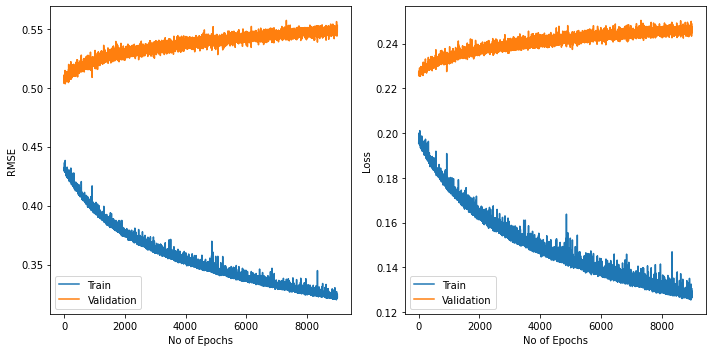

In [89]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('RMSE')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.tight_layout()

In [97]:
model = UNet()
checkpoint_path = "training_UNet_2/cp.ckpt"
model.load_weights(checkpoint_path)

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(40, 300, 300, 1)]  0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(40, 300, 300, 1)]  0                                            
__________________________________________________________________________________________________
concatenate_53 (Concatenate)    (40, 300, 300, 2)    0           input_37[0][0]                   
                                                                 input_38[0][0]                   
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (40, 294, 294, 15)   1485        concatenate_53[0][0]          

In [98]:
checkpoint_path = "training_UNet_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(x = [trainInput1,trainInput2],
                     y= trainOutput,batch_size=40,epochs=5000,
                     validation_data=([valInput1,valInput2],valOutput),
                     validation_batch_size=40, callbacks=cp_callback)

Epoch 1/5000
7/7 [==============================] - ETA: 0s - loss: 0.1308 - root_mean_squared_error: 0.3249WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_test_batch_end` time: 0.1756s). Check your callbacks.

Epoch 00001: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 778ms/step - loss: 0.1308 - root_mean_squared_error: 0.3249 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5475
Epoch 2/5000
7/7 [==============================] - ETA: 0s - loss: 0.1278 - root_mean_squared_error: 0.3230
Epoch 00002: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 744ms/step - loss: 0.1278 - root_mean_squared_error: 0.3230 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5466
Epoch 3/5000
7/7 [==============================] - ETA: 0s - loss: 0.1266 - root_mean_squared_error: 0.3218
Epoch 00003: saving model to training_UNet_3\cp.ckpt
7/7 [==================

7/7 [==============================] - ETA: 0s - loss: 0.1299 - root_mean_squared_error: 0.3243
Epoch 00025: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 772ms/step - loss: 0.1299 - root_mean_squared_error: 0.3243 - val_loss: 0.2433 - val_root_mean_squared_error: 0.5428
Epoch 26/5000
7/7 [==============================] - ETA: 0s - loss: 0.1280 - root_mean_squared_error: 0.3231
Epoch 00026: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 771ms/step - loss: 0.1280 - root_mean_squared_error: 0.3231 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5488
Epoch 27/5000
7/7 [==============================] - ETA: 0s - loss: 0.1273 - root_mean_squared_error: 0.3226
Epoch 00027: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 772ms/step - loss: 0.1273 - root_mean_squared_error: 0.3226 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5475
Epoch 28/5000
7/7 [=============================

Epoch 51/5000
7/7 [==============================] - ETA: 0s - loss: 0.1281 - root_mean_squared_error: 0.3235
Epoch 00051: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 774ms/step - loss: 0.1281 - root_mean_squared_error: 0.3235 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5442
Epoch 52/5000
7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3213
Epoch 00052: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 776ms/step - loss: 0.1264 - root_mean_squared_error: 0.3213 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5490
Epoch 53/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3209
Epoch 00053: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 777ms/step - loss: 0.1261 - root_mean_squared_error: 0.3209 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5502
Epoch 54/5000
7/7 [===============

Epoch 77/5000
7/7 [==============================] - ETA: 0s - loss: 0.1277 - root_mean_squared_error: 0.3220
Epoch 00077: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1277 - root_mean_squared_error: 0.3220 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5523
Epoch 78/5000
7/7 [==============================] - ETA: 0s - loss: 0.1294 - root_mean_squared_error: 0.3242
Epoch 00078: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1294 - root_mean_squared_error: 0.3242 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5528
Epoch 79/5000
7/7 [==============================] - ETA: 0s - loss: 0.1297 - root_mean_squared_error: 0.3235
Epoch 00079: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1297 - root_mean_squared_error: 0.3235 - val_loss: 0.2452 - val_root_mean_squared_error: 0.5439
Epoch 80/5000
7/7 [===============

Epoch 103/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3202
Epoch 00103: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1261 - root_mean_squared_error: 0.3202 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5497
Epoch 104/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3220
Epoch 00104: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1261 - root_mean_squared_error: 0.3220 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5484
Epoch 105/5000
7/7 [==============================] - ETA: 0s - loss: 0.1272 - root_mean_squared_error: 0.3223
Epoch 00105: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1272 - root_mean_squared_error: 0.3223 - val_loss: 0.2455 - val_root_mean_squared_error: 0.5468
Epoch 106/5000
7/7 [===========

Epoch 129/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3211
Epoch 00129: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1256 - root_mean_squared_error: 0.3211 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5503
Epoch 130/5000
7/7 [==============================] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.3205
Epoch 00130: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1253 - root_mean_squared_error: 0.3205 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5503
Epoch 131/5000
7/7 [==============================] - ETA: 0s - loss: 0.1262 - root_mean_squared_error: 0.3206
Epoch 00131: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1262 - root_mean_squared_error: 0.3206 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5503
Epoch 132/5000
7/7 [===========

Epoch 155/5000
7/7 [==============================] - ETA: 0s - loss: 0.1274 - root_mean_squared_error: 0.3210
Epoch 00155: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1274 - root_mean_squared_error: 0.3210 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5487
Epoch 156/5000
7/7 [==============================] - ETA: 0s - loss: 0.1293 - root_mean_squared_error: 0.3242
Epoch 00156: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1293 - root_mean_squared_error: 0.3242 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5504
Epoch 157/5000
7/7 [==============================] - ETA: 0s - loss: 0.1296 - root_mean_squared_error: 0.3237
Epoch 00157: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1296 - root_mean_squared_error: 0.3237 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5464
Epoch 158/5000
7/7 [===========

Epoch 181/5000
7/7 [==============================] - ETA: 0s - loss: 0.1321 - root_mean_squared_error: 0.3264
Epoch 00181: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1321 - root_mean_squared_error: 0.3264 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5472
Epoch 182/5000
7/7 [==============================] - ETA: 0s - loss: 0.1307 - root_mean_squared_error: 0.3262
Epoch 00182: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1307 - root_mean_squared_error: 0.3262 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5474
Epoch 183/5000
7/7 [==============================] - ETA: 0s - loss: 0.1295 - root_mean_squared_error: 0.3234
Epoch 00183: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1295 - root_mean_squared_error: 0.3234 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5478
Epoch 184/5000
7/7 [===========

Epoch 207/5000
7/7 [==============================] - ETA: 0s - loss: 0.1309 - root_mean_squared_error: 0.3265
Epoch 00207: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1309 - root_mean_squared_error: 0.3265 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5519
Epoch 208/5000
7/7 [==============================] - ETA: 0s - loss: 0.1307 - root_mean_squared_error: 0.3246
Epoch 00208: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1307 - root_mean_squared_error: 0.3246 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5472
Epoch 209/5000
7/7 [==============================] - ETA: 0s - loss: 0.1276 - root_mean_squared_error: 0.3224
Epoch 00209: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 797ms/step - loss: 0.1276 - root_mean_squared_error: 0.3224 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5507
Epoch 210/5000
7/7 [===========

Epoch 233/5000
7/7 [==============================] - ETA: 0s - loss: 0.1260 - root_mean_squared_error: 0.3203
Epoch 00233: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 819ms/step - loss: 0.1260 - root_mean_squared_error: 0.3203 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5514
Epoch 234/5000
7/7 [==============================] - ETA: 0s - loss: 0.1265 - root_mean_squared_error: 0.3217
Epoch 00234: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 798ms/step - loss: 0.1265 - root_mean_squared_error: 0.3217 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5461
Epoch 235/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3197
Epoch 00235: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 807ms/step - loss: 0.1251 - root_mean_squared_error: 0.3197 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5522
Epoch 236/5000
7/7 [===========

Epoch 259/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3205
Epoch 00259: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1256 - root_mean_squared_error: 0.3205 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5482
Epoch 260/5000
7/7 [==============================] - ETA: 0s - loss: 0.1254 - root_mean_squared_error: 0.3205
Epoch 00260: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1254 - root_mean_squared_error: 0.3205 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5451
Epoch 261/5000
7/7 [==============================] - ETA: 0s - loss: 0.1252 - root_mean_squared_error: 0.3205
Epoch 00261: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1252 - root_mean_squared_error: 0.3205 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5492
Epoch 262/5000
7/7 [===========

Epoch 285/5000
7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3188
Epoch 00285: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1245 - root_mean_squared_error: 0.3188 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5494
Epoch 286/5000
7/7 [==============================] - ETA: 0s - loss: 0.1247 - root_mean_squared_error: 0.3202
Epoch 00286: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1247 - root_mean_squared_error: 0.3202 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5498
Epoch 287/5000
7/7 [==============================] - ETA: 0s - loss: 0.1248 - root_mean_squared_error: 0.3193
Epoch 00287: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1248 - root_mean_squared_error: 0.3193 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5500
Epoch 288/5000
7/7 [===========

Epoch 311/5000
7/7 [==============================] - ETA: 0s - loss: 0.1252 - root_mean_squared_error: 0.3197
Epoch 00311: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1252 - root_mean_squared_error: 0.3197 - val_loss: 0.2455 - val_root_mean_squared_error: 0.5476
Epoch 312/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3205
Epoch 00312: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1251 - root_mean_squared_error: 0.3205 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5480
Epoch 313/5000
7/7 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3188
Epoch 00313: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1241 - root_mean_squared_error: 0.3188 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5484
Epoch 314/5000
7/7 [===========

Epoch 337/5000
7/7 [==============================] - ETA: 0s - loss: 0.1289 - root_mean_squared_error: 0.3237
Epoch 00337: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 802ms/step - loss: 0.1289 - root_mean_squared_error: 0.3237 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5476
Epoch 338/5000
7/7 [==============================] - ETA: 0s - loss: 0.1272 - root_mean_squared_error: 0.3214
Epoch 00338: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 808ms/step - loss: 0.1272 - root_mean_squared_error: 0.3214 - val_loss: 0.2493 - val_root_mean_squared_error: 0.5532
Epoch 339/5000
7/7 [==============================] - ETA: 0s - loss: 0.1274 - root_mean_squared_error: 0.3216
Epoch 00339: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 799ms/step - loss: 0.1274 - root_mean_squared_error: 0.3216 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5511
Epoch 340/5000
7/7 [===========

Epoch 363/5000
7/7 [==============================] - ETA: 0s - loss: 0.1283 - root_mean_squared_error: 0.3219
Epoch 00363: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 804ms/step - loss: 0.1283 - root_mean_squared_error: 0.3219 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5513
Epoch 364/5000
7/7 [==============================] - ETA: 0s - loss: 0.1284 - root_mean_squared_error: 0.3236
Epoch 00364: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1284 - root_mean_squared_error: 0.3236 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5476
Epoch 365/5000
7/7 [==============================] - ETA: 0s - loss: 0.1270 - root_mean_squared_error: 0.3207
Epoch 00365: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 797ms/step - loss: 0.1270 - root_mean_squared_error: 0.3207 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5517
Epoch 366/5000
7/7 [===========

Epoch 389/5000
7/7 [==============================] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.3196
Epoch 00389: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1253 - root_mean_squared_error: 0.3196 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5515
Epoch 390/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3194
Epoch 00390: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1251 - root_mean_squared_error: 0.3194 - val_loss: 0.2447 - val_root_mean_squared_error: 0.5476
Epoch 391/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3190
Epoch 00391: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1251 - root_mean_squared_error: 0.3190 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5500
Epoch 392/5000
7/7 [===========

Epoch 415/5000
7/7 [==============================] - ETA: 0s - loss: 0.1252 - root_mean_squared_error: 0.3192
Epoch 00415: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1252 - root_mean_squared_error: 0.3192 - val_loss: 0.2452 - val_root_mean_squared_error: 0.5464
Epoch 416/5000
7/7 [==============================] - ETA: 0s - loss: 0.1254 - root_mean_squared_error: 0.3194
Epoch 00416: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1254 - root_mean_squared_error: 0.3194 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5462
Epoch 417/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3212
Epoch 00417: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1256 - root_mean_squared_error: 0.3212 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5488
Epoch 418/5000
7/7 [===========

Epoch 441/5000
7/7 [==============================] - ETA: 0s - loss: 0.1271 - root_mean_squared_error: 0.3213
Epoch 00441: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1271 - root_mean_squared_error: 0.3213 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5504
Epoch 442/5000
7/7 [==============================] - ETA: 0s - loss: 0.1290 - root_mean_squared_error: 0.3228
Epoch 00442: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1290 - root_mean_squared_error: 0.3228 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5495
Epoch 443/5000
7/7 [==============================] - ETA: 0s - loss: 0.1288 - root_mean_squared_error: 0.3245
Epoch 00443: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1288 - root_mean_squared_error: 0.3245 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5470
Epoch 444/5000
7/7 [===========

Epoch 467/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3188
Epoch 00467: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1244 - root_mean_squared_error: 0.3188 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5508
Epoch 468/5000
7/7 [==============================] - ETA: 0s - loss: 0.1260 - root_mean_squared_error: 0.3202
Epoch 00468: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1260 - root_mean_squared_error: 0.3202 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5487
Epoch 469/5000
7/7 [==============================] - ETA: 0s - loss: 0.1255 - root_mean_squared_error: 0.3202
Epoch 00469: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1255 - root_mean_squared_error: 0.3202 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5468
Epoch 470/5000
7/7 [===========

Epoch 493/5000
7/7 [==============================] - ETA: 0s - loss: 0.1248 - root_mean_squared_error: 0.3201
Epoch 00493: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1248 - root_mean_squared_error: 0.3201 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5476
Epoch 494/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3187
Epoch 00494: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1244 - root_mean_squared_error: 0.3187 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5497
Epoch 495/5000
7/7 [==============================] - ETA: 0s - loss: 0.1249 - root_mean_squared_error: 0.3192
Epoch 00495: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1249 - root_mean_squared_error: 0.3192 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5488
Epoch 496/5000
7/7 [===========

Epoch 519/5000
7/7 [==============================] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.3199
Epoch 00519: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1258 - root_mean_squared_error: 0.3199 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5489
Epoch 520/5000
7/7 [==============================] - ETA: 0s - loss: 0.1257 - root_mean_squared_error: 0.3195
Epoch 00520: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1257 - root_mean_squared_error: 0.3195 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5520
Epoch 521/5000
7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3215
Epoch 00521: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1264 - root_mean_squared_error: 0.3215 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5496
Epoch 522/5000
7/7 [===========

Epoch 545/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3205
Epoch 00545: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1261 - root_mean_squared_error: 0.3205 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5532
Epoch 546/5000
7/7 [==============================] - ETA: 0s - loss: 0.1274 - root_mean_squared_error: 0.3222
Epoch 00546: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1274 - root_mean_squared_error: 0.3222 - val_loss: 0.2456 - val_root_mean_squared_error: 0.5495
Epoch 547/5000
7/7 [==============================] - ETA: 0s - loss: 0.1283 - root_mean_squared_error: 0.3229
Epoch 00547: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1283 - root_mean_squared_error: 0.3229 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5485
Epoch 548/5000
7/7 [===========

Epoch 571/5000
7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3184
Epoch 00571: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1245 - root_mean_squared_error: 0.3184 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5507
Epoch 572/5000
7/7 [==============================] - ETA: 0s - loss: 0.1252 - root_mean_squared_error: 0.3185
Epoch 00572: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1252 - root_mean_squared_error: 0.3185 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5516
Epoch 573/5000
7/7 [==============================] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.3206
Epoch 00573: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1253 - root_mean_squared_error: 0.3206 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5492
Epoch 574/5000
7/7 [===========

Epoch 597/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3208
Epoch 00597: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1256 - root_mean_squared_error: 0.3208 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5473
Epoch 598/5000
7/7 [==============================] - ETA: 0s - loss: 0.1250 - root_mean_squared_error: 0.3180
Epoch 00598: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1250 - root_mean_squared_error: 0.3180 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5540
Epoch 599/5000
7/7 [==============================] - ETA: 0s - loss: 0.1262 - root_mean_squared_error: 0.3207
Epoch 00599: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1262 - root_mean_squared_error: 0.3207 - val_loss: 0.2458 - val_root_mean_squared_error: 0.5469
Epoch 600/5000
7/7 [===========

Epoch 623/5000
7/7 [==============================] - ETA: 0s - loss: 0.1276 - root_mean_squared_error: 0.3223
Epoch 00623: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1276 - root_mean_squared_error: 0.3223 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5487
Epoch 624/5000
7/7 [==============================] - ETA: 0s - loss: 0.1266 - root_mean_squared_error: 0.3217
Epoch 00624: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1266 - root_mean_squared_error: 0.3217 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5492
Epoch 625/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3201
Epoch 00625: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1256 - root_mean_squared_error: 0.3201 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5504
Epoch 626/5000
7/7 [===========

Epoch 649/5000
7/7 [==============================] - ETA: 0s - loss: 0.1298 - root_mean_squared_error: 0.3226
Epoch 00649: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1298 - root_mean_squared_error: 0.3226 - val_loss: 0.2500 - val_root_mean_squared_error: 0.5554
Epoch 650/5000
7/7 [==============================] - ETA: 0s - loss: 0.1305 - root_mean_squared_error: 0.3236
Epoch 00650: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1305 - root_mean_squared_error: 0.3236 - val_loss: 0.2441 - val_root_mean_squared_error: 0.5453
Epoch 651/5000
7/7 [==============================] - ETA: 0s - loss: 0.1300 - root_mean_squared_error: 0.3245
Epoch 00651: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1300 - root_mean_squared_error: 0.3245 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5499
Epoch 652/5000
7/7 [===========

Epoch 675/5000
7/7 [==============================] - ETA: 0s - loss: 0.1238 - root_mean_squared_error: 0.3175
Epoch 00675: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1238 - root_mean_squared_error: 0.3175 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5509
Epoch 676/5000
7/7 [==============================] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3176
Epoch 00676: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1237 - root_mean_squared_error: 0.3176 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5504
Epoch 677/5000
7/7 [==============================] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.3192
Epoch 00677: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1253 - root_mean_squared_error: 0.3192 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5492
Epoch 678/5000
7/7 [===========

Epoch 701/5000
7/7 [==============================] - ETA: 0s - loss: 0.1257 - root_mean_squared_error: 0.3193
Epoch 00701: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1257 - root_mean_squared_error: 0.3193 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5492
Epoch 702/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3212
Epoch 00702: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1261 - root_mean_squared_error: 0.3212 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5458
Epoch 703/5000
7/7 [==============================] - ETA: 0s - loss: 0.1259 - root_mean_squared_error: 0.3195
Epoch 00703: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1259 - root_mean_squared_error: 0.3195 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5485
Epoch 704/5000
7/7 [===========

Epoch 727/5000
7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3199
Epoch 00727: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 814ms/step - loss: 0.1245 - root_mean_squared_error: 0.3199 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5510
Epoch 728/5000
7/7 [==============================] - ETA: 0s - loss: 0.1266 - root_mean_squared_error: 0.3209
Epoch 00728: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 820ms/step - loss: 0.1266 - root_mean_squared_error: 0.3209 - val_loss: 0.2448 - val_root_mean_squared_error: 0.5469
Epoch 729/5000
7/7 [==============================] - ETA: 0s - loss: 0.1263 - root_mean_squared_error: 0.3202
Epoch 00729: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 807ms/step - loss: 0.1263 - root_mean_squared_error: 0.3202 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5498
Epoch 730/5000
7/7 [===========

Epoch 753/5000
7/7 [==============================] - ETA: 0s - loss: 0.1257 - root_mean_squared_error: 0.3210
Epoch 00753: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 813ms/step - loss: 0.1257 - root_mean_squared_error: 0.3210 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5478
Epoch 754/5000
7/7 [==============================] - ETA: 0s - loss: 0.1255 - root_mean_squared_error: 0.3194
Epoch 00754: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 815ms/step - loss: 0.1255 - root_mean_squared_error: 0.3194 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5516
Epoch 755/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3188
Epoch 00755: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 818ms/step - loss: 0.1251 - root_mean_squared_error: 0.3188 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5489
Epoch 756/5000
7/7 [===========

Epoch 779/5000
7/7 [==============================] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.3196
Epoch 00779: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 819ms/step - loss: 0.1258 - root_mean_squared_error: 0.3196 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5501
Epoch 780/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3204
Epoch 00780: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 802ms/step - loss: 0.1256 - root_mean_squared_error: 0.3204 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5480
Epoch 781/5000
7/7 [==============================] - ETA: 0s - loss: 0.1267 - root_mean_squared_error: 0.3211
Epoch 00781: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1267 - root_mean_squared_error: 0.3211 - val_loss: 0.2440 - val_root_mean_squared_error: 0.5453
Epoch 782/5000
7/7 [===========

Epoch 805/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3192
Epoch 00805: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 831ms/step - loss: 0.1256 - root_mean_squared_error: 0.3192 - val_loss: 0.2456 - val_root_mean_squared_error: 0.5480
Epoch 806/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3189
Epoch 00806: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 812ms/step - loss: 0.1261 - root_mean_squared_error: 0.3189 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5501
Epoch 807/5000
7/7 [==============================] - ETA: 0s - loss: 0.1270 - root_mean_squared_error: 0.3214
Epoch 00807: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 819ms/step - loss: 0.1270 - root_mean_squared_error: 0.3214 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5490
Epoch 808/5000
7/7 [===========

Epoch 831/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3191
Epoch 00831: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 833ms/step - loss: 0.1256 - root_mean_squared_error: 0.3191 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5499
Epoch 832/5000
7/7 [==============================] - ETA: 0s - loss: 0.1262 - root_mean_squared_error: 0.3204
Epoch 00832: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 838ms/step - loss: 0.1262 - root_mean_squared_error: 0.3204 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5503
Epoch 833/5000
7/7 [==============================] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.3207
Epoch 00833: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 832ms/step - loss: 0.1258 - root_mean_squared_error: 0.3207 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5494
Epoch 834/5000
7/7 [===========

Epoch 857/5000
7/7 [==============================] - ETA: 0s - loss: 0.1248 - root_mean_squared_error: 0.3187
Epoch 00857: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 813ms/step - loss: 0.1248 - root_mean_squared_error: 0.3187 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5485
Epoch 858/5000
7/7 [==============================] - ETA: 0s - loss: 0.1235 - root_mean_squared_error: 0.3176
Epoch 00858: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 818ms/step - loss: 0.1235 - root_mean_squared_error: 0.3176 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5518
Epoch 859/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3200
Epoch 00859: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 799ms/step - loss: 0.1244 - root_mean_squared_error: 0.3200 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5500
Epoch 860/5000
7/7 [===========

Epoch 883/5000
7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3179
Epoch 00883: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 799ms/step - loss: 0.1245 - root_mean_squared_error: 0.3179 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5494
Epoch 884/5000
7/7 [==============================] - ETA: 0s - loss: 0.1255 - root_mean_squared_error: 0.3200
Epoch 00884: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 811ms/step - loss: 0.1255 - root_mean_squared_error: 0.3200 - val_loss: 0.2458 - val_root_mean_squared_error: 0.5494
Epoch 885/5000
7/7 [==============================] - ETA: 0s - loss: 0.1277 - root_mean_squared_error: 0.3217
Epoch 00885: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 819ms/step - loss: 0.1277 - root_mean_squared_error: 0.3217 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5483
Epoch 886/5000
7/7 [===========

Epoch 909/5000
7/7 [==============================] - ETA: 0s - loss: 0.1242 - root_mean_squared_error: 0.3179
Epoch 00909: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 805ms/step - loss: 0.1242 - root_mean_squared_error: 0.3179 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5485
Epoch 910/5000
7/7 [==============================] - ETA: 0s - loss: 0.1248 - root_mean_squared_error: 0.3186
Epoch 00910: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 802ms/step - loss: 0.1248 - root_mean_squared_error: 0.3186 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5524
Epoch 911/5000
7/7 [==============================] - ETA: 0s - loss: 0.1274 - root_mean_squared_error: 0.3210
Epoch 00911: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 803ms/step - loss: 0.1274 - root_mean_squared_error: 0.3210 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5532
Epoch 912/5000
7/7 [===========

Epoch 935/5000
7/7 [==============================] - ETA: 0s - loss: 0.1243 - root_mean_squared_error: 0.3184
Epoch 00935: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 800ms/step - loss: 0.1243 - root_mean_squared_error: 0.3184 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5512
Epoch 936/5000
7/7 [==============================] - ETA: 0s - loss: 0.1236 - root_mean_squared_error: 0.3166
Epoch 00936: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1236 - root_mean_squared_error: 0.3166 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5497
Epoch 937/5000
7/7 [==============================] - ETA: 0s - loss: 0.1257 - root_mean_squared_error: 0.3203
Epoch 00937: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 803ms/step - loss: 0.1257 - root_mean_squared_error: 0.3203 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5514
Epoch 938/5000
7/7 [===========

Epoch 961/5000
7/7 [==============================] - ETA: 0s - loss: 0.1247 - root_mean_squared_error: 0.3177
Epoch 00961: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 817ms/step - loss: 0.1247 - root_mean_squared_error: 0.3177 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5502
Epoch 962/5000
7/7 [==============================] - ETA: 0s - loss: 0.1256 - root_mean_squared_error: 0.3205
Epoch 00962: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 803ms/step - loss: 0.1256 - root_mean_squared_error: 0.3205 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5487
Epoch 963/5000
7/7 [==============================] - ETA: 0s - loss: 0.1263 - root_mean_squared_error: 0.3192
Epoch 00963: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1263 - root_mean_squared_error: 0.3192 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5481
Epoch 964/5000
7/7 [===========

Epoch 987/5000
7/7 [==============================] - ETA: 0s - loss: 0.1234 - root_mean_squared_error: 0.3170
Epoch 00987: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 814ms/step - loss: 0.1234 - root_mean_squared_error: 0.3170 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5493
Epoch 988/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3175
Epoch 00988: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1239 - root_mean_squared_error: 0.3175 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5482
Epoch 989/5000
7/7 [==============================] - ETA: 0s - loss: 0.1249 - root_mean_squared_error: 0.3190
Epoch 00989: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 799ms/step - loss: 0.1249 - root_mean_squared_error: 0.3190 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5521
Epoch 990/5000
7/7 [===========

7/7 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3191
Epoch 01012: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 803ms/step - loss: 0.1241 - root_mean_squared_error: 0.3191 - val_loss: 0.2451 - val_root_mean_squared_error: 0.5465
Epoch 1013/5000
7/7 [==============================] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3177
Epoch 01013: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 802ms/step - loss: 0.1232 - root_mean_squared_error: 0.3177 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5515
Epoch 1014/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3172
Epoch 01014: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 800ms/step - loss: 0.1239 - root_mean_squared_error: 0.3172 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5499
Epoch 1015/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3168
Epoch 01037: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 803ms/step - loss: 0.1232 - root_mean_squared_error: 0.3168 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5532
Epoch 1038/5000
7/7 [==============================] - ETA: 0s - loss: 0.1262 - root_mean_squared_error: 0.3189
Epoch 01038: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 800ms/step - loss: 0.1262 - root_mean_squared_error: 0.3189 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5471
Epoch 1039/5000
7/7 [==============================] - ETA: 0s - loss: 0.1243 - root_mean_squared_error: 0.3180
Epoch 01039: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 812ms/step - loss: 0.1243 - root_mean_squared_error: 0.3180 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5496
Epoch 1040/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3180
Epoch 01062: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 824ms/step - loss: 0.1245 - root_mean_squared_error: 0.3180 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5500
Epoch 1063/5000
7/7 [==============================] - ETA: 0s - loss: 0.1238 - root_mean_squared_error: 0.3166
Epoch 01063: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 797ms/step - loss: 0.1238 - root_mean_squared_error: 0.3166 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5514
Epoch 1064/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3189
Epoch 01064: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 809ms/step - loss: 0.1244 - root_mean_squared_error: 0.3189 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5506
Epoch 1065/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1252 - root_mean_squared_error: 0.3188
Epoch 01087: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 797ms/step - loss: 0.1252 - root_mean_squared_error: 0.3188 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5507
Epoch 1088/5000
7/7 [==============================] - ETA: 0s - loss: 0.1269 - root_mean_squared_error: 0.3202
Epoch 01088: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 800ms/step - loss: 0.1269 - root_mean_squared_error: 0.3202 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5494
Epoch 1089/5000
7/7 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3171
Epoch 01089: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 800ms/step - loss: 0.1241 - root_mean_squared_error: 0.3171 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5534
Epoch 1090/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1287 - root_mean_squared_error: 0.3232
Epoch 01112: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1287 - root_mean_squared_error: 0.3232 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5514
Epoch 1113/5000
7/7 [==============================] - ETA: 0s - loss: 0.1265 - root_mean_squared_error: 0.3198
Epoch 01113: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1265 - root_mean_squared_error: 0.3198 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5504
Epoch 1114/5000
7/7 [==============================] - ETA: 0s - loss: 0.1260 - root_mean_squared_error: 0.3191
Epoch 01114: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1260 - root_mean_squared_error: 0.3191 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5490
Epoch 1115/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1234 - root_mean_squared_error: 0.3168
Epoch 01137: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 797ms/step - loss: 0.1234 - root_mean_squared_error: 0.3168 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5518
Epoch 1138/5000
7/7 [==============================] - ETA: 0s - loss: 0.1254 - root_mean_squared_error: 0.3184
Epoch 01138: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 797ms/step - loss: 0.1254 - root_mean_squared_error: 0.3184 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5484
Epoch 1139/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3186
Epoch 01139: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1244 - root_mean_squared_error: 0.3186 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5485
Epoch 1140/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1227 - root_mean_squared_error: 0.3153
Epoch 01162: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1227 - root_mean_squared_error: 0.3153 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5494
Epoch 1163/5000
7/7 [==============================] - ETA: 0s - loss: 0.1226 - root_mean_squared_error: 0.3167
Epoch 01163: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1226 - root_mean_squared_error: 0.3167 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5519
Epoch 1164/5000
7/7 [==============================] - ETA: 0s - loss: 0.1223 - root_mean_squared_error: 0.3158
Epoch 01164: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1223 - root_mean_squared_error: 0.3158 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5514
Epoch 1165/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1310 - root_mean_squared_error: 0.3233
Epoch 01187: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 804ms/step - loss: 0.1310 - root_mean_squared_error: 0.3233 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5522
Epoch 1188/5000
7/7 [==============================] - ETA: 0s - loss: 0.1275 - root_mean_squared_error: 0.3217
Epoch 01188: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1275 - root_mean_squared_error: 0.3217 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5500
Epoch 1189/5000
7/7 [==============================] - ETA: 0s - loss: 0.1246 - root_mean_squared_error: 0.3176
Epoch 01189: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1246 - root_mean_squared_error: 0.3176 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5498
Epoch 1190/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1312 - root_mean_squared_error: 0.3253
Epoch 01212: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 797ms/step - loss: 0.1312 - root_mean_squared_error: 0.3253 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5479
Epoch 1213/5000
7/7 [==============================] - ETA: 0s - loss: 0.1285 - root_mean_squared_error: 0.3212
Epoch 01213: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 799ms/step - loss: 0.1285 - root_mean_squared_error: 0.3212 - val_loss: 0.2539 - val_root_mean_squared_error: 0.5615
Epoch 1214/5000
7/7 [==============================] - ETA: 0s - loss: 0.1302 - root_mean_squared_error: 0.3240
Epoch 01214: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1302 - root_mean_squared_error: 0.3240 - val_loss: 0.2497 - val_root_mean_squared_error: 0.5532
Epoch 1215/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3173
Epoch 01237: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 804ms/step - loss: 0.1239 - root_mean_squared_error: 0.3173 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5531
Epoch 1238/5000
7/7 [==============================] - ETA: 0s - loss: 0.1230 - root_mean_squared_error: 0.3164
Epoch 01238: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1230 - root_mean_squared_error: 0.3164 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5481
Epoch 1239/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3168
Epoch 01239: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1239 - root_mean_squared_error: 0.3168 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5476
Epoch 1240/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3168
Epoch 01262: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1232 - root_mean_squared_error: 0.3168 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5487
Epoch 1263/5000
7/7 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3159
Epoch 01263: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1241 - root_mean_squared_error: 0.3159 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5497
Epoch 1264/5000
7/7 [==============================] - ETA: 0s - loss: 0.1257 - root_mean_squared_error: 0.3188
Epoch 01264: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 812ms/step - loss: 0.1257 - root_mean_squared_error: 0.3188 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5483
Epoch 1265/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1219 - root_mean_squared_error: 0.3153
Epoch 01287: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1219 - root_mean_squared_error: 0.3153 - val_loss: 0.2456 - val_root_mean_squared_error: 0.5481
Epoch 1288/5000
7/7 [==============================] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.3167
Epoch 01288: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1215 - root_mean_squared_error: 0.3167 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5497
Epoch 1289/5000
7/7 [==============================] - ETA: 0s - loss: 0.1227 - root_mean_squared_error: 0.3151
Epoch 01289: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1227 - root_mean_squared_error: 0.3151 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5508
Epoch 1290/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1272 - root_mean_squared_error: 0.3199
Epoch 01312: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 802ms/step - loss: 0.1272 - root_mean_squared_error: 0.3199 - val_loss: 0.2445 - val_root_mean_squared_error: 0.5458
Epoch 1313/5000
7/7 [==============================] - ETA: 0s - loss: 0.1268 - root_mean_squared_error: 0.3211
Epoch 01313: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1268 - root_mean_squared_error: 0.3211 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5539
Epoch 1314/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3172
Epoch 01314: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1239 - root_mean_squared_error: 0.3172 - val_loss: 0.2453 - val_root_mean_squared_error: 0.5479
Epoch 1315/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1240 - root_mean_squared_error: 0.3169
Epoch 01337: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1240 - root_mean_squared_error: 0.3169 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5506
Epoch 1338/5000
7/7 [==============================] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3169
Epoch 01338: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1233 - root_mean_squared_error: 0.3169 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5510
Epoch 1339/5000
7/7 [==============================] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3166
Epoch 01339: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1232 - root_mean_squared_error: 0.3166 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5517
Epoch 1340/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3166
Epoch 01362: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1232 - root_mean_squared_error: 0.3166 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5529
Epoch 1363/5000
7/7 [==============================] - ETA: 0s - loss: 0.1254 - root_mean_squared_error: 0.3190
Epoch 01363: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1254 - root_mean_squared_error: 0.3190 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5507
Epoch 1364/5000
7/7 [==============================] - ETA: 0s - loss: 0.1268 - root_mean_squared_error: 0.3198
Epoch 01364: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1268 - root_mean_squared_error: 0.3198 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5495
Epoch 1365/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1243 - root_mean_squared_error: 0.3172
Epoch 01387: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1243 - root_mean_squared_error: 0.3172 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5494
Epoch 1388/5000
7/7 [==============================] - ETA: 0s - loss: 0.1234 - root_mean_squared_error: 0.3165
Epoch 01388: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1234 - root_mean_squared_error: 0.3165 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5528
Epoch 1389/5000
7/7 [==============================] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.3155
Epoch 01389: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1228 - root_mean_squared_error: 0.3155 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5493
Epoch 1390/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3161
Epoch 01412: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1237 - root_mean_squared_error: 0.3161 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5528
Epoch 1413/5000
7/7 [==============================] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3170
Epoch 01413: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1233 - root_mean_squared_error: 0.3170 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5510
Epoch 1414/5000
7/7 [==============================] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3178
Epoch 01414: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1237 - root_mean_squared_error: 0.3178 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5502
Epoch 1415/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1230 - root_mean_squared_error: 0.3165
Epoch 01437: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1230 - root_mean_squared_error: 0.3165 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5524
Epoch 1438/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3171
Epoch 01438: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1251 - root_mean_squared_error: 0.3171 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5493
Epoch 1439/5000
7/7 [==============================] - ETA: 0s - loss: 0.1248 - root_mean_squared_error: 0.3184
Epoch 01439: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1248 - root_mean_squared_error: 0.3184 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5526
Epoch 1440/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1238 - root_mean_squared_error: 0.3179
Epoch 01462: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1238 - root_mean_squared_error: 0.3179 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5503
Epoch 1463/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3186
Epoch 01463: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1251 - root_mean_squared_error: 0.3186 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5464
Epoch 1464/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3184
Epoch 01464: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1261 - root_mean_squared_error: 0.3184 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5498
Epoch 1465/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1217 - root_mean_squared_error: 0.3141
Epoch 01487: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1217 - root_mean_squared_error: 0.3141 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5528
Epoch 1488/5000
7/7 [==============================] - ETA: 0s - loss: 0.1219 - root_mean_squared_error: 0.3150
Epoch 01488: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1219 - root_mean_squared_error: 0.3150 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5495
Epoch 1489/5000
7/7 [==============================] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3166
Epoch 01489: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 798ms/step - loss: 0.1232 - root_mean_squared_error: 0.3166 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5531
Epoch 1490/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1255 - root_mean_squared_error: 0.3188
Epoch 01512: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 801ms/step - loss: 0.1255 - root_mean_squared_error: 0.3188 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5510
Epoch 1513/5000
7/7 [==============================] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3156
Epoch 01513: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 801ms/step - loss: 0.1229 - root_mean_squared_error: 0.3156 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5496
Epoch 1514/5000
7/7 [==============================] - ETA: 0s - loss: 0.1225 - root_mean_squared_error: 0.3153
Epoch 01514: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1225 - root_mean_squared_error: 0.3153 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5504
Epoch 1515/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1232 - root_mean_squared_error: 0.3165
Epoch 01537: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 804ms/step - loss: 0.1232 - root_mean_squared_error: 0.3165 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5493
Epoch 1538/5000
7/7 [==============================] - ETA: 0s - loss: 0.1226 - root_mean_squared_error: 0.3156
Epoch 01538: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1226 - root_mean_squared_error: 0.3156 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5494
Epoch 1539/5000
7/7 [==============================] - ETA: 0s - loss: 0.1231 - root_mean_squared_error: 0.3164
Epoch 01539: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1231 - root_mean_squared_error: 0.3164 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5481
Epoch 1540/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3193
Epoch 01562: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1264 - root_mean_squared_error: 0.3193 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5504
Epoch 1563/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3172
Epoch 01563: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1251 - root_mean_squared_error: 0.3172 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5512
Epoch 1564/5000
7/7 [==============================] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3159
Epoch 01564: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1229 - root_mean_squared_error: 0.3159 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5537
Epoch 1565/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3187
Epoch 01587: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1264 - root_mean_squared_error: 0.3187 - val_loss: 0.2452 - val_root_mean_squared_error: 0.5466
Epoch 1588/5000
7/7 [==============================] - ETA: 0s - loss: 0.1272 - root_mean_squared_error: 0.3215
Epoch 01588: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 801ms/step - loss: 0.1272 - root_mean_squared_error: 0.3215 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5499
Epoch 1589/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3191
Epoch 01589: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1261 - root_mean_squared_error: 0.3191 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5521
Epoch 1590/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1231 - root_mean_squared_error: 0.3157
Epoch 01612: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1231 - root_mean_squared_error: 0.3157 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5519
Epoch 1613/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3159
Epoch 01613: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1239 - root_mean_squared_error: 0.3159 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5507
Epoch 1614/5000
7/7 [==============================] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3161
Epoch 01614: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1229 - root_mean_squared_error: 0.3161 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5489
Epoch 1615/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3172
Epoch 01637: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1245 - root_mean_squared_error: 0.3172 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5488
Epoch 1638/5000
7/7 [==============================] - ETA: 0s - loss: 0.1292 - root_mean_squared_error: 0.3232
Epoch 01638: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1292 - root_mean_squared_error: 0.3232 - val_loss: 0.2509 - val_root_mean_squared_error: 0.5572
Epoch 1639/5000
7/7 [==============================] - ETA: 0s - loss: 0.1318 - root_mean_squared_error: 0.3236
Epoch 01639: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1318 - root_mean_squared_error: 0.3236 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5553
Epoch 1640/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1242 - root_mean_squared_error: 0.3168
Epoch 01662: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1242 - root_mean_squared_error: 0.3168 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5494
Epoch 1663/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3168
Epoch 01663: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1239 - root_mean_squared_error: 0.3168 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5509
Epoch 1664/5000
7/7 [==============================] - ETA: 0s - loss: 0.1223 - root_mean_squared_error: 0.3140
Epoch 01664: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1223 - root_mean_squared_error: 0.3140 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5485
Epoch 1665/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1275 - root_mean_squared_error: 0.3197
Epoch 01687: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1275 - root_mean_squared_error: 0.3197 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5491
Epoch 1688/5000
7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3202
Epoch 01688: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1264 - root_mean_squared_error: 0.3202 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5492
Epoch 1689/5000
7/7 [==============================] - ETA: 0s - loss: 0.1248 - root_mean_squared_error: 0.3171
Epoch 01689: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1248 - root_mean_squared_error: 0.3171 - val_loss: 0.2498 - val_root_mean_squared_error: 0.5549
Epoch 1690/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1210 - root_mean_squared_error: 0.3138
Epoch 01712: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1210 - root_mean_squared_error: 0.3138 - val_loss: 0.2458 - val_root_mean_squared_error: 0.5477
Epoch 1713/5000
7/7 [==============================] - ETA: 0s - loss: 0.1208 - root_mean_squared_error: 0.3137
Epoch 01713: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1208 - root_mean_squared_error: 0.3137 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5515
Epoch 1714/5000
7/7 [==============================] - ETA: 0s - loss: 0.1209 - root_mean_squared_error: 0.3142
Epoch 01714: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1209 - root_mean_squared_error: 0.3142 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5505
Epoch 1715/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3185
Epoch 01737: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1264 - root_mean_squared_error: 0.3185 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5500
Epoch 1738/5000
7/7 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3160
Epoch 01738: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1241 - root_mean_squared_error: 0.3160 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5474
Epoch 1739/5000
7/7 [==============================] - ETA: 0s - loss: 0.1220 - root_mean_squared_error: 0.3141
Epoch 01739: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1220 - root_mean_squared_error: 0.3141 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5490
Epoch 1740/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1247 - root_mean_squared_error: 0.3174
Epoch 01762: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1247 - root_mean_squared_error: 0.3174 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5495
Epoch 1763/5000
7/7 [==============================] - ETA: 0s - loss: 0.1243 - root_mean_squared_error: 0.3165
Epoch 01763: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1243 - root_mean_squared_error: 0.3165 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5531
Epoch 1764/5000
7/7 [==============================] - ETA: 0s - loss: 0.1260 - root_mean_squared_error: 0.3180
Epoch 01764: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1260 - root_mean_squared_error: 0.3180 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5490
Epoch 1765/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3162
Epoch 01787: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1237 - root_mean_squared_error: 0.3162 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5483
Epoch 1788/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3172
Epoch 01788: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1244 - root_mean_squared_error: 0.3172 - val_loss: 0.2494 - val_root_mean_squared_error: 0.5555
Epoch 1789/5000
7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3168
Epoch 01789: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 802ms/step - loss: 0.1245 - root_mean_squared_error: 0.3168 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5516
Epoch 1790/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3170
Epoch 01812: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1241 - root_mean_squared_error: 0.3170 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5491
Epoch 1813/5000
7/7 [==============================] - ETA: 0s - loss: 0.1227 - root_mean_squared_error: 0.3145
Epoch 01813: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1227 - root_mean_squared_error: 0.3145 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5505
Epoch 1814/5000
7/7 [==============================] - ETA: 0s - loss: 0.1225 - root_mean_squared_error: 0.3155
Epoch 01814: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1225 - root_mean_squared_error: 0.3155 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5505
Epoch 1815/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.3142
Epoch 01837: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1228 - root_mean_squared_error: 0.3142 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5487
Epoch 1838/5000
7/7 [==============================] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3162
Epoch 01838: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1233 - root_mean_squared_error: 0.3162 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5553
Epoch 1839/5000
7/7 [==============================] - ETA: 0s - loss: 0.1271 - root_mean_squared_error: 0.3198
Epoch 01839: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1271 - root_mean_squared_error: 0.3198 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5530
Epoch 1840/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.3151
Epoch 01862: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1228 - root_mean_squared_error: 0.3151 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5503
Epoch 1863/5000
7/7 [==============================] - ETA: 0s - loss: 0.1235 - root_mean_squared_error: 0.3161
Epoch 01863: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1235 - root_mean_squared_error: 0.3161 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5480
Epoch 1864/5000
7/7 [==============================] - ETA: 0s - loss: 0.1227 - root_mean_squared_error: 0.3147
Epoch 01864: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1227 - root_mean_squared_error: 0.3147 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5526
Epoch 1865/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.3159
Epoch 01887: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 798ms/step - loss: 0.1228 - root_mean_squared_error: 0.3159 - val_loss: 0.2459 - val_root_mean_squared_error: 0.5485
Epoch 1888/5000
7/7 [==============================] - ETA: 0s - loss: 0.1225 - root_mean_squared_error: 0.3153
Epoch 01888: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1225 - root_mean_squared_error: 0.3153 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5518
Epoch 1889/5000
7/7 [==============================] - ETA: 0s - loss: 0.1209 - root_mean_squared_error: 0.3138
Epoch 01889: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1209 - root_mean_squared_error: 0.3138 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5492
Epoch 1890/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1266 - root_mean_squared_error: 0.3178
Epoch 01912: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1266 - root_mean_squared_error: 0.3178 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5515
Epoch 1913/5000
7/7 [==============================] - ETA: 0s - loss: 0.1265 - root_mean_squared_error: 0.3209
Epoch 01913: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1265 - root_mean_squared_error: 0.3209 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5500
Epoch 1914/5000
7/7 [==============================] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.3177
Epoch 01914: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1253 - root_mean_squared_error: 0.3177 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5559
Epoch 1915/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1235 - root_mean_squared_error: 0.3166
Epoch 01937: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1235 - root_mean_squared_error: 0.3166 - val_loss: 0.2456 - val_root_mean_squared_error: 0.5491
Epoch 1938/5000
7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3186
Epoch 01938: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1251 - root_mean_squared_error: 0.3186 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5476
Epoch 1939/5000
7/7 [==============================] - ETA: 0s - loss: 0.1242 - root_mean_squared_error: 0.3165
Epoch 01939: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1242 - root_mean_squared_error: 0.3165 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5496
Epoch 1940/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1209 - root_mean_squared_error: 0.3139
Epoch 01962: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1209 - root_mean_squared_error: 0.3139 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5498
Epoch 1963/5000
7/7 [==============================] - ETA: 0s - loss: 0.1217 - root_mean_squared_error: 0.3136
Epoch 01963: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1217 - root_mean_squared_error: 0.3136 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5537
Epoch 1964/5000
7/7 [==============================] - ETA: 0s - loss: 0.1220 - root_mean_squared_error: 0.3148
Epoch 01964: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1220 - root_mean_squared_error: 0.3148 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5535
Epoch 1965/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1238 - root_mean_squared_error: 0.3158
Epoch 01987: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1238 - root_mean_squared_error: 0.3158 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5521
Epoch 1988/5000
7/7 [==============================] - ETA: 0s - loss: 0.1222 - root_mean_squared_error: 0.3155
Epoch 01988: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1222 - root_mean_squared_error: 0.3155 - val_loss: 0.2449 - val_root_mean_squared_error: 0.5481
Epoch 1989/5000
7/7 [==============================] - ETA: 0s - loss: 0.1264 - root_mean_squared_error: 0.3175
Epoch 01989: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1264 - root_mean_squared_error: 0.3175 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5473
Epoch 1990/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1212 - root_mean_squared_error: 0.3129
Epoch 02012: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1212 - root_mean_squared_error: 0.3129 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5529
Epoch 2013/5000
7/7 [==============================] - ETA: 0s - loss: 0.1204 - root_mean_squared_error: 0.3123
Epoch 02013: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1204 - root_mean_squared_error: 0.3123 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5540
Epoch 2014/5000
7/7 [==============================] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3153
Epoch 02014: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1237 - root_mean_squared_error: 0.3153 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5515
Epoch 2015/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1214 - root_mean_squared_error: 0.3127
Epoch 02037: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1214 - root_mean_squared_error: 0.3127 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5520
Epoch 2038/5000
7/7 [==============================] - ETA: 0s - loss: 0.1211 - root_mean_squared_error: 0.3132
Epoch 02038: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1211 - root_mean_squared_error: 0.3132 - val_loss: 0.2458 - val_root_mean_squared_error: 0.5479
Epoch 2039/5000
7/7 [==============================] - ETA: 0s - loss: 0.1223 - root_mean_squared_error: 0.3157
Epoch 02039: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1223 - root_mean_squared_error: 0.3157 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5491
Epoch 2040/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3179
Epoch 02062: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1251 - root_mean_squared_error: 0.3179 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5513
Epoch 2063/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3157
Epoch 02063: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1239 - root_mean_squared_error: 0.3157 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5523
Epoch 2064/5000
7/7 [==============================] - ETA: 0s - loss: 0.1240 - root_mean_squared_error: 0.3157
Epoch 02064: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1240 - root_mean_squared_error: 0.3157 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5514
Epoch 2065/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1214 - root_mean_squared_error: 0.3140
Epoch 02087: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1214 - root_mean_squared_error: 0.3140 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5516
Epoch 2088/5000
7/7 [==============================] - ETA: 0s - loss: 0.1217 - root_mean_squared_error: 0.3138
Epoch 02088: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1217 - root_mean_squared_error: 0.3138 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5503
Epoch 2089/5000
7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3147
Epoch 02089: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1213 - root_mean_squared_error: 0.3147 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5504
Epoch 2090/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.3149
Epoch 02112: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1228 - root_mean_squared_error: 0.3149 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5498
Epoch 2113/5000
7/7 [==============================] - ETA: 0s - loss: 0.1224 - root_mean_squared_error: 0.3147
Epoch 02113: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1224 - root_mean_squared_error: 0.3147 - val_loss: 0.2494 - val_root_mean_squared_error: 0.5547
Epoch 2114/5000
7/7 [==============================] - ETA: 0s - loss: 0.1216 - root_mean_squared_error: 0.3140
Epoch 02114: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1216 - root_mean_squared_error: 0.3140 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5512
Epoch 2115/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1278 - root_mean_squared_error: 0.3192
Epoch 02137: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1278 - root_mean_squared_error: 0.3192 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5526
Epoch 2138/5000
7/7 [==============================] - ETA: 0s - loss: 0.1290 - root_mean_squared_error: 0.3227
Epoch 02138: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1290 - root_mean_squared_error: 0.3227 - val_loss: 0.2442 - val_root_mean_squared_error: 0.5447
Epoch 2139/5000
7/7 [==============================] - ETA: 0s - loss: 0.1288 - root_mean_squared_error: 0.3202
Epoch 02139: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1288 - root_mean_squared_error: 0.3202 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5548
Epoch 2140/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1223 - root_mean_squared_error: 0.3139
Epoch 02162: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1223 - root_mean_squared_error: 0.3139 - val_loss: 0.2496 - val_root_mean_squared_error: 0.5544
Epoch 2163/5000
7/7 [==============================] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3154
Epoch 02163: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1229 - root_mean_squared_error: 0.3154 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5541
Epoch 2164/5000
7/7 [==============================] - ETA: 0s - loss: 0.1226 - root_mean_squared_error: 0.3143
Epoch 02164: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1226 - root_mean_squared_error: 0.3143 - val_loss: 0.2494 - val_root_mean_squared_error: 0.5546
Epoch 2165/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3123
Epoch 02187: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1213 - root_mean_squared_error: 0.3123 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5540
Epoch 2188/5000
7/7 [==============================] - ETA: 0s - loss: 0.1221 - root_mean_squared_error: 0.3143
Epoch 02188: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1221 - root_mean_squared_error: 0.3143 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5535
Epoch 2189/5000
7/7 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3131
Epoch 02189: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1207 - root_mean_squared_error: 0.3131 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5508
Epoch 2190/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1196 - root_mean_squared_error: 0.3117
Epoch 02212: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1196 - root_mean_squared_error: 0.3117 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5538
Epoch 2213/5000
7/7 [==============================] - ETA: 0s - loss: 0.1200 - root_mean_squared_error: 0.3124
Epoch 02213: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1200 - root_mean_squared_error: 0.3124 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5526
Epoch 2214/5000
7/7 [==============================] - ETA: 0s - loss: 0.1211 - root_mean_squared_error: 0.3130
Epoch 02214: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1211 - root_mean_squared_error: 0.3130 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5495
Epoch 2215/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1221 - root_mean_squared_error: 0.3149
Epoch 02237: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1221 - root_mean_squared_error: 0.3149 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5500
Epoch 2238/5000
7/7 [==============================] - ETA: 0s - loss: 0.1227 - root_mean_squared_error: 0.3148
Epoch 02238: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1227 - root_mean_squared_error: 0.3148 - val_loss: 0.2497 - val_root_mean_squared_error: 0.5544
Epoch 2239/5000
7/7 [==============================] - ETA: 0s - loss: 0.1221 - root_mean_squared_error: 0.3139
Epoch 02239: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1221 - root_mean_squared_error: 0.3139 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5513
Epoch 2240/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1219 - root_mean_squared_error: 0.3148
Epoch 02262: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1219 - root_mean_squared_error: 0.3148 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5519
Epoch 2263/5000
7/7 [==============================] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3136
Epoch 02263: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1237 - root_mean_squared_error: 0.3136 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5511
Epoch 2264/5000
7/7 [==============================] - ETA: 0s - loss: 0.1247 - root_mean_squared_error: 0.3183
Epoch 02264: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1247 - root_mean_squared_error: 0.3183 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5505
Epoch 2265/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1234 - root_mean_squared_error: 0.3154
Epoch 02287: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1234 - root_mean_squared_error: 0.3154 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5530
Epoch 2288/5000
7/7 [==============================] - ETA: 0s - loss: 0.1210 - root_mean_squared_error: 0.3137
Epoch 02288: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1210 - root_mean_squared_error: 0.3137 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5510
Epoch 2289/5000
7/7 [==============================] - ETA: 0s - loss: 0.1212 - root_mean_squared_error: 0.3129
Epoch 02289: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1212 - root_mean_squared_error: 0.3129 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5541
Epoch 2290/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3168
Epoch 02312: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1251 - root_mean_squared_error: 0.3168 - val_loss: 0.2454 - val_root_mean_squared_error: 0.5464
Epoch 2313/5000
7/7 [==============================] - ETA: 0s - loss: 0.1230 - root_mean_squared_error: 0.3144
Epoch 02313: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1230 - root_mean_squared_error: 0.3144 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5524
Epoch 2314/5000
7/7 [==============================] - ETA: 0s - loss: 0.1226 - root_mean_squared_error: 0.3147
Epoch 02314: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1226 - root_mean_squared_error: 0.3147 - val_loss: 0.2518 - val_root_mean_squared_error: 0.5578
Epoch 2315/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1205 - root_mean_squared_error: 0.3129
Epoch 02337: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1205 - root_mean_squared_error: 0.3129 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5549
Epoch 2338/5000
7/7 [==============================] - ETA: 0s - loss: 0.1227 - root_mean_squared_error: 0.3143
Epoch 02338: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1227 - root_mean_squared_error: 0.3143 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5569
Epoch 2339/5000
7/7 [==============================] - ETA: 0s - loss: 0.1236 - root_mean_squared_error: 0.3149
Epoch 02339: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1236 - root_mean_squared_error: 0.3149 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5533
Epoch 2340/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1231 - root_mean_squared_error: 0.3160
Epoch 02362: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1231 - root_mean_squared_error: 0.3160 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5504
Epoch 2363/5000
7/7 [==============================] - ETA: 0s - loss: 0.1203 - root_mean_squared_error: 0.3115
Epoch 02363: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1203 - root_mean_squared_error: 0.3115 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5517
Epoch 2364/5000
7/7 [==============================] - ETA: 0s - loss: 0.1199 - root_mean_squared_error: 0.3114
Epoch 02364: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1199 - root_mean_squared_error: 0.3114 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5532
Epoch 2365/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1235 - root_mean_squared_error: 0.3157
Epoch 02387: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1235 - root_mean_squared_error: 0.3157 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5540
Epoch 2388/5000
7/7 [==============================] - ETA: 0s - loss: 0.1219 - root_mean_squared_error: 0.3134
Epoch 02388: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1219 - root_mean_squared_error: 0.3134 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5524
Epoch 2389/5000
7/7 [==============================] - ETA: 0s - loss: 0.1206 - root_mean_squared_error: 0.3125
Epoch 02389: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1206 - root_mean_squared_error: 0.3125 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5518
Epoch 2390/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1211 - root_mean_squared_error: 0.3126
Epoch 02412: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1211 - root_mean_squared_error: 0.3126 - val_loss: 0.2456 - val_root_mean_squared_error: 0.5493
Epoch 2413/5000
7/7 [==============================] - ETA: 0s - loss: 0.1221 - root_mean_squared_error: 0.3141
Epoch 02413: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1221 - root_mean_squared_error: 0.3141 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5523
Epoch 2414/5000
7/7 [==============================] - ETA: 0s - loss: 0.1204 - root_mean_squared_error: 0.3126
Epoch 02414: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1204 - root_mean_squared_error: 0.3126 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5531
Epoch 2415/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1208 - root_mean_squared_error: 0.3130
Epoch 02437: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1208 - root_mean_squared_error: 0.3130 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5514
Epoch 2438/5000
7/7 [==============================] - ETA: 0s - loss: 0.1201 - root_mean_squared_error: 0.3128
Epoch 02438: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1201 - root_mean_squared_error: 0.3128 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5530
Epoch 2439/5000
7/7 [==============================] - ETA: 0s - loss: 0.1204 - root_mean_squared_error: 0.3120
Epoch 02439: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1204 - root_mean_squared_error: 0.3120 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5520
Epoch 2440/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3143
Epoch 02462: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1241 - root_mean_squared_error: 0.3143 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5542
Epoch 2463/5000
7/7 [==============================] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.3140
Epoch 02463: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1215 - root_mean_squared_error: 0.3140 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5523
Epoch 2464/5000
7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3134
Epoch 02464: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1213 - root_mean_squared_error: 0.3134 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5520
Epoch 2465/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1210 - root_mean_squared_error: 0.3126
Epoch 02487: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1210 - root_mean_squared_error: 0.3126 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5562
Epoch 2488/5000
7/7 [==============================] - ETA: 0s - loss: 0.1216 - root_mean_squared_error: 0.3140
Epoch 02488: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1216 - root_mean_squared_error: 0.3140 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5517
Epoch 2489/5000
7/7 [==============================] - ETA: 0s - loss: 0.1205 - root_mean_squared_error: 0.3131
Epoch 02489: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1205 - root_mean_squared_error: 0.3131 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5536
Epoch 2490/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3138
Epoch 02512: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1229 - root_mean_squared_error: 0.3138 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5505
Epoch 2513/5000
7/7 [==============================] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3151
Epoch 02513: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1233 - root_mean_squared_error: 0.3151 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5500
Epoch 2514/5000
7/7 [==============================] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.3128
Epoch 02514: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1215 - root_mean_squared_error: 0.3128 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5504
Epoch 2515/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1190 - root_mean_squared_error: 0.3109
Epoch 02537: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1190 - root_mean_squared_error: 0.3109 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5536
Epoch 2538/5000
7/7 [==============================] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3111
Epoch 02538: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1191 - root_mean_squared_error: 0.3111 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5525
Epoch 2539/5000
7/7 [==============================] - ETA: 0s - loss: 0.1195 - root_mean_squared_error: 0.3103
Epoch 02539: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1195 - root_mean_squared_error: 0.3103 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5505
Epoch 2540/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.3164
Epoch 02562: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1251 - root_mean_squared_error: 0.3164 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5532
Epoch 2563/5000
7/7 [==============================] - ETA: 0s - loss: 0.1261 - root_mean_squared_error: 0.3169
Epoch 02563: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1261 - root_mean_squared_error: 0.3169 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5504
Epoch 2564/5000
7/7 [==============================] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3161
Epoch 02564: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1237 - root_mean_squared_error: 0.3161 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5507
Epoch 2565/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1226 - root_mean_squared_error: 0.3133
Epoch 02587: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1226 - root_mean_squared_error: 0.3133 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5545
Epoch 2588/5000
7/7 [==============================] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.3140
Epoch 02588: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1215 - root_mean_squared_error: 0.3140 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5498
Epoch 2589/5000
7/7 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3128
Epoch 02589: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1207 - root_mean_squared_error: 0.3128 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5537
Epoch 2590/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1200 - root_mean_squared_error: 0.3117
Epoch 02612: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1200 - root_mean_squared_error: 0.3117 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5546
Epoch 2613/5000
7/7 [==============================] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3117
Epoch 02613: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1198 - root_mean_squared_error: 0.3117 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5528
Epoch 2614/5000
7/7 [==============================] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3119
Epoch 02614: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1198 - root_mean_squared_error: 0.3119 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5507
Epoch 2615/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3169
Epoch 02637: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1245 - root_mean_squared_error: 0.3169 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5522
Epoch 2638/5000
7/7 [==============================] - ETA: 0s - loss: 0.1280 - root_mean_squared_error: 0.3180
Epoch 02638: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1280 - root_mean_squared_error: 0.3180 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5534
Epoch 2639/5000
7/7 [==============================] - ETA: 0s - loss: 0.1298 - root_mean_squared_error: 0.3212
Epoch 02639: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1298 - root_mean_squared_error: 0.3212 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5543
Epoch 2640/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3112
Epoch 02662: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1198 - root_mean_squared_error: 0.3112 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5535
Epoch 2663/5000
7/7 [==============================] - ETA: 0s - loss: 0.1201 - root_mean_squared_error: 0.3120
Epoch 02663: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1201 - root_mean_squared_error: 0.3120 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5552
Epoch 2664/5000
7/7 [==============================] - ETA: 0s - loss: 0.1200 - root_mean_squared_error: 0.3112
Epoch 02664: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1200 - root_mean_squared_error: 0.3112 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5509
Epoch 2665/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1249 - root_mean_squared_error: 0.3150
Epoch 02687: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1249 - root_mean_squared_error: 0.3150 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5557
Epoch 2688/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3164
Epoch 02688: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1244 - root_mean_squared_error: 0.3164 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5520
Epoch 2689/5000
7/7 [==============================] - ETA: 0s - loss: 0.1224 - root_mean_squared_error: 0.3133
Epoch 02689: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1224 - root_mean_squared_error: 0.3133 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5531
Epoch 2690/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.3148
Epoch 02712: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1228 - root_mean_squared_error: 0.3148 - val_loss: 0.2497 - val_root_mean_squared_error: 0.5558
Epoch 2713/5000
7/7 [==============================] - ETA: 0s - loss: 0.1222 - root_mean_squared_error: 0.3151
Epoch 02713: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1222 - root_mean_squared_error: 0.3151 - val_loss: 0.2455 - val_root_mean_squared_error: 0.5466
Epoch 2714/5000
7/7 [==============================] - ETA: 0s - loss: 0.1209 - root_mean_squared_error: 0.3120
Epoch 02714: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1209 - root_mean_squared_error: 0.3120 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5512
Epoch 2715/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1197 - root_mean_squared_error: 0.3126
Epoch 02737: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1197 - root_mean_squared_error: 0.3126 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5498
Epoch 2738/5000
7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3095
Epoch 02738: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1188 - root_mean_squared_error: 0.3095 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5496
Epoch 2739/5000
7/7 [==============================] - ETA: 0s - loss: 0.1190 - root_mean_squared_error: 0.3114
Epoch 02739: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1190 - root_mean_squared_error: 0.3114 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5523
Epoch 2740/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1195 - root_mean_squared_error: 0.3117
Epoch 02762: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1195 - root_mean_squared_error: 0.3117 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5491
Epoch 2763/5000
7/7 [==============================] - ETA: 0s - loss: 0.1231 - root_mean_squared_error: 0.3142
Epoch 02763: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 789ms/step - loss: 0.1231 - root_mean_squared_error: 0.3142 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5535
Epoch 2764/5000
7/7 [==============================] - ETA: 0s - loss: 0.1258 - root_mean_squared_error: 0.3167
Epoch 02764: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1258 - root_mean_squared_error: 0.3167 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5516
Epoch 2765/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3104
Epoch 02787: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1188 - root_mean_squared_error: 0.3104 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5528
Epoch 2788/5000
7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3105
Epoch 02788: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1192 - root_mean_squared_error: 0.3105 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5494
Epoch 2789/5000
7/7 [==============================] - ETA: 0s - loss: 0.1199 - root_mean_squared_error: 0.3109
Epoch 02789: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1199 - root_mean_squared_error: 0.3109 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5526
Epoch 2790/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3125
Epoch 02812: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1207 - root_mean_squared_error: 0.3125 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5522
Epoch 2813/5000
7/7 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3129
Epoch 02813: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1207 - root_mean_squared_error: 0.3129 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5534
Epoch 2814/5000
7/7 [==============================] - ETA: 0s - loss: 0.1218 - root_mean_squared_error: 0.3126
Epoch 02814: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1218 - root_mean_squared_error: 0.3126 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5517
Epoch 2815/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3098
Epoch 02837: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1188 - root_mean_squared_error: 0.3098 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5533
Epoch 2838/5000
7/7 [==============================] - ETA: 0s - loss: 0.1195 - root_mean_squared_error: 0.3114
Epoch 02838: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1195 - root_mean_squared_error: 0.3114 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5515
Epoch 2839/5000
7/7 [==============================] - ETA: 0s - loss: 0.1186 - root_mean_squared_error: 0.3094
Epoch 02839: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1186 - root_mean_squared_error: 0.3094 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5546
Epoch 2840/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.3110
Epoch 02862: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1193 - root_mean_squared_error: 0.3110 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5534
Epoch 2863/5000
7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3111
Epoch 02863: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1192 - root_mean_squared_error: 0.3111 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5518
Epoch 2864/5000
7/7 [==============================] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3107
Epoch 02864: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 796ms/step - loss: 0.1194 - root_mean_squared_error: 0.3107 - val_loss: 0.2461 - val_root_mean_squared_error: 0.5487
Epoch 2865/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1199 - root_mean_squared_error: 0.3117
Epoch 02887: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1199 - root_mean_squared_error: 0.3117 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5514
Epoch 2888/5000
7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3098
Epoch 02888: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1188 - root_mean_squared_error: 0.3098 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5523
Epoch 2889/5000
7/7 [==============================] - ETA: 0s - loss: 0.1190 - root_mean_squared_error: 0.3106
Epoch 02889: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1190 - root_mean_squared_error: 0.3106 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5517
Epoch 2890/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3099
Epoch 02912: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1192 - root_mean_squared_error: 0.3099 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5512
Epoch 2913/5000
7/7 [==============================] - ETA: 0s - loss: 0.1197 - root_mean_squared_error: 0.3116
Epoch 02913: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1197 - root_mean_squared_error: 0.3116 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5509
Epoch 2914/5000
7/7 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3118
Epoch 02914: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 794ms/step - loss: 0.1207 - root_mean_squared_error: 0.3118 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5537
Epoch 2915/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1200 - root_mean_squared_error: 0.3132
Epoch 02937: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 795ms/step - loss: 0.1200 - root_mean_squared_error: 0.3132 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5536
Epoch 2938/5000
7/7 [==============================] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.3096
Epoch 02938: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1193 - root_mean_squared_error: 0.3096 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5560
Epoch 2939/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3164
Epoch 02939: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1239 - root_mean_squared_error: 0.3164 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5534
Epoch 2940/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1176 - root_mean_squared_error: 0.3088
Epoch 02962: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1176 - root_mean_squared_error: 0.3088 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5541
Epoch 2963/5000
7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3107
Epoch 02963: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 792ms/step - loss: 0.1188 - root_mean_squared_error: 0.3107 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5538
Epoch 2964/5000
7/7 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3097
Epoch 02964: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1182 - root_mean_squared_error: 0.3097 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5555
Epoch 2965/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1204 - root_mean_squared_error: 0.3112
Epoch 02987: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 793ms/step - loss: 0.1204 - root_mean_squared_error: 0.3112 - val_loss: 0.2498 - val_root_mean_squared_error: 0.5570
Epoch 2988/5000
7/7 [==============================] - ETA: 0s - loss: 0.1195 - root_mean_squared_error: 0.3111
Epoch 02988: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 791ms/step - loss: 0.1195 - root_mean_squared_error: 0.3111 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5519
Epoch 2989/5000
7/7 [==============================] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3112
Epoch 02989: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 790ms/step - loss: 0.1194 - root_mean_squared_error: 0.3112 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5530
Epoch 2990/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1223 - root_mean_squared_error: 0.3134
Epoch 03012: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1223 - root_mean_squared_error: 0.3134 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5521
Epoch 3013/5000
7/7 [==============================] - ETA: 0s - loss: 0.1218 - root_mean_squared_error: 0.3119
Epoch 03013: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1218 - root_mean_squared_error: 0.3119 - val_loss: 0.2498 - val_root_mean_squared_error: 0.5582
Epoch 3014/5000
7/7 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3163
Epoch 03014: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1244 - root_mean_squared_error: 0.3163 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5496
Epoch 3015/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1217 - root_mean_squared_error: 0.3130
Epoch 03037: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1217 - root_mean_squared_error: 0.3130 - val_loss: 0.2460 - val_root_mean_squared_error: 0.5501
Epoch 3038/5000
7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3114
Epoch 03038: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1213 - root_mean_squared_error: 0.3114 - val_loss: 0.2500 - val_root_mean_squared_error: 0.5557
Epoch 3039/5000
7/7 [==============================] - ETA: 0s - loss: 0.1214 - root_mean_squared_error: 0.3124
Epoch 03039: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1214 - root_mean_squared_error: 0.3124 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5518
Epoch 3040/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3145
Epoch 03062: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1213 - root_mean_squared_error: 0.3145 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5561
Epoch 3063/5000
7/7 [==============================] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3108
Epoch 03063: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1198 - root_mean_squared_error: 0.3108 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5534
Epoch 3064/5000
7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3129
Epoch 03064: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1213 - root_mean_squared_error: 0.3129 - val_loss: 0.2457 - val_root_mean_squared_error: 0.5479
Epoch 3065/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.3136
Epoch 03087: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1215 - root_mean_squared_error: 0.3136 - val_loss: 0.2498 - val_root_mean_squared_error: 0.5571
Epoch 3088/5000
7/7 [==============================] - ETA: 0s - loss: 0.1239 - root_mean_squared_error: 0.3144
Epoch 03088: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1239 - root_mean_squared_error: 0.3144 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5553
Epoch 3089/5000
7/7 [==============================] - ETA: 0s - loss: 0.1234 - root_mean_squared_error: 0.3155
Epoch 03089: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1234 - root_mean_squared_error: 0.3155 - val_loss: 0.2494 - val_root_mean_squared_error: 0.5555
Epoch 3090/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1206 - root_mean_squared_error: 0.3120
Epoch 03112: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1206 - root_mean_squared_error: 0.3120 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5511
Epoch 3113/5000
7/7 [==============================] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.3095
Epoch 03113: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1193 - root_mean_squared_error: 0.3095 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5506
Epoch 3114/5000
7/7 [==============================] - ETA: 0s - loss: 0.1207 - root_mean_squared_error: 0.3120
Epoch 03114: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1207 - root_mean_squared_error: 0.3120 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5542
Epoch 3115/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3115
Epoch 03137: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1202 - root_mean_squared_error: 0.3115 - val_loss: 0.2462 - val_root_mean_squared_error: 0.5489
Epoch 3138/5000
7/7 [==============================] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3108
Epoch 03138: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1194 - root_mean_squared_error: 0.3108 - val_loss: 0.2513 - val_root_mean_squared_error: 0.5586
Epoch 3139/5000
7/7 [==============================] - ETA: 0s - loss: 0.1208 - root_mean_squared_error: 0.3118
Epoch 03139: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1208 - root_mean_squared_error: 0.3118 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5544
Epoch 3140/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3124
Epoch 03162: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1213 - root_mean_squared_error: 0.3124 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5525
Epoch 3163/5000
7/7 [==============================] - ETA: 0s - loss: 0.1203 - root_mean_squared_error: 0.3108
Epoch 03163: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1203 - root_mean_squared_error: 0.3108 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5532
Epoch 3164/5000
7/7 [==============================] - ETA: 0s - loss: 0.1206 - root_mean_squared_error: 0.3098
Epoch 03164: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1206 - root_mean_squared_error: 0.3098 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5543
Epoch 3165/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1204 - root_mean_squared_error: 0.3122
Epoch 03187: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1204 - root_mean_squared_error: 0.3122 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5530
Epoch 3188/5000
7/7 [==============================] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3090
Epoch 03188: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1191 - root_mean_squared_error: 0.3090 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5566
Epoch 3189/5000
7/7 [==============================] - ETA: 0s - loss: 0.1190 - root_mean_squared_error: 0.3112
Epoch 03189: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1190 - root_mean_squared_error: 0.3112 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5536
Epoch 3190/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3101
Epoch 03212: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1185 - root_mean_squared_error: 0.3101 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5544
Epoch 3213/5000
7/7 [==============================] - ETA: 0s - loss: 0.1184 - root_mean_squared_error: 0.3096
Epoch 03213: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1184 - root_mean_squared_error: 0.3096 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5532
Epoch 3214/5000
7/7 [==============================] - ETA: 0s - loss: 0.1186 - root_mean_squared_error: 0.3098
Epoch 03214: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1186 - root_mean_squared_error: 0.3098 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5520
Epoch 3215/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3090
Epoch 03237: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1194 - root_mean_squared_error: 0.3090 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5543
Epoch 3238/5000
7/7 [==============================] - ETA: 0s - loss: 0.1212 - root_mean_squared_error: 0.3136
Epoch 03238: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1212 - root_mean_squared_error: 0.3136 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5543
Epoch 3239/5000
7/7 [==============================] - ETA: 0s - loss: 0.1199 - root_mean_squared_error: 0.3111
Epoch 03239: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1199 - root_mean_squared_error: 0.3111 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5505
Epoch 3240/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1199 - root_mean_squared_error: 0.3099
Epoch 03262: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1199 - root_mean_squared_error: 0.3099 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5548
Epoch 3263/5000
7/7 [==============================] - ETA: 0s - loss: 0.1187 - root_mean_squared_error: 0.3098
Epoch 03263: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1187 - root_mean_squared_error: 0.3098 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5545
Epoch 3264/5000
7/7 [==============================] - ETA: 0s - loss: 0.1176 - root_mean_squared_error: 0.3091
Epoch 03264: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1176 - root_mean_squared_error: 0.3091 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5528
Epoch 3265/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3103
Epoch 03287: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1189 - root_mean_squared_error: 0.3103 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5545
Epoch 3288/5000
7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3095
Epoch 03288: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1185 - root_mean_squared_error: 0.3095 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5538
Epoch 3289/5000
7/7 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3099
Epoch 03289: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1189 - root_mean_squared_error: 0.3099 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5550
Epoch 3290/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1213 - root_mean_squared_error: 0.3108
Epoch 03312: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1213 - root_mean_squared_error: 0.3108 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5547
Epoch 3313/5000
7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3116
Epoch 03313: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1192 - root_mean_squared_error: 0.3116 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5536
Epoch 3314/5000
7/7 [==============================] - ETA: 0s - loss: 0.1181 - root_mean_squared_error: 0.3092
Epoch 03314: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1181 - root_mean_squared_error: 0.3092 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5555
Epoch 3315/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1209 - root_mean_squared_error: 0.3118
Epoch 03337: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1209 - root_mean_squared_error: 0.3118 - val_loss: 0.2503 - val_root_mean_squared_error: 0.5565
Epoch 3338/5000
7/7 [==============================] - ETA: 0s - loss: 0.1190 - root_mean_squared_error: 0.3094
Epoch 03338: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1190 - root_mean_squared_error: 0.3094 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5524
Epoch 3339/5000
7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3105
Epoch 03339: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1192 - root_mean_squared_error: 0.3105 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5506
Epoch 3340/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1179 - root_mean_squared_error: 0.3080
Epoch 03362: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1179 - root_mean_squared_error: 0.3080 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5539
Epoch 3363/5000
7/7 [==============================] - ETA: 0s - loss: 0.1186 - root_mean_squared_error: 0.3100
Epoch 03363: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1186 - root_mean_squared_error: 0.3100 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5536
Epoch 3364/5000
7/7 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3084
Epoch 03364: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1182 - root_mean_squared_error: 0.3084 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5506
Epoch 3365/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1214 - root_mean_squared_error: 0.3127
Epoch 03387: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1214 - root_mean_squared_error: 0.3127 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5538
Epoch 3388/5000
7/7 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3103
Epoch 03388: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1189 - root_mean_squared_error: 0.3103 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5523
Epoch 3389/5000
7/7 [==============================] - ETA: 0s - loss: 0.1183 - root_mean_squared_error: 0.3103
Epoch 03389: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1183 - root_mean_squared_error: 0.3103 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5531
Epoch 3390/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1216 - root_mean_squared_error: 0.3119
Epoch 03412: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1216 - root_mean_squared_error: 0.3119 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5535
Epoch 3413/5000
7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3102
Epoch 03413: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1192 - root_mean_squared_error: 0.3102 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5536
Epoch 3414/5000
7/7 [==============================] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3083
Epoch 03414: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1175 - root_mean_squared_error: 0.3083 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5547
Epoch 3415/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3090
Epoch 03437: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1192 - root_mean_squared_error: 0.3090 - val_loss: 0.2498 - val_root_mean_squared_error: 0.5563
Epoch 3438/5000
7/7 [==============================] - ETA: 0s - loss: 0.1197 - root_mean_squared_error: 0.3107
Epoch 03438: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1197 - root_mean_squared_error: 0.3107 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5535
Epoch 3439/5000
7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3101
Epoch 03439: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1185 - root_mean_squared_error: 0.3101 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5532
Epoch 3440/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1178 - root_mean_squared_error: 0.3090
Epoch 03462: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1178 - root_mean_squared_error: 0.3090 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5522
Epoch 3463/5000
7/7 [==============================] - ETA: 0s - loss: 0.1177 - root_mean_squared_error: 0.3091
Epoch 03463: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1177 - root_mean_squared_error: 0.3091 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5525
Epoch 3464/5000
7/7 [==============================] - ETA: 0s - loss: 0.1176 - root_mean_squared_error: 0.3084
Epoch 03464: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1176 - root_mean_squared_error: 0.3084 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5516
Epoch 3465/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3080
Epoch 03487: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1175 - root_mean_squared_error: 0.3080 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5537
Epoch 3488/5000
7/7 [==============================] - ETA: 0s - loss: 0.1195 - root_mean_squared_error: 0.3106
Epoch 03488: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1195 - root_mean_squared_error: 0.3106 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5529
Epoch 3489/5000
7/7 [==============================] - ETA: 0s - loss: 0.1187 - root_mean_squared_error: 0.3084
Epoch 03489: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1187 - root_mean_squared_error: 0.3084 - val_loss: 0.2497 - val_root_mean_squared_error: 0.5560
Epoch 3490/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3098
Epoch 03512: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1189 - root_mean_squared_error: 0.3098 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5550
Epoch 3513/5000
7/7 [==============================] - ETA: 0s - loss: 0.1179 - root_mean_squared_error: 0.3091
Epoch 03513: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1179 - root_mean_squared_error: 0.3091 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5533
Epoch 3514/5000
7/7 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3088
Epoch 03514: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1182 - root_mean_squared_error: 0.3088 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5524
Epoch 3515/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3110
Epoch 03537: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1198 - root_mean_squared_error: 0.3110 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5543
Epoch 3538/5000
7/7 [==============================] - ETA: 0s - loss: 0.1212 - root_mean_squared_error: 0.3117
Epoch 03538: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1212 - root_mean_squared_error: 0.3117 - val_loss: 0.2506 - val_root_mean_squared_error: 0.5608
Epoch 3539/5000
7/7 [==============================] - ETA: 0s - loss: 0.1196 - root_mean_squared_error: 0.3105
Epoch 03539: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1196 - root_mean_squared_error: 0.3105 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5531
Epoch 3540/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3101
Epoch 03562: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1185 - root_mean_squared_error: 0.3101 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5523
Epoch 3563/5000
7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3098
Epoch 03563: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1192 - root_mean_squared_error: 0.3098 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5510
Epoch 3564/5000
7/7 [==============================] - ETA: 0s - loss: 0.1187 - root_mean_squared_error: 0.3090
Epoch 03564: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1187 - root_mean_squared_error: 0.3090 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5553
Epoch 3565/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3072
Epoch 03587: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1175 - root_mean_squared_error: 0.3072 - val_loss: 0.2493 - val_root_mean_squared_error: 0.5551
Epoch 3588/5000
7/7 [==============================] - ETA: 0s - loss: 0.1187 - root_mean_squared_error: 0.3105
Epoch 03588: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1187 - root_mean_squared_error: 0.3105 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5552
Epoch 3589/5000
7/7 [==============================] - ETA: 0s - loss: 0.1186 - root_mean_squared_error: 0.3081
Epoch 03589: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1186 - root_mean_squared_error: 0.3081 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5548
Epoch 3590/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1234 - root_mean_squared_error: 0.3133
Epoch 03612: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1234 - root_mean_squared_error: 0.3133 - val_loss: 0.2466 - val_root_mean_squared_error: 0.5504
Epoch 3613/5000
7/7 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3106
Epoch 03613: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1202 - root_mean_squared_error: 0.3106 - val_loss: 0.2503 - val_root_mean_squared_error: 0.5559
Epoch 3614/5000
7/7 [==============================] - ETA: 0s - loss: 0.1205 - root_mean_squared_error: 0.3120
Epoch 03614: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1205 - root_mean_squared_error: 0.3120 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5515
Epoch 3615/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3093
Epoch 03637: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1182 - root_mean_squared_error: 0.3093 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5537
Epoch 3638/5000
7/7 [==============================] - ETA: 0s - loss: 0.1199 - root_mean_squared_error: 0.3105
Epoch 03638: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1199 - root_mean_squared_error: 0.3105 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5530
Epoch 3639/5000
7/7 [==============================] - ETA: 0s - loss: 0.1205 - root_mean_squared_error: 0.3113
Epoch 03639: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1205 - root_mean_squared_error: 0.3113 - val_loss: 0.2498 - val_root_mean_squared_error: 0.5555
Epoch 3640/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1203 - root_mean_squared_error: 0.3104
Epoch 03662: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1203 - root_mean_squared_error: 0.3104 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5513
Epoch 3663/5000
7/7 [==============================] - ETA: 0s - loss: 0.1209 - root_mean_squared_error: 0.3106
Epoch 03663: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1209 - root_mean_squared_error: 0.3106 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5574
Epoch 3664/5000
7/7 [==============================] - ETA: 0s - loss: 0.1206 - root_mean_squared_error: 0.3115
Epoch 03664: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1206 - root_mean_squared_error: 0.3115 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5559
Epoch 3665/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3081
Epoch 03687: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1189 - root_mean_squared_error: 0.3081 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5535
Epoch 3688/5000
7/7 [==============================] - ETA: 0s - loss: 0.1178 - root_mean_squared_error: 0.3085
Epoch 03688: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1178 - root_mean_squared_error: 0.3085 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5532
Epoch 3689/5000
7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3069
Epoch 03689: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1172 - root_mean_squared_error: 0.3069 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5576
Epoch 3690/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1249 - root_mean_squared_error: 0.3136
Epoch 03712: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1249 - root_mean_squared_error: 0.3136 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5511
Epoch 3713/5000
7/7 [==============================] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3137
Epoch 03713: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1233 - root_mean_squared_error: 0.3137 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5559
Epoch 3714/5000
7/7 [==============================] - ETA: 0s - loss: 0.1236 - root_mean_squared_error: 0.3137
Epoch 03714: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1236 - root_mean_squared_error: 0.3137 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5542
Epoch 3715/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1184 - root_mean_squared_error: 0.3086
Epoch 03737: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1184 - root_mean_squared_error: 0.3086 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5542
Epoch 3738/5000
7/7 [==============================] - ETA: 0s - loss: 0.1179 - root_mean_squared_error: 0.3076
Epoch 03738: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1179 - root_mean_squared_error: 0.3076 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5539
Epoch 3739/5000
7/7 [==============================] - ETA: 0s - loss: 0.1173 - root_mean_squared_error: 0.3071
Epoch 03739: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1173 - root_mean_squared_error: 0.3071 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5522
Epoch 3740/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1217 - root_mean_squared_error: 0.3122
Epoch 03762: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1217 - root_mean_squared_error: 0.3122 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5556
Epoch 3763/5000
7/7 [==============================] - ETA: 0s - loss: 0.1208 - root_mean_squared_error: 0.3108
Epoch 03763: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1208 - root_mean_squared_error: 0.3108 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5563
Epoch 3764/5000
7/7 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3101
Epoch 03764: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1189 - root_mean_squared_error: 0.3101 - val_loss: 0.2505 - val_root_mean_squared_error: 0.5579
Epoch 3765/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3100
Epoch 03787: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1202 - root_mean_squared_error: 0.3100 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5530
Epoch 3788/5000
7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3088
Epoch 03788: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1192 - root_mean_squared_error: 0.3088 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5558
Epoch 3789/5000
7/7 [==============================] - ETA: 0s - loss: 0.1197 - root_mean_squared_error: 0.3106
Epoch 03789: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1197 - root_mean_squared_error: 0.3106 - val_loss: 0.2496 - val_root_mean_squared_error: 0.5556
Epoch 3790/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1197 - root_mean_squared_error: 0.3100
Epoch 03812: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1197 - root_mean_squared_error: 0.3100 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5564
Epoch 3813/5000
7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3098
Epoch 03813: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1188 - root_mean_squared_error: 0.3098 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5523
Epoch 3814/5000
7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3074
Epoch 03814: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1172 - root_mean_squared_error: 0.3074 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5538
Epoch 3815/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1171 - root_mean_squared_error: 0.3076
Epoch 03837: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1171 - root_mean_squared_error: 0.3076 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5517
Epoch 3838/5000
7/7 [==============================] - ETA: 0s - loss: 0.1166 - root_mean_squared_error: 0.3081
Epoch 03838: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1166 - root_mean_squared_error: 0.3081 - val_loss: 0.2497 - val_root_mean_squared_error: 0.5564
Epoch 3839/5000
7/7 [==============================] - ETA: 0s - loss: 0.1180 - root_mean_squared_error: 0.3076
Epoch 03839: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1180 - root_mean_squared_error: 0.3076 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5532
Epoch 3840/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3077
Epoch 03862: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1172 - root_mean_squared_error: 0.3077 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5527
Epoch 3863/5000
7/7 [==============================] - ETA: 0s - loss: 0.1168 - root_mean_squared_error: 0.3074
Epoch 03863: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1168 - root_mean_squared_error: 0.3074 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5514
Epoch 3864/5000
7/7 [==============================] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3079
Epoch 03864: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1175 - root_mean_squared_error: 0.3079 - val_loss: 0.2468 - val_root_mean_squared_error: 0.5504
Epoch 3865/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3088
Epoch 03887: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1191 - root_mean_squared_error: 0.3088 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5538
Epoch 3888/5000
7/7 [==============================] - ETA: 0s - loss: 0.1196 - root_mean_squared_error: 0.3101
Epoch 03888: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1196 - root_mean_squared_error: 0.3101 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5555
Epoch 3889/5000
7/7 [==============================] - ETA: 0s - loss: 0.1176 - root_mean_squared_error: 0.3076
Epoch 03889: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1176 - root_mean_squared_error: 0.3076 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5514
Epoch 3890/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3074
Epoch 03912: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1185 - root_mean_squared_error: 0.3074 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5556
Epoch 3913/5000
7/7 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3117
Epoch 03913: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1202 - root_mean_squared_error: 0.3117 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5545
Epoch 3914/5000
7/7 [==============================] - ETA: 0s - loss: 0.1187 - root_mean_squared_error: 0.3087
Epoch 03914: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1187 - root_mean_squared_error: 0.3087 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5536
Epoch 3915/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1168 - root_mean_squared_error: 0.3066
Epoch 03937: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1168 - root_mean_squared_error: 0.3066 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5549
Epoch 3938/5000
7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3084
Epoch 03938: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1188 - root_mean_squared_error: 0.3084 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5532
Epoch 3939/5000
7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3093
Epoch 03939: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1188 - root_mean_squared_error: 0.3093 - val_loss: 0.2502 - val_root_mean_squared_error: 0.5588
Epoch 3940/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1184 - root_mean_squared_error: 0.3090
Epoch 03962: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1184 - root_mean_squared_error: 0.3090 - val_loss: 0.2505 - val_root_mean_squared_error: 0.5579
Epoch 3963/5000
7/7 [==============================] - ETA: 0s - loss: 0.1180 - root_mean_squared_error: 0.3080
Epoch 03963: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1180 - root_mean_squared_error: 0.3080 - val_loss: 0.2500 - val_root_mean_squared_error: 0.5579
Epoch 3964/5000
7/7 [==============================] - ETA: 0s - loss: 0.1181 - root_mean_squared_error: 0.3087
Epoch 03964: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1181 - root_mean_squared_error: 0.3087 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5557
Epoch 3965/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1165 - root_mean_squared_error: 0.3071
Epoch 03987: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1165 - root_mean_squared_error: 0.3071 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5551
Epoch 3988/5000
7/7 [==============================] - ETA: 0s - loss: 0.1171 - root_mean_squared_error: 0.3068
Epoch 03988: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1171 - root_mean_squared_error: 0.3068 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5552
Epoch 3989/5000
7/7 [==============================] - ETA: 0s - loss: 0.1171 - root_mean_squared_error: 0.3069
Epoch 03989: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1171 - root_mean_squared_error: 0.3069 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5531
Epoch 3990/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3102
Epoch 04012: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1202 - root_mean_squared_error: 0.3102 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5545
Epoch 4013/5000
7/7 [==============================] - ETA: 0s - loss: 0.1177 - root_mean_squared_error: 0.3075
Epoch 04013: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1177 - root_mean_squared_error: 0.3075 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5549
Epoch 4014/5000
7/7 [==============================] - ETA: 0s - loss: 0.1169 - root_mean_squared_error: 0.3059
Epoch 04014: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1169 - root_mean_squared_error: 0.3059 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5543
Epoch 4015/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1183 - root_mean_squared_error: 0.3077
Epoch 04037: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1183 - root_mean_squared_error: 0.3077 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5528
Epoch 4038/5000
7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3079
Epoch 04038: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1172 - root_mean_squared_error: 0.3079 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5537
Epoch 4039/5000
7/7 [==============================] - ETA: 0s - loss: 0.1167 - root_mean_squared_error: 0.3079
Epoch 04039: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1167 - root_mean_squared_error: 0.3079 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5513
Epoch 4040/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1200 - root_mean_squared_error: 0.3097
Epoch 04062: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1200 - root_mean_squared_error: 0.3097 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5578
Epoch 4063/5000
7/7 [==============================] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3082
Epoch 04063: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1191 - root_mean_squared_error: 0.3082 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5570
Epoch 4064/5000
7/7 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3088
Epoch 04064: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1182 - root_mean_squared_error: 0.3088 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5527
Epoch 4065/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1211 - root_mean_squared_error: 0.3115
Epoch 04087: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1211 - root_mean_squared_error: 0.3115 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5536
Epoch 4088/5000
7/7 [==============================] - ETA: 0s - loss: 0.1184 - root_mean_squared_error: 0.3092
Epoch 04088: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1184 - root_mean_squared_error: 0.3092 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5515
Epoch 4089/5000
7/7 [==============================] - ETA: 0s - loss: 0.1168 - root_mean_squared_error: 0.3069
Epoch 04089: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1168 - root_mean_squared_error: 0.3069 - val_loss: 0.2491 - val_root_mean_squared_error: 0.5575
Epoch 4090/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1184 - root_mean_squared_error: 0.3088
Epoch 04112: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 788ms/step - loss: 0.1184 - root_mean_squared_error: 0.3088 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5532
Epoch 4113/5000
7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3068
Epoch 04113: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1172 - root_mean_squared_error: 0.3068 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5529
Epoch 4114/5000
7/7 [==============================] - ETA: 0s - loss: 0.1183 - root_mean_squared_error: 0.3084
Epoch 04114: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1183 - root_mean_squared_error: 0.3084 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5537
Epoch 4115/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3083
Epoch 04137: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1185 - root_mean_squared_error: 0.3083 - val_loss: 0.2465 - val_root_mean_squared_error: 0.5507
Epoch 4138/5000
7/7 [==============================] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3072
Epoch 04138: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1175 - root_mean_squared_error: 0.3072 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5533
Epoch 4139/5000
7/7 [==============================] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3084
Epoch 04139: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1175 - root_mean_squared_error: 0.3084 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5546
Epoch 4140/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3055
Epoch 04162: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1159 - root_mean_squared_error: 0.3055 - val_loss: 0.2493 - val_root_mean_squared_error: 0.5552
Epoch 4163/5000
7/7 [==============================] - ETA: 0s - loss: 0.1156 - root_mean_squared_error: 0.3058
Epoch 04163: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1156 - root_mean_squared_error: 0.3058 - val_loss: 0.2494 - val_root_mean_squared_error: 0.5558
Epoch 4164/5000
7/7 [==============================] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.3061
Epoch 04164: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 787ms/step - loss: 0.1157 - root_mean_squared_error: 0.3061 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5532
Epoch 4165/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3068
Epoch 04187: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1159 - root_mean_squared_error: 0.3068 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5533
Epoch 4188/5000
7/7 [==============================] - ETA: 0s - loss: 0.1162 - root_mean_squared_error: 0.3060
Epoch 04188: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1162 - root_mean_squared_error: 0.3060 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5549
Epoch 4189/5000
7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3072
Epoch 04189: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 786ms/step - loss: 0.1172 - root_mean_squared_error: 0.3072 - val_loss: 0.2475 - val_root_mean_squared_error: 0.5538
Epoch 4190/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3085
Epoch 04212: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1182 - root_mean_squared_error: 0.3085 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5549
Epoch 4213/5000
7/7 [==============================] - ETA: 0s - loss: 0.1164 - root_mean_squared_error: 0.3065
Epoch 04213: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1164 - root_mean_squared_error: 0.3065 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5534
Epoch 4214/5000
7/7 [==============================] - ETA: 0s - loss: 0.1166 - root_mean_squared_error: 0.3056
Epoch 04214: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1166 - root_mean_squared_error: 0.3056 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5534
Epoch 4215/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3094
Epoch 04237: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1188 - root_mean_squared_error: 0.3094 - val_loss: 0.2472 - val_root_mean_squared_error: 0.5517
Epoch 4238/5000
7/7 [==============================] - ETA: 0s - loss: 0.1178 - root_mean_squared_error: 0.3076
Epoch 04238: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1178 - root_mean_squared_error: 0.3076 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5538
Epoch 4239/5000
7/7 [==============================] - ETA: 0s - loss: 0.1183 - root_mean_squared_error: 0.3086
Epoch 04239: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1183 - root_mean_squared_error: 0.3086 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5537
Epoch 4240/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3069
Epoch 04262: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1172 - root_mean_squared_error: 0.3069 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5559
Epoch 4263/5000
7/7 [==============================] - ETA: 0s - loss: 0.1163 - root_mean_squared_error: 0.3058
Epoch 04263: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1163 - root_mean_squared_error: 0.3058 - val_loss: 0.2479 - val_root_mean_squared_error: 0.5542
Epoch 4264/5000
7/7 [==============================] - ETA: 0s - loss: 0.1162 - root_mean_squared_error: 0.3069
Epoch 04264: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1162 - root_mean_squared_error: 0.3069 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5537
Epoch 4265/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.3096
Epoch 04287: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1193 - root_mean_squared_error: 0.3096 - val_loss: 0.2470 - val_root_mean_squared_error: 0.5519
Epoch 4288/5000
7/7 [==============================] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3082
Epoch 04288: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 6s 786ms/step - loss: 0.1194 - root_mean_squared_error: 0.3082 - val_loss: 0.2518 - val_root_mean_squared_error: 0.5595
Epoch 4289/5000
7/7 [==============================] - ETA: 0s - loss: 0.1218 - root_mean_squared_error: 0.3141
Epoch 04289: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1218 - root_mean_squared_error: 0.3141 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5546
Epoch 4290/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1165 - root_mean_squared_error: 0.3065
Epoch 04312: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1165 - root_mean_squared_error: 0.3065 - val_loss: 0.2493 - val_root_mean_squared_error: 0.5569
Epoch 4313/5000
7/7 [==============================] - ETA: 0s - loss: 0.1169 - root_mean_squared_error: 0.3056
Epoch 04313: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1169 - root_mean_squared_error: 0.3056 - val_loss: 0.2511 - val_root_mean_squared_error: 0.5582
Epoch 4314/5000
7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3092
Epoch 04314: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1185 - root_mean_squared_error: 0.3092 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5549
Epoch 4315/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1143 - root_mean_squared_error: 0.3041
Epoch 04337: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1143 - root_mean_squared_error: 0.3041 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5550
Epoch 4338/5000
7/7 [==============================] - ETA: 0s - loss: 0.1161 - root_mean_squared_error: 0.3058
Epoch 04338: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1161 - root_mean_squared_error: 0.3058 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5556
Epoch 4339/5000
7/7 [==============================] - ETA: 0s - loss: 0.1182 - root_mean_squared_error: 0.3066
Epoch 04339: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1182 - root_mean_squared_error: 0.3066 - val_loss: 0.2502 - val_root_mean_squared_error: 0.5576
Epoch 4340/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3080
Epoch 04362: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 785ms/step - loss: 0.1185 - root_mean_squared_error: 0.3080 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5563
Epoch 4363/5000
7/7 [==============================] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3080
Epoch 04363: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1189 - root_mean_squared_error: 0.3080 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5523
Epoch 4364/5000
7/7 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3098
Epoch 04364: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1202 - root_mean_squared_error: 0.3098 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5528
Epoch 4365/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1161 - root_mean_squared_error: 0.3062
Epoch 04387: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1161 - root_mean_squared_error: 0.3062 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5546
Epoch 4388/5000
7/7 [==============================] - ETA: 0s - loss: 0.1169 - root_mean_squared_error: 0.3059
Epoch 04388: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1169 - root_mean_squared_error: 0.3059 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5552
Epoch 4389/5000
7/7 [==============================] - ETA: 0s - loss: 0.1169 - root_mean_squared_error: 0.3072
Epoch 04389: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1169 - root_mean_squared_error: 0.3072 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5538
Epoch 4390/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1192 - root_mean_squared_error: 0.3082
Epoch 04412: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1192 - root_mean_squared_error: 0.3082 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5557
Epoch 4413/5000
7/7 [==============================] - ETA: 0s - loss: 0.1201 - root_mean_squared_error: 0.3082
Epoch 04413: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1201 - root_mean_squared_error: 0.3082 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5534
Epoch 4414/5000
7/7 [==============================] - ETA: 0s - loss: 0.1206 - root_mean_squared_error: 0.3110
Epoch 04414: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1206 - root_mean_squared_error: 0.3110 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5563
Epoch 4415/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1156 - root_mean_squared_error: 0.3052
Epoch 04437: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1156 - root_mean_squared_error: 0.3052 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5552
Epoch 4438/5000
7/7 [==============================] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.3044
Epoch 04438: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1157 - root_mean_squared_error: 0.3044 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5532
Epoch 4439/5000
7/7 [==============================] - ETA: 0s - loss: 0.1166 - root_mean_squared_error: 0.3079
Epoch 04439: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1166 - root_mean_squared_error: 0.3079 - val_loss: 0.2471 - val_root_mean_squared_error: 0.5534
Epoch 4440/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.3064
Epoch 04462: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1157 - root_mean_squared_error: 0.3064 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5549
Epoch 4463/5000
7/7 [==============================] - ETA: 0s - loss: 0.1154 - root_mean_squared_error: 0.3045
Epoch 04463: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1154 - root_mean_squared_error: 0.3045 - val_loss: 0.2499 - val_root_mean_squared_error: 0.5563
Epoch 4464/5000
7/7 [==============================] - ETA: 0s - loss: 0.1179 - root_mean_squared_error: 0.3068
Epoch 04464: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1179 - root_mean_squared_error: 0.3068 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5559
Epoch 4465/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3054
Epoch 04487: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1159 - root_mean_squared_error: 0.3054 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5558
Epoch 4488/5000
7/7 [==============================] - ETA: 0s - loss: 0.1158 - root_mean_squared_error: 0.3054
Epoch 04488: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1158 - root_mean_squared_error: 0.3054 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5532
Epoch 4489/5000
7/7 [==============================] - ETA: 0s - loss: 0.1165 - root_mean_squared_error: 0.3051
Epoch 04489: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1165 - root_mean_squared_error: 0.3051 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5543
Epoch 4490/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1158 - root_mean_squared_error: 0.3058
Epoch 04512: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1158 - root_mean_squared_error: 0.3058 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5567
Epoch 4513/5000
7/7 [==============================] - ETA: 0s - loss: 0.1167 - root_mean_squared_error: 0.3064
Epoch 04513: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 778ms/step - loss: 0.1167 - root_mean_squared_error: 0.3064 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5570
Epoch 4514/5000
7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3062
Epoch 04514: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1172 - root_mean_squared_error: 0.3062 - val_loss: 0.2484 - val_root_mean_squared_error: 0.5531
Epoch 4515/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1177 - root_mean_squared_error: 0.3070
Epoch 04537: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1177 - root_mean_squared_error: 0.3070 - val_loss: 0.2497 - val_root_mean_squared_error: 0.5553
Epoch 4538/5000
7/7 [==============================] - ETA: 0s - loss: 0.1185 - root_mean_squared_error: 0.3090
Epoch 04538: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1185 - root_mean_squared_error: 0.3090 - val_loss: 0.2474 - val_root_mean_squared_error: 0.5535
Epoch 4539/5000
7/7 [==============================] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3080
Epoch 04539: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1194 - root_mean_squared_error: 0.3080 - val_loss: 0.2473 - val_root_mean_squared_error: 0.5526
Epoch 4540/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1153 - root_mean_squared_error: 0.3045
Epoch 04562: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1153 - root_mean_squared_error: 0.3045 - val_loss: 0.2503 - val_root_mean_squared_error: 0.5592
Epoch 4563/5000
7/7 [==============================] - ETA: 0s - loss: 0.1162 - root_mean_squared_error: 0.3061
Epoch 04563: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1162 - root_mean_squared_error: 0.3061 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5557
Epoch 4564/5000
7/7 [==============================] - ETA: 0s - loss: 0.1167 - root_mean_squared_error: 0.3066
Epoch 04564: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1167 - root_mean_squared_error: 0.3066 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5543
Epoch 4565/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3055
Epoch 04587: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 784ms/step - loss: 0.1159 - root_mean_squared_error: 0.3055 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5534
Epoch 4588/5000
7/7 [==============================] - ETA: 0s - loss: 0.1150 - root_mean_squared_error: 0.3058
Epoch 04588: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1150 - root_mean_squared_error: 0.3058 - val_loss: 0.2493 - val_root_mean_squared_error: 0.5558
Epoch 4589/5000
7/7 [==============================] - ETA: 0s - loss: 0.1150 - root_mean_squared_error: 0.3040
Epoch 04589: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1150 - root_mean_squared_error: 0.3040 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5568
Epoch 4590/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1166 - root_mean_squared_error: 0.3067
Epoch 04612: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1166 - root_mean_squared_error: 0.3067 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5515
Epoch 4613/5000
7/7 [==============================] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.3052
Epoch 04613: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1157 - root_mean_squared_error: 0.3052 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5544
Epoch 4614/5000
7/7 [==============================] - ETA: 0s - loss: 0.1173 - root_mean_squared_error: 0.3070
Epoch 04614: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1173 - root_mean_squared_error: 0.3070 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5548
Epoch 4615/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1178 - root_mean_squared_error: 0.3076
Epoch 04637: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1178 - root_mean_squared_error: 0.3076 - val_loss: 0.2496 - val_root_mean_squared_error: 0.5547
Epoch 4638/5000
7/7 [==============================] - ETA: 0s - loss: 0.1173 - root_mean_squared_error: 0.3067
Epoch 04638: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1173 - root_mean_squared_error: 0.3067 - val_loss: 0.2481 - val_root_mean_squared_error: 0.5540
Epoch 4639/5000
7/7 [==============================] - ETA: 0s - loss: 0.1198 - root_mean_squared_error: 0.3092
Epoch 04639: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1198 - root_mean_squared_error: 0.3092 - val_loss: 0.2476 - val_root_mean_squared_error: 0.5532
Epoch 4640/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1176 - root_mean_squared_error: 0.3077
Epoch 04662: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1176 - root_mean_squared_error: 0.3077 - val_loss: 0.2492 - val_root_mean_squared_error: 0.5566
Epoch 4663/5000
7/7 [==============================] - ETA: 0s - loss: 0.1169 - root_mean_squared_error: 0.3055
Epoch 04663: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1169 - root_mean_squared_error: 0.3055 - val_loss: 0.2496 - val_root_mean_squared_error: 0.5574
Epoch 4664/5000
7/7 [==============================] - ETA: 0s - loss: 0.1166 - root_mean_squared_error: 0.3065
Epoch 04664: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1166 - root_mean_squared_error: 0.3065 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5550
Epoch 4665/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1202 - root_mean_squared_error: 0.3101
Epoch 04687: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1202 - root_mean_squared_error: 0.3101 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5525
Epoch 4688/5000
7/7 [==============================] - ETA: 0s - loss: 0.1196 - root_mean_squared_error: 0.3078
Epoch 04688: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1196 - root_mean_squared_error: 0.3078 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5519
Epoch 4689/5000
7/7 [==============================] - ETA: 0s - loss: 0.1179 - root_mean_squared_error: 0.3080
Epoch 04689: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1179 - root_mean_squared_error: 0.3080 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5559
Epoch 4690/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1165 - root_mean_squared_error: 0.3074
Epoch 04712: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1165 - root_mean_squared_error: 0.3074 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5514
Epoch 4713/5000
7/7 [==============================] - ETA: 0s - loss: 0.1174 - root_mean_squared_error: 0.3064
Epoch 04713: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1174 - root_mean_squared_error: 0.3064 - val_loss: 0.2464 - val_root_mean_squared_error: 0.5506
Epoch 4714/5000
7/7 [==============================] - ETA: 0s - loss: 0.1174 - root_mean_squared_error: 0.3071
Epoch 04714: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1174 - root_mean_squared_error: 0.3071 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5543
Epoch 4715/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1153 - root_mean_squared_error: 0.3047
Epoch 04737: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1153 - root_mean_squared_error: 0.3047 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5546
Epoch 4738/5000
7/7 [==============================] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3055
Epoch 04738: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1159 - root_mean_squared_error: 0.3055 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5571
Epoch 4739/5000
7/7 [==============================] - ETA: 0s - loss: 0.1203 - root_mean_squared_error: 0.3086
Epoch 04739: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1203 - root_mean_squared_error: 0.3086 - val_loss: 0.2469 - val_root_mean_squared_error: 0.5506
Epoch 4740/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1161 - root_mean_squared_error: 0.3057
Epoch 04762: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1161 - root_mean_squared_error: 0.3057 - val_loss: 0.2478 - val_root_mean_squared_error: 0.5520
Epoch 4763/5000
7/7 [==============================] - ETA: 0s - loss: 0.1149 - root_mean_squared_error: 0.3043
Epoch 04763: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1149 - root_mean_squared_error: 0.3043 - val_loss: 0.2482 - val_root_mean_squared_error: 0.5538
Epoch 4764/5000
7/7 [==============================] - ETA: 0s - loss: 0.1145 - root_mean_squared_error: 0.3045
Epoch 04764: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1145 - root_mean_squared_error: 0.3045 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5551
Epoch 4765/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1163 - root_mean_squared_error: 0.3060
Epoch 04787: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1163 - root_mean_squared_error: 0.3060 - val_loss: 0.2506 - val_root_mean_squared_error: 0.5574
Epoch 4788/5000
7/7 [==============================] - ETA: 0s - loss: 0.1209 - root_mean_squared_error: 0.3087
Epoch 04788: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1209 - root_mean_squared_error: 0.3087 - val_loss: 0.2463 - val_root_mean_squared_error: 0.5508
Epoch 4789/5000
7/7 [==============================] - ETA: 0s - loss: 0.1231 - root_mean_squared_error: 0.3124
Epoch 04789: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1231 - root_mean_squared_error: 0.3124 - val_loss: 0.2500 - val_root_mean_squared_error: 0.5608
Epoch 4790/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.3086
Epoch 04812: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1193 - root_mean_squared_error: 0.3086 - val_loss: 0.2480 - val_root_mean_squared_error: 0.5530
Epoch 4813/5000
7/7 [==============================] - ETA: 0s - loss: 0.1196 - root_mean_squared_error: 0.3078
Epoch 04813: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1196 - root_mean_squared_error: 0.3078 - val_loss: 0.2511 - val_root_mean_squared_error: 0.5582
Epoch 4814/5000
7/7 [==============================] - ETA: 0s - loss: 0.1210 - root_mean_squared_error: 0.3098
Epoch 04814: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1210 - root_mean_squared_error: 0.3098 - val_loss: 0.2511 - val_root_mean_squared_error: 0.5578
Epoch 4815/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1162 - root_mean_squared_error: 0.3054
Epoch 04837: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1162 - root_mean_squared_error: 0.3054 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5554
Epoch 4838/5000
7/7 [==============================] - ETA: 0s - loss: 0.1166 - root_mean_squared_error: 0.3056
Epoch 04838: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1166 - root_mean_squared_error: 0.3056 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5547
Epoch 4839/5000
7/7 [==============================] - ETA: 0s - loss: 0.1152 - root_mean_squared_error: 0.3044
Epoch 04839: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1152 - root_mean_squared_error: 0.3044 - val_loss: 0.2477 - val_root_mean_squared_error: 0.5539
Epoch 4840/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3054
Epoch 04862: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 778ms/step - loss: 0.1172 - root_mean_squared_error: 0.3054 - val_loss: 0.2502 - val_root_mean_squared_error: 0.5575
Epoch 4863/5000
7/7 [==============================] - ETA: 0s - loss: 0.1191 - root_mean_squared_error: 0.3087
Epoch 04863: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 780ms/step - loss: 0.1191 - root_mean_squared_error: 0.3087 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5568
Epoch 4864/5000
7/7 [==============================] - ETA: 0s - loss: 0.1176 - root_mean_squared_error: 0.3079
Epoch 04864: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 778ms/step - loss: 0.1176 - root_mean_squared_error: 0.3079 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5537
Epoch 4865/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1153 - root_mean_squared_error: 0.3053
Epoch 04887: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1153 - root_mean_squared_error: 0.3053 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5607
Epoch 4888/5000
7/7 [==============================] - ETA: 0s - loss: 0.1165 - root_mean_squared_error: 0.3049
Epoch 04888: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1165 - root_mean_squared_error: 0.3049 - val_loss: 0.2499 - val_root_mean_squared_error: 0.5551
Epoch 4889/5000
7/7 [==============================] - ETA: 0s - loss: 0.1163 - root_mean_squared_error: 0.3049
Epoch 04889: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1163 - root_mean_squared_error: 0.3049 - val_loss: 0.2485 - val_root_mean_squared_error: 0.5550
Epoch 4890/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3049
Epoch 04912: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1159 - root_mean_squared_error: 0.3049 - val_loss: 0.2487 - val_root_mean_squared_error: 0.5546
Epoch 4913/5000
7/7 [==============================] - ETA: 0s - loss: 0.1162 - root_mean_squared_error: 0.3050
Epoch 04913: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 782ms/step - loss: 0.1162 - root_mean_squared_error: 0.3050 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5597
Epoch 4914/5000
7/7 [==============================] - ETA: 0s - loss: 0.1205 - root_mean_squared_error: 0.3087
Epoch 04914: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1205 - root_mean_squared_error: 0.3087 - val_loss: 0.2467 - val_root_mean_squared_error: 0.5519
Epoch 4915/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1153 - root_mean_squared_error: 0.3045
Epoch 04937: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1153 - root_mean_squared_error: 0.3045 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5576
Epoch 4938/5000
7/7 [==============================] - ETA: 0s - loss: 0.1158 - root_mean_squared_error: 0.3048
Epoch 04938: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1158 - root_mean_squared_error: 0.3048 - val_loss: 0.2489 - val_root_mean_squared_error: 0.5553
Epoch 4939/5000
7/7 [==============================] - ETA: 0s - loss: 0.1151 - root_mean_squared_error: 0.3042
Epoch 04939: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1151 - root_mean_squared_error: 0.3042 - val_loss: 0.2483 - val_root_mean_squared_error: 0.5546
Epoch 4940/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3080
Epoch 04962: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1194 - root_mean_squared_error: 0.3080 - val_loss: 0.2488 - val_root_mean_squared_error: 0.5544
Epoch 4963/5000
7/7 [==============================] - ETA: 0s - loss: 0.1201 - root_mean_squared_error: 0.3086
Epoch 04963: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1201 - root_mean_squared_error: 0.3086 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5568
Epoch 4964/5000
7/7 [==============================] - ETA: 0s - loss: 0.1172 - root_mean_squared_error: 0.3075
Epoch 04964: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 779ms/step - loss: 0.1172 - root_mean_squared_error: 0.3075 - val_loss: 0.2494 - val_root_mean_squared_error: 0.5558
Epoch 4965/5000
7/7 [=======================

7/7 [==============================] - ETA: 0s - loss: 0.1180 - root_mean_squared_error: 0.3066
Epoch 04987: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 777ms/step - loss: 0.1180 - root_mean_squared_error: 0.3066 - val_loss: 0.2490 - val_root_mean_squared_error: 0.5565
Epoch 4988/5000
7/7 [==============================] - ETA: 0s - loss: 0.1168 - root_mean_squared_error: 0.3053
Epoch 04988: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 781ms/step - loss: 0.1168 - root_mean_squared_error: 0.3053 - val_loss: 0.2495 - val_root_mean_squared_error: 0.5568
Epoch 4989/5000
7/7 [==============================] - ETA: 0s - loss: 0.1164 - root_mean_squared_error: 0.3050
Epoch 04989: saving model to training_UNet_3\cp.ckpt
7/7 [==============================] - 5s 783ms/step - loss: 0.1164 - root_mean_squared_error: 0.3050 - val_loss: 0.2486 - val_root_mean_squared_error: 0.5542
Epoch 4990/5000
7/7 [=======================

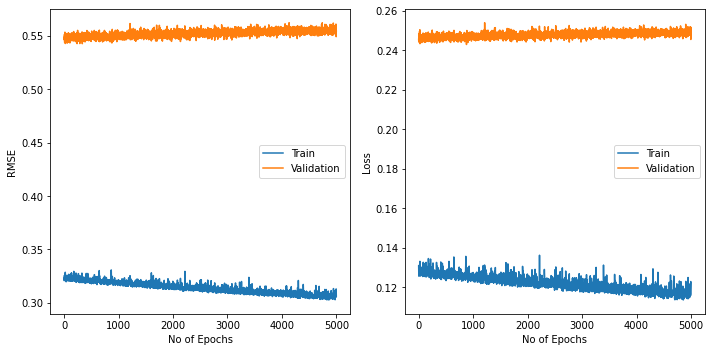

In [99]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('RMSE')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.tight_layout()

In [100]:
testPredicted = model.predict(x=[testInput1,testInput2],batch_size=40)

In [101]:
testPredicted.shape

(40, 300, 300, 1)

In [102]:
nSamples = 400
trainSamples = int( 0.7*nSamples)
testSamples = int(0.1*nSamples)
valSamples = int(0.2*nSamples)
refinement = 1
lenGrid = 300

maskedIndexFile = open('maskedIndexTotal_suffled.pkl', 'rb')
maskedIndexTotal = pickle.load(maskedIndexFile)
maskedIndexFile.close()


<ipython-input-103-0b7ab36547b3>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,10))


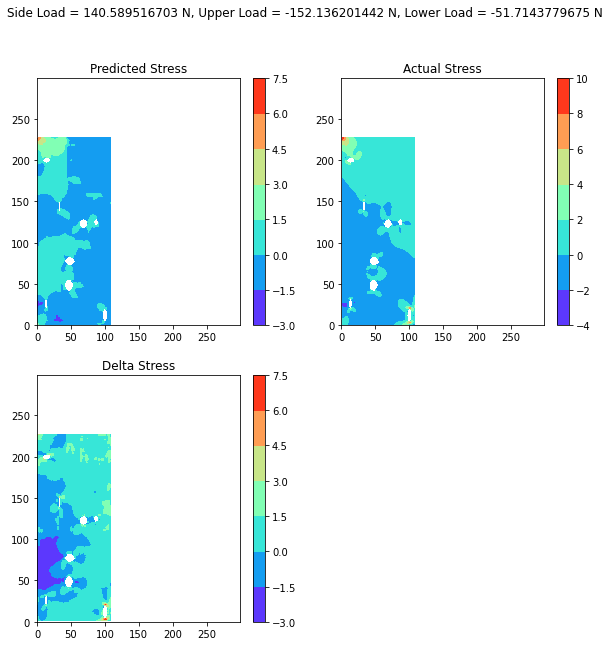

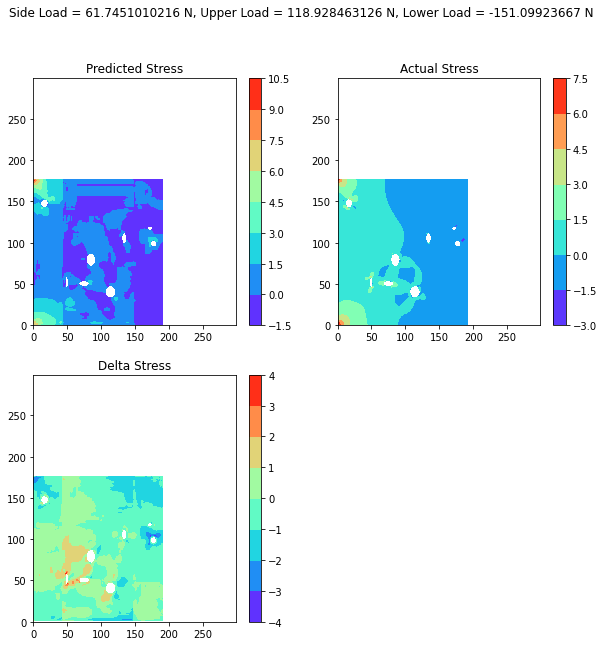

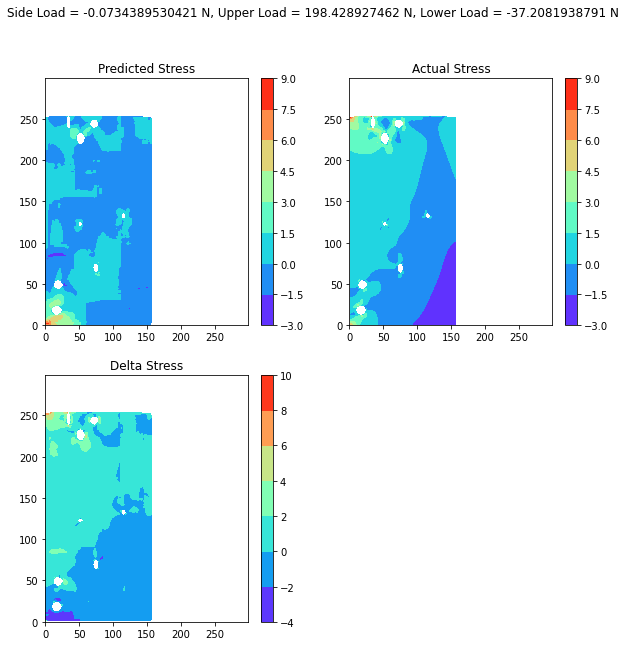

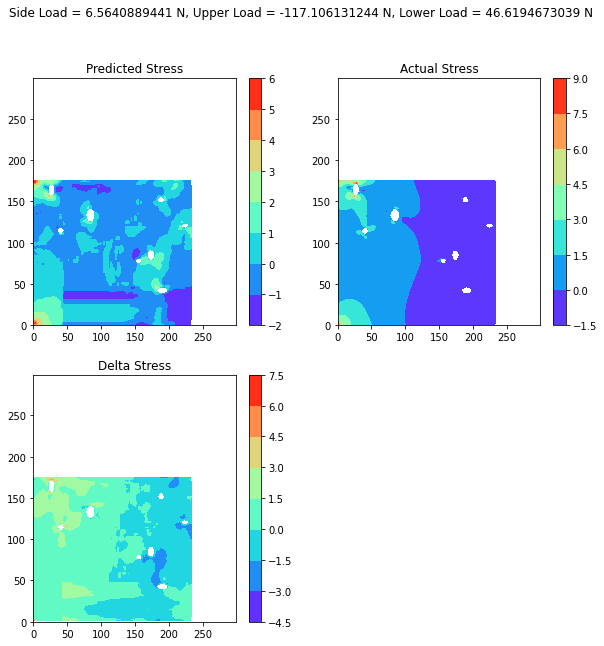

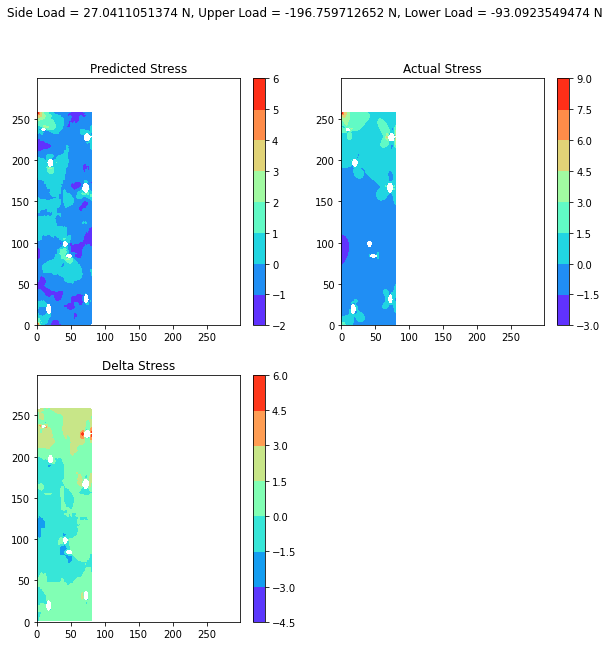

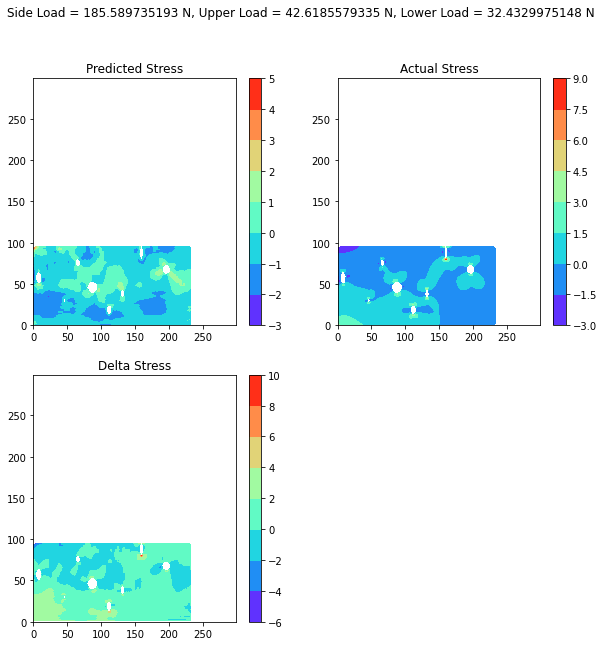

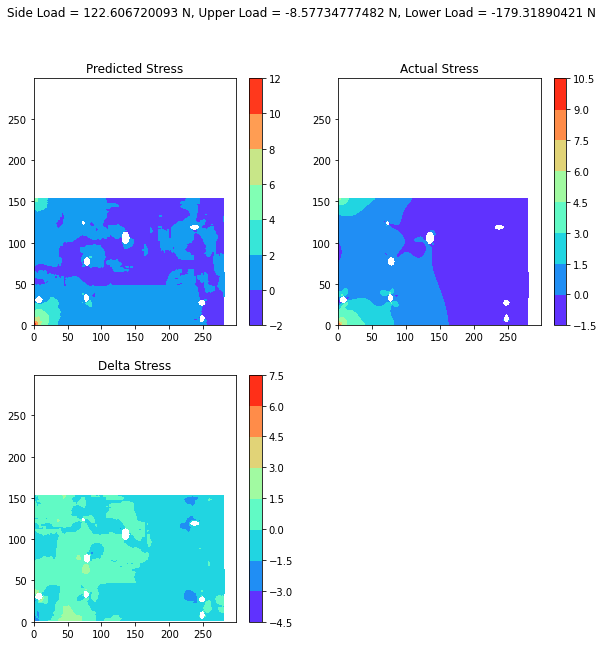

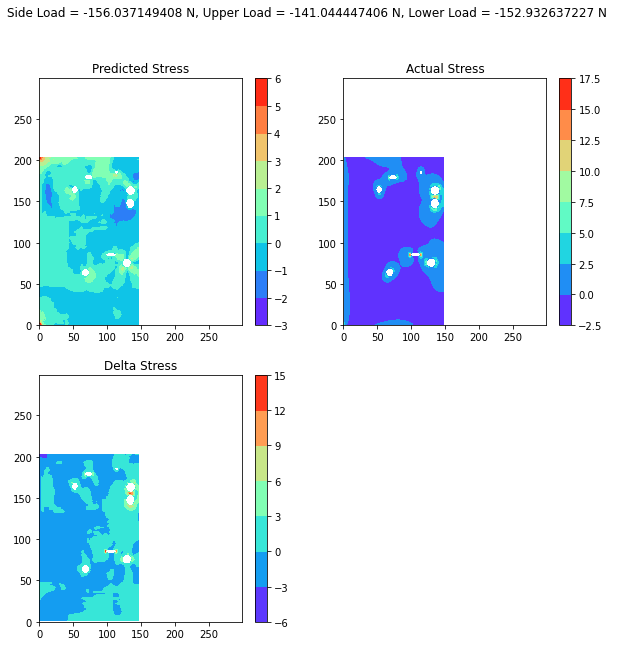

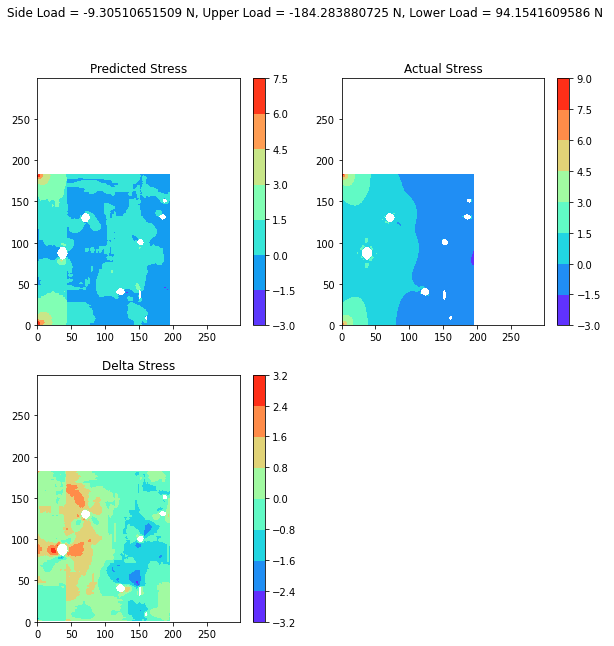

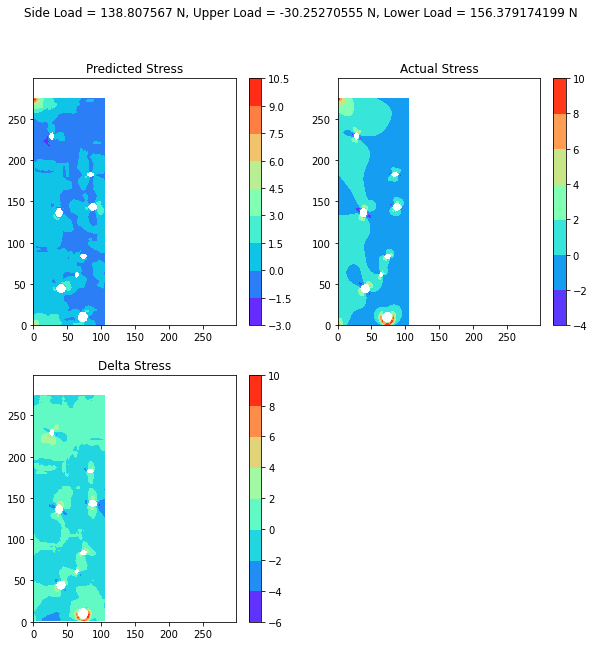

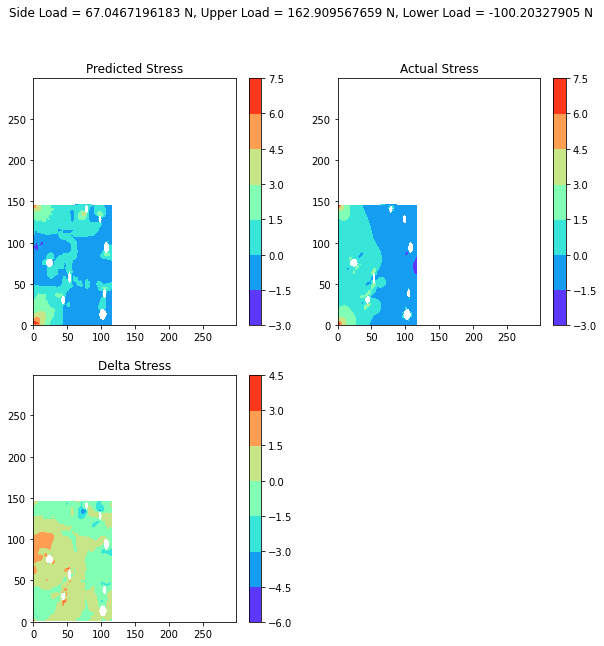

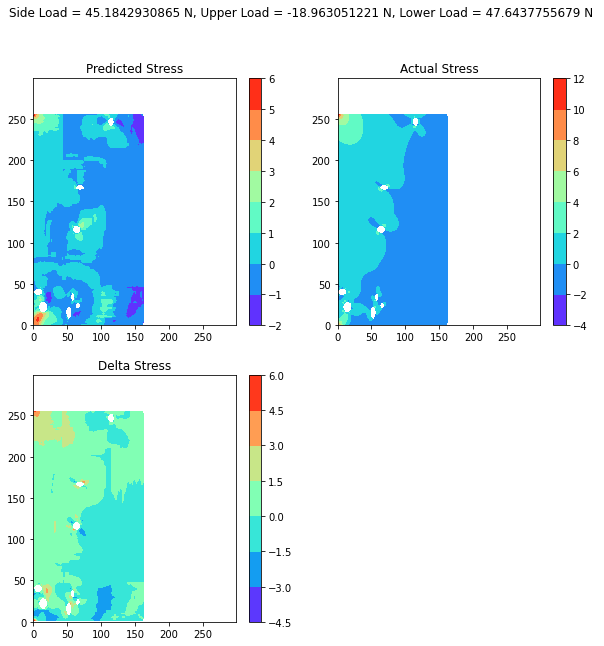

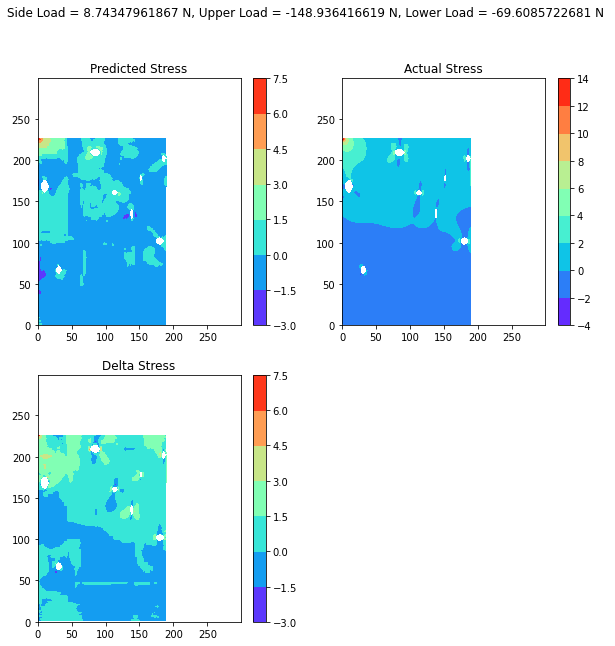

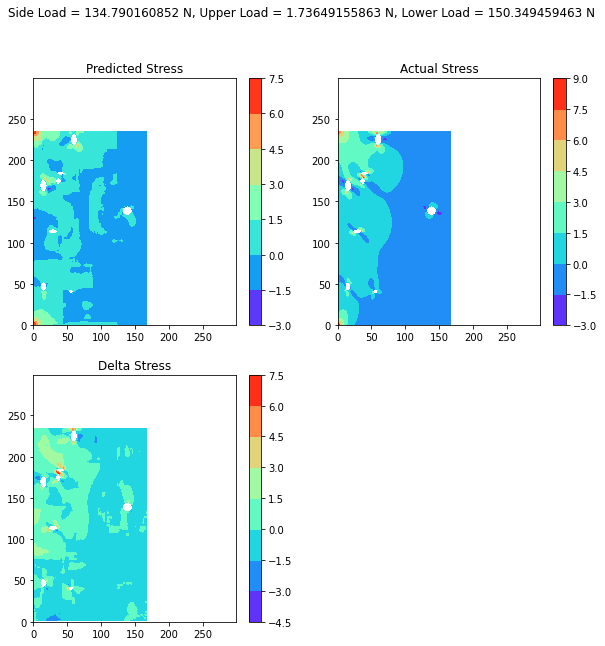

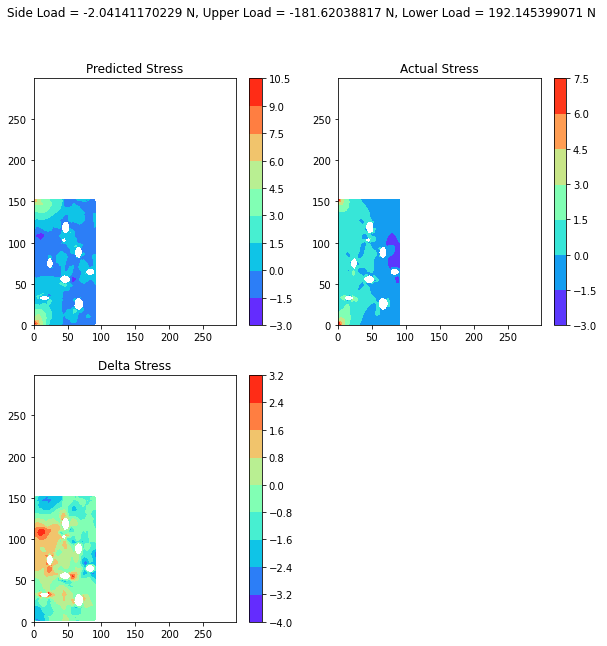

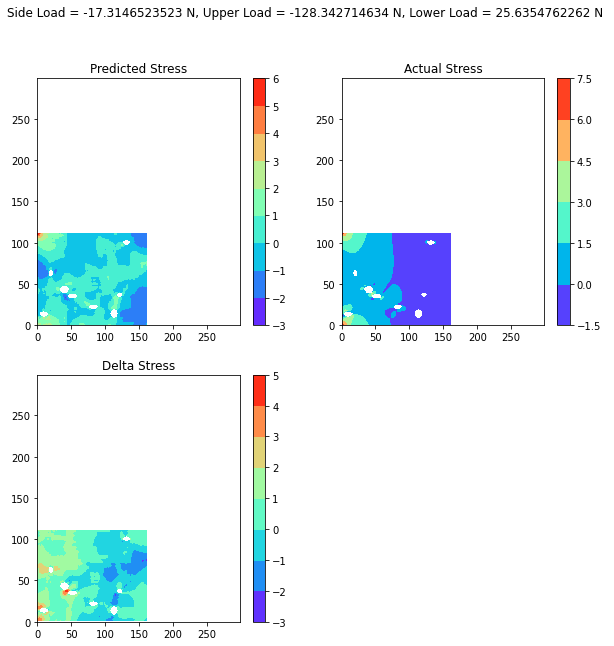

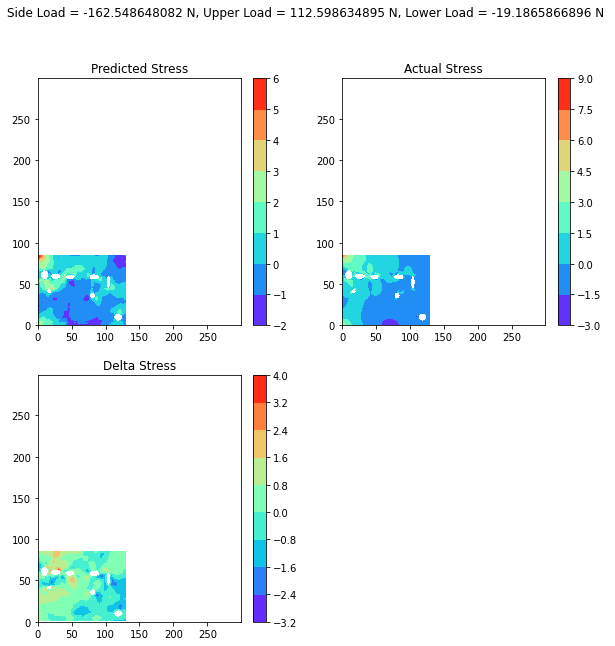

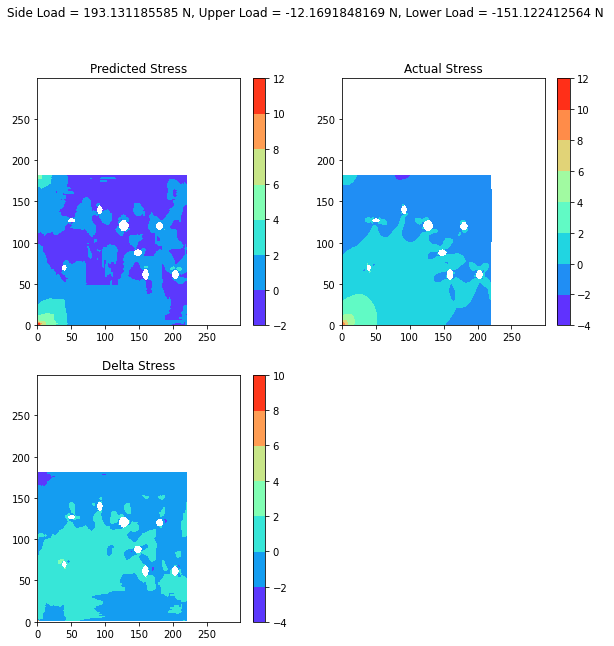

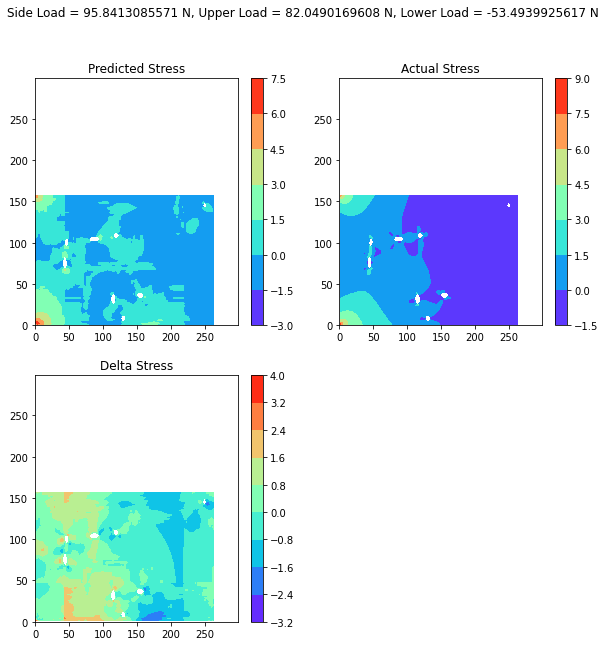

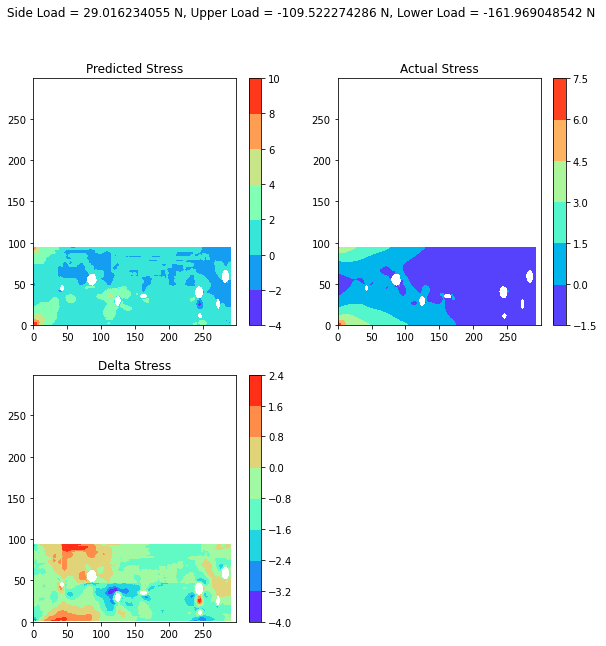

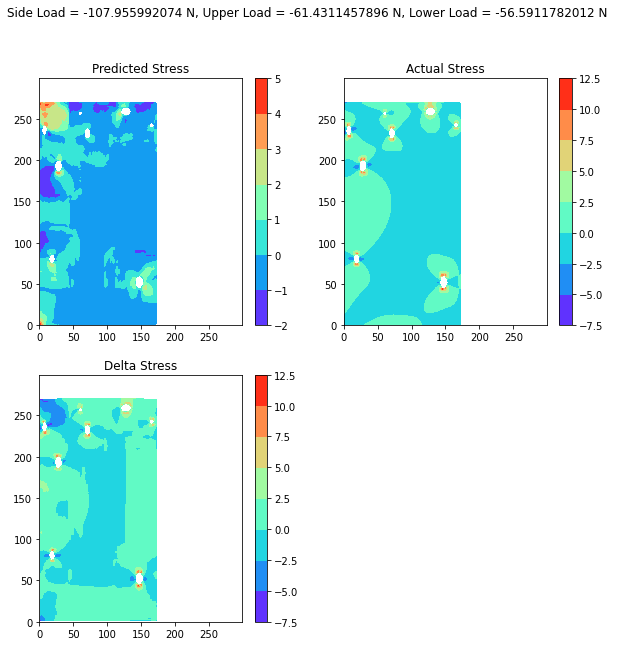

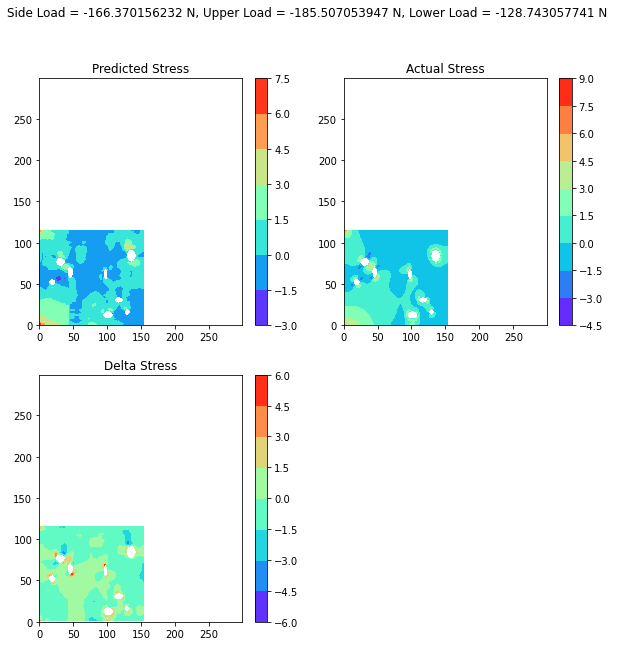

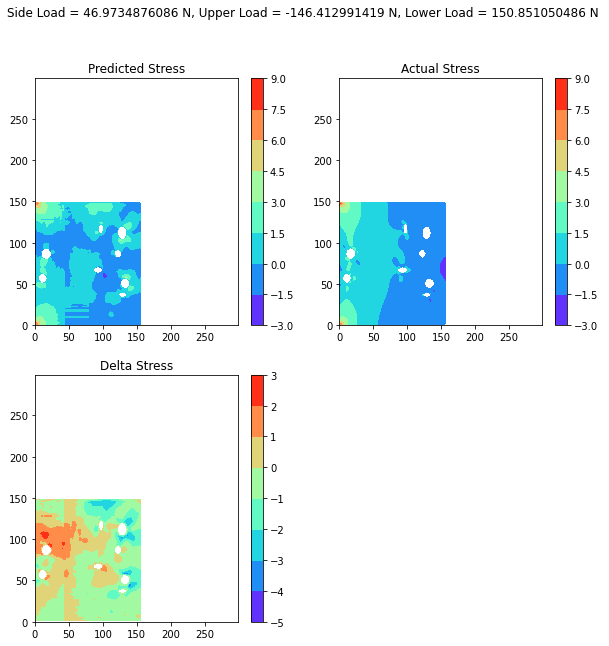

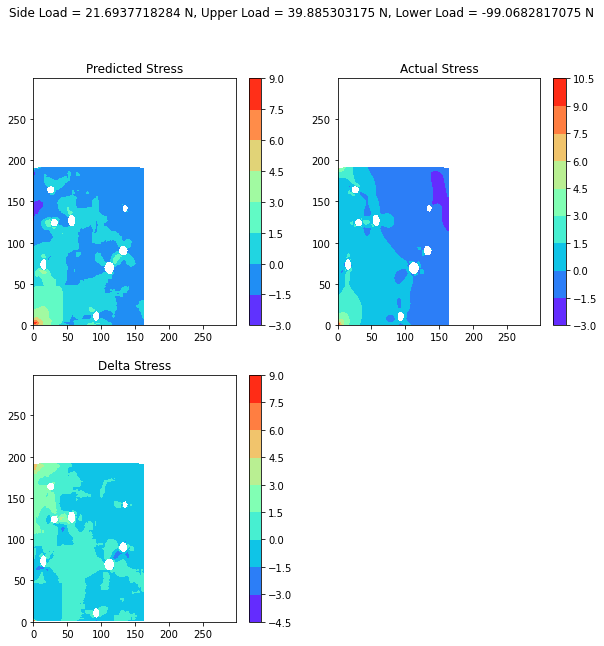

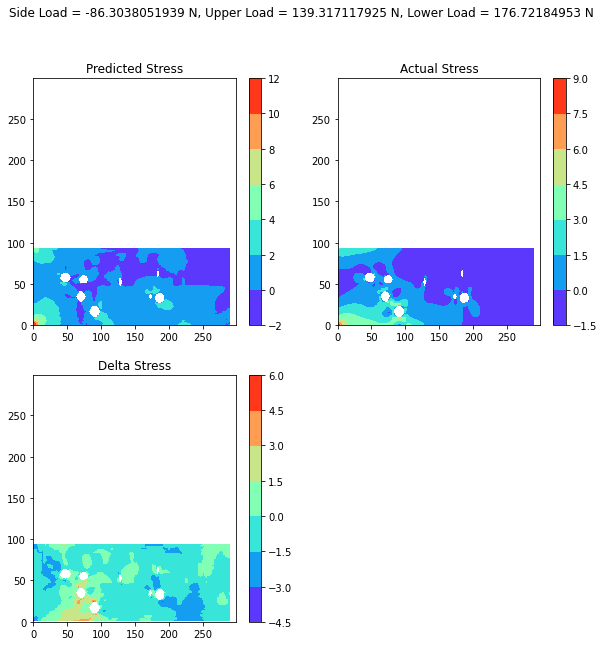

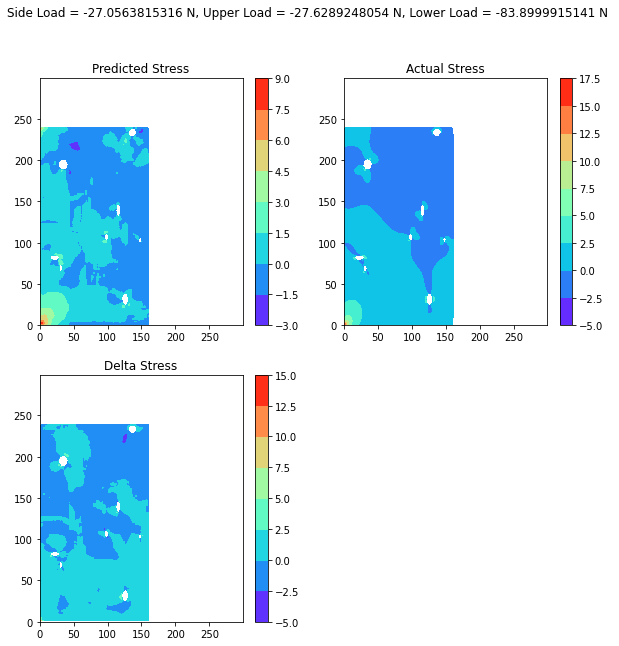

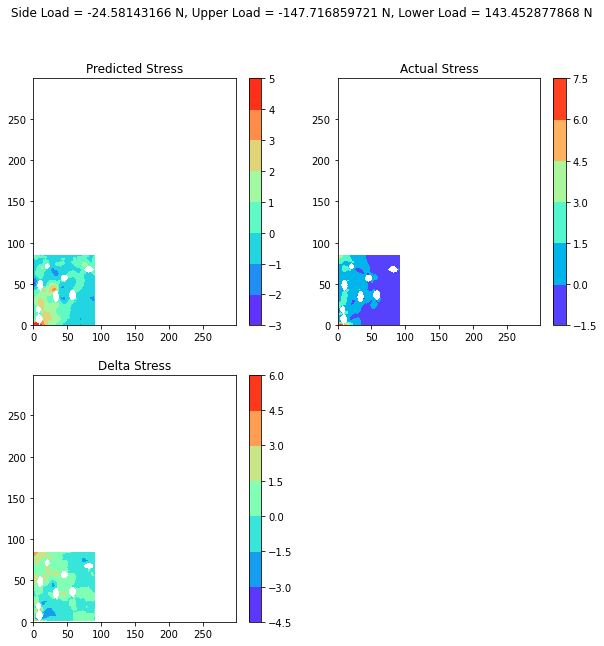

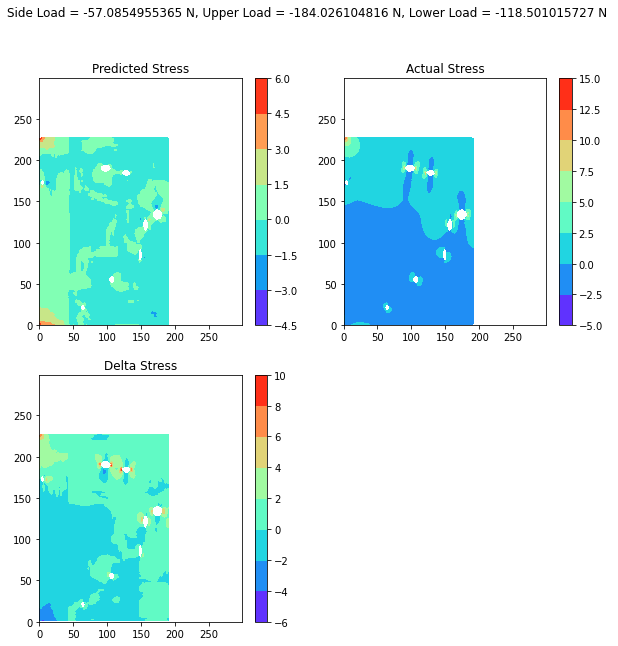

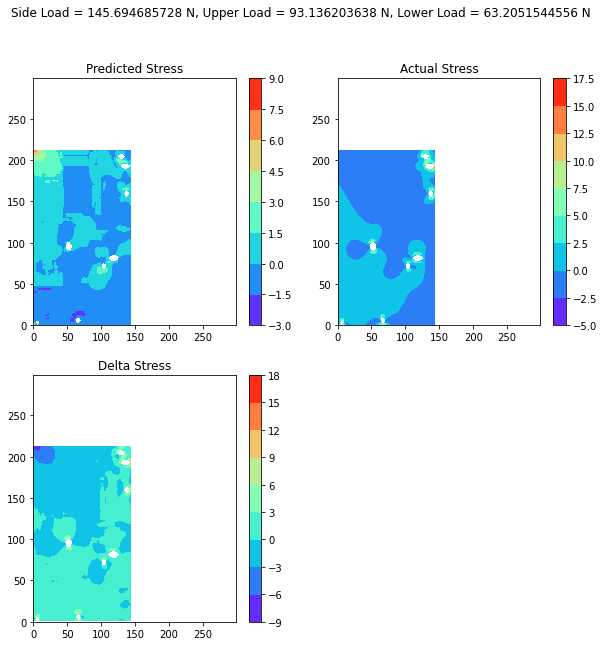

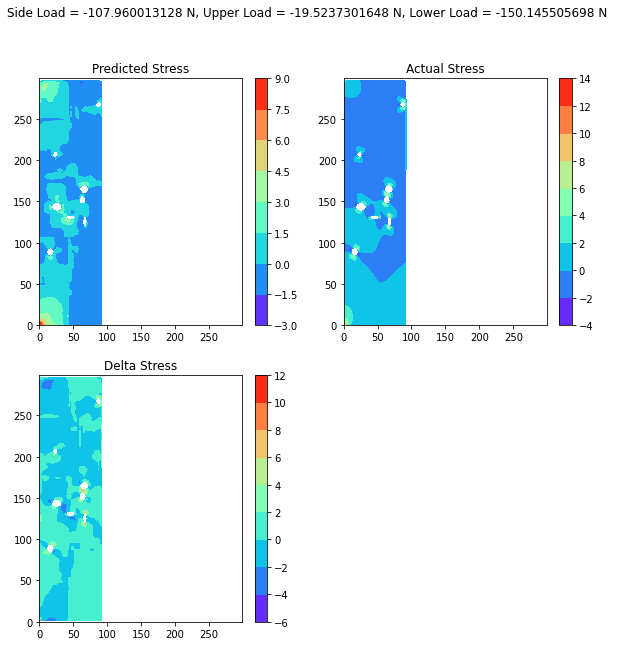

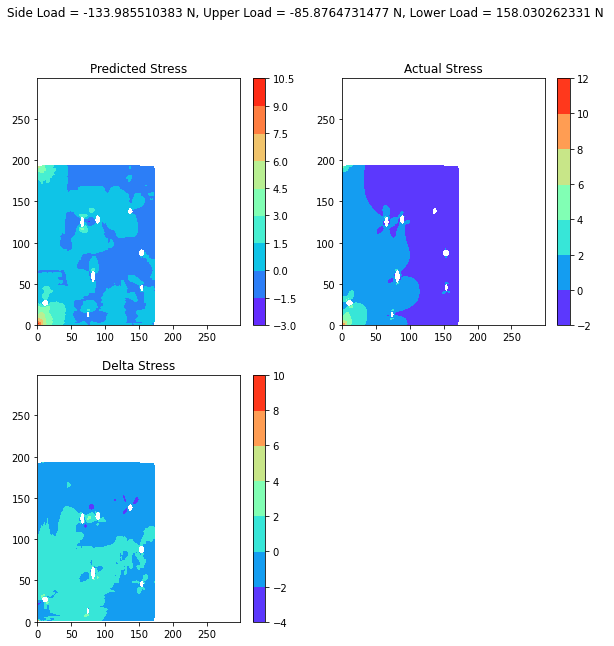

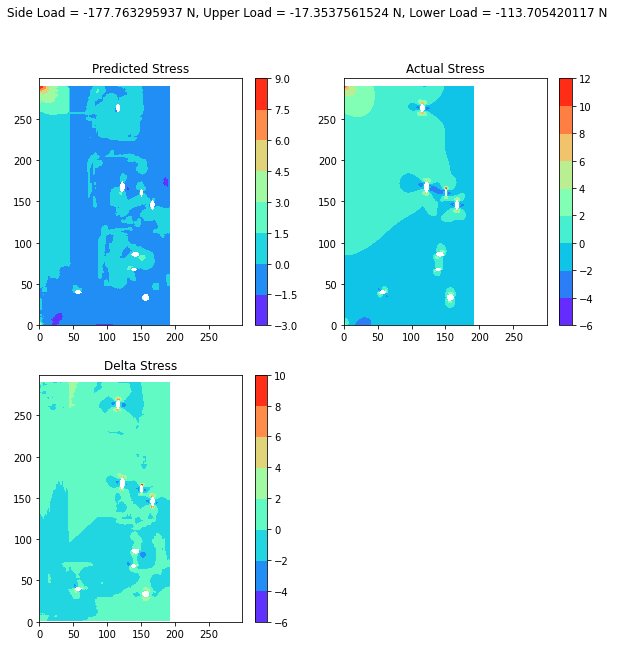

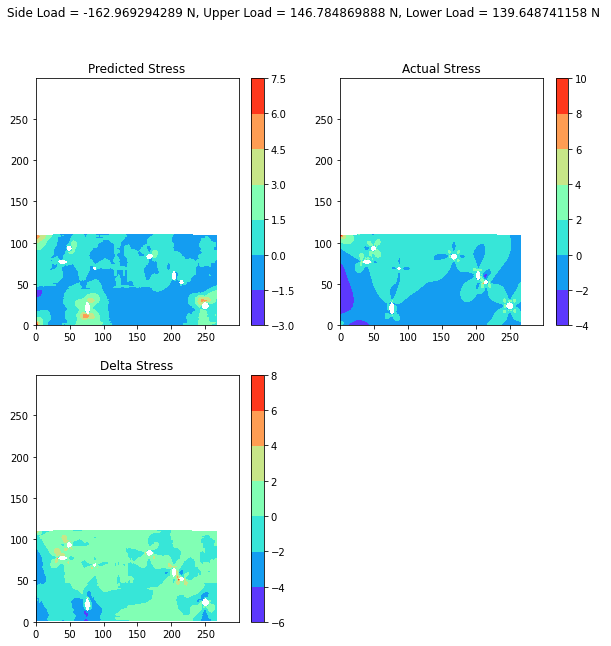

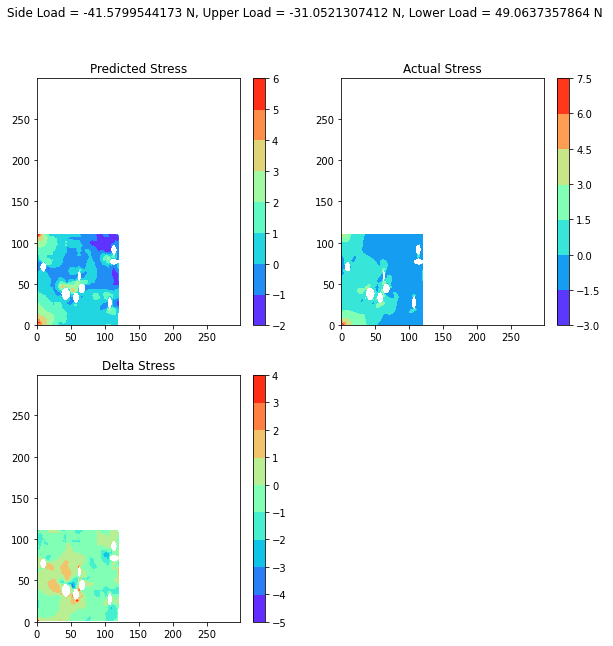

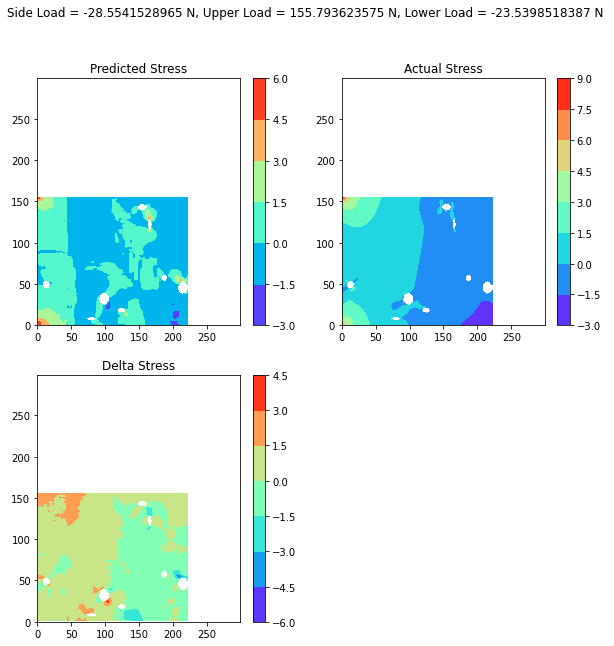

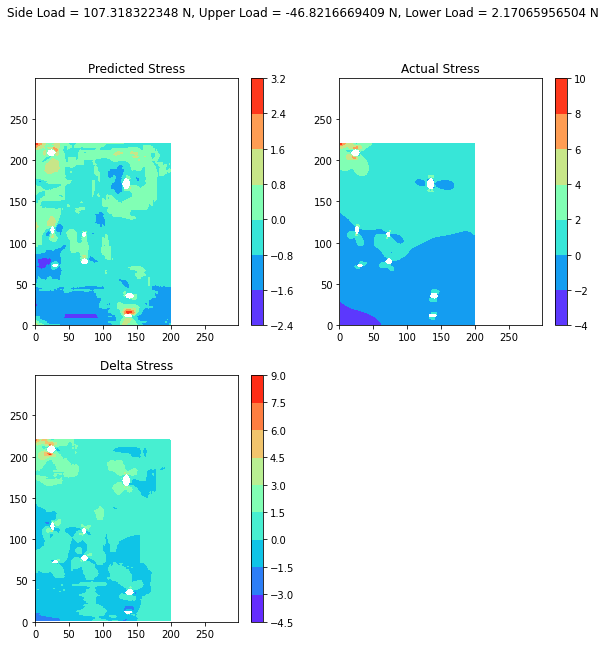

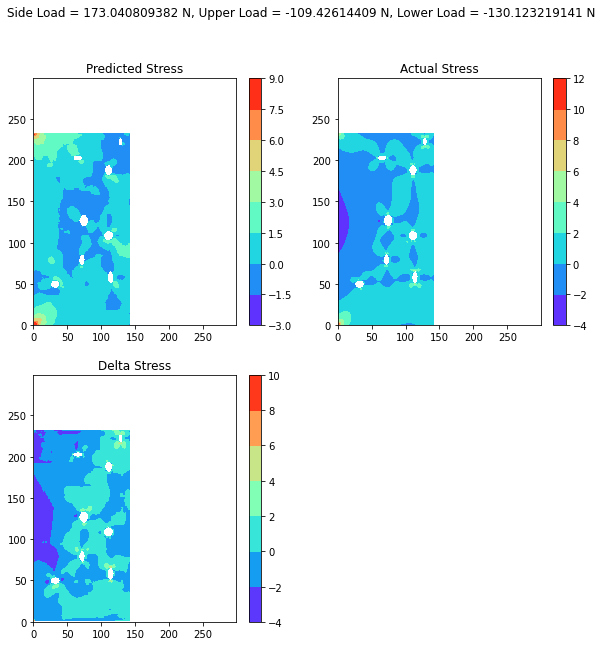

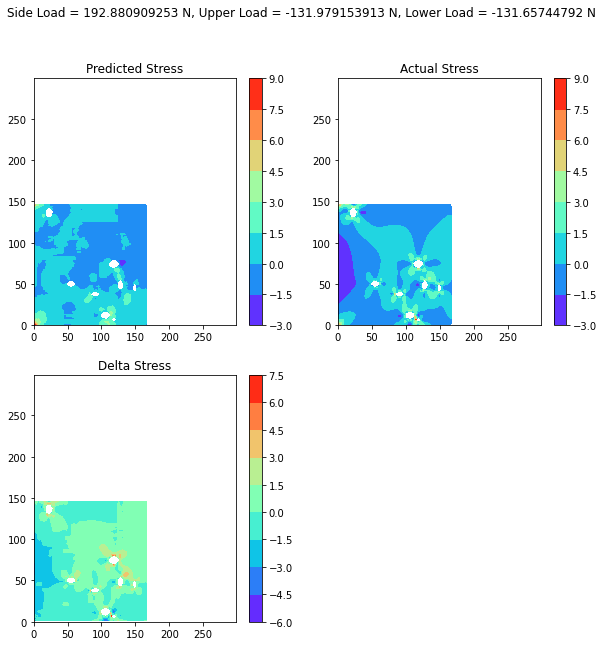

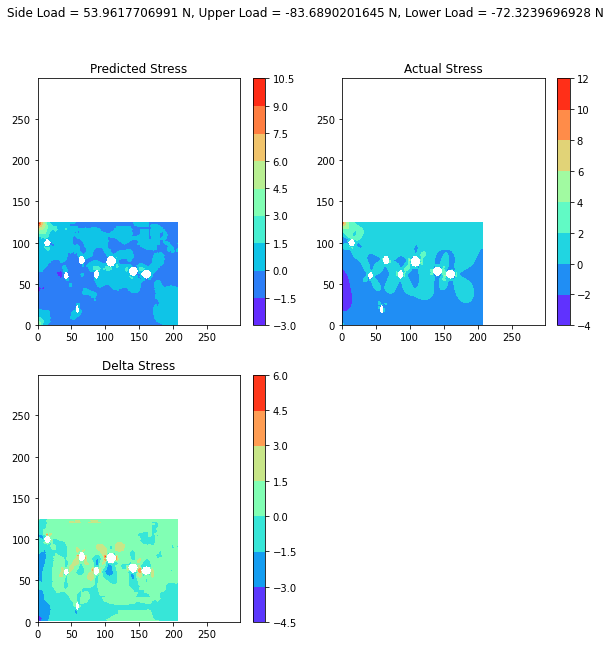

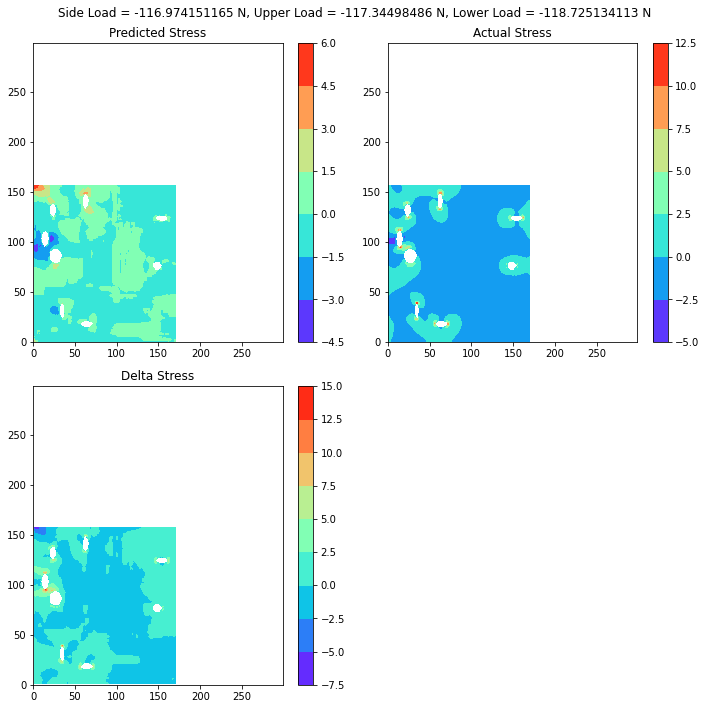

In [103]:
x = np.arange(0, lenGrid, refinement)
y = np.arange(0, lenGrid, refinement)

x, y = np.meshgrid(x, y)

for i in range(0, testPredicted.shape[0]):

  zPredict= testPredicted[i][:][:][:]


  zPredict = np.squeeze(zPredict, axis=2)

  maskedIndex = maskedIndexTotal[valSamples+trainSamples+i]

  zActual = testOutput[i][:][:]

  zDiff = zActual-zPredict

  zPredict[maskedIndex[0][:], maskedIndex[1][:]] = np.nan
  zActual[maskedIndex[0][:], maskedIndex[1][:]] = np.nan
  zDiff[maskedIndex[0][:], maskedIndex[1][:]] = np.nan

  fig = plt.figure(figsize=(10,10))
  fig.suptitle('Side Load = {} N, Upper Load = {} N, Lower Load = {} N '.format(testInput2[i][0][1], testInput2[i][1][1], testInput2[i][2][1]))
  plt.subplot(221)
  plt.contourf(x, y, zPredict , cmap='rainbow')
  plt.title('Predicted Stress')
  plt.colorbar()
  plt.subplot(222)
  plt.contourf(x,y,zActual,  cmap='rainbow')
  plt.title('Actual Stress')
  plt.colorbar()
  plt.subplot(223)
  plt.contourf(x,y,zDiff,  cmap='rainbow')
  plt.title('Delta Stress')
  plt.colorbar()
  plt.savefig('Results/15000_{}.png'.format(i))

plt.tight_layout()